# 1. Data Background and Problem Formulation

In this project, a dataset is given with 900+ data each corresponding to individual indicators of users' experience surveys revolving around proposed system designs -- and how would potential users react or perceive this notion. 

The goal is to provide a deep learning model with an acceptable rate of AUC (0.7 to 0.9) on test dataset in order to be able to predict certain words clearly.

To gain a better sense of the data, we first import the necessities to run the overall code.

---


In [1]:
# Configure output settings to prettify print display

from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [2]:
# Ignore warnings to prettify print

import warnings
warnings.filterwarnings("ignore")

In [3]:
!pip install scikit-multilearn
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import imblearn

You should consider upgrading via the 'c:\users\chari\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


##1.1. Importing the data
We can then import the data via `pandas` package to see the overall nature of the data, the outputs, and the datatypes.

In [5]:
df = pd.read_excel('Sample.xlsx', sheet_name='PROMISE-Extended_Ivan33')
df.drop(columns=['ID', 'ProjectID', 'Class'], axis=1, inplace=True)
df.sample(n=10, random_state=1)

Requirements  \
718  Secure data transfer over the Internet could b...   
637  The system shall validate the amount is availa...   
759  Sensitive data will be encrypted before being ...   
366  PME Subsystem shall allow building product men...   
543  The system shall be responsive. At the DePaul ...   
41   The product shall synchronize with the office ...   
120  Program Administrators and Nursing Staff Membe...   
725  It must be able to download the most recent me...   
795  Customer must logout of the site after purchas...   
672  Changes made to the Manage My ID website can b...   

     obstructive<==>supportive  complicated<==>easy  inefficient<==>efficient  \
718                          7                    5                         6   
637                          7                    6                         7   
759                          7                    6                         7   
366                          5                    4                         6   
543                          6                    6                         7   
41                           5                    5                         5   
120                          6                    5                         6   
725                          6                    7                         6   
795                          3                    2                         3   
672                          4                    3                         4   

      confusing<==>clear  boring<==>exciting  not interesting<==>interesting  \
718                    6                   3                               4   
637                    7                   2                               3   
759                    7                   4                               4   
366                    5                   3                               4   
543                    7                   5                               6   
41                     5                   5                               4   
120                    5                   5                               4   
725                    7                   3                               4   
795                    2                   1                               2   
672                    3                   3                               4   

     conventional<==>inventive  usual<==>leading edge  
718                          3                      3  
637                          1                      1  
759                          2                      3  
366                          4                      4  
543                          3                      4  
41                           4                      5  
120                          3                      2  
725                          3                      3  
795                          4                      6  
672                          4                      5

## 1.2. Column Definitions
### 1.2.1. Features

Features are only represented in the first column, which is the `Requirements` column. This column represents the question and/or the funcionalities of the system itself.

### 1.2.2. Labels

Labels, on the other hand, comprised of 8 columns in total. They are:
* **obstructive<==>supportive**, measuring supportiveness.
* **complicated<==>easy**, measuring ease-of-use.
* **inefficient<==>efficient**, measuring efficiency.
* **confusing<==>clear**, measuring brevity and clarity.
* **boring<==>exciting**, measuring excitement.
* **not interesting<==>interesting**, measuring appeal.
* **conventional<==>inventive**, measuring innovation.
* **usual<==>leading edge**, measuring technology usage.

The scales on the labels vary from 1 to 7, in which values closer to 1 corresponds to a more negative connotation, while values closer to 7 is likely to be more positive.

For example, for column `boring<==>exciting`, if a user gives it a 3, whilst this may seem neutral at first glance, we can infer that the user does not regard this system design as easy-to-use -- otherwise they would give it a score of 5 or 6.

For this task, we'll run multiclass multilabel regression since we obtained a good AUC with multiclass regression on one column before with simple regression. **The trick here is to not use a single column.**

With this, we might want to approach the problem within the scope of [Multi-output Regression](https://machinelearningmastery.com/deep-learning-models-for-multi-output-regression/)

First, we separate the labels from the data.

In [6]:
features = df.iloc[:, 0].values # First column in the entire set
labels = df.iloc[:, np.r_[1:9]].values
print("Features is now of type:", type(features), "with shape", features.shape)
print("Labels is now of type:", type(labels), "with shape", labels.shape)

Features is now of type: <class 'numpy.ndarray'> with shape (969,)
Labels is now of type: <class 'numpy.ndarray'> with shape (969, 8)


We know from previous work that the dataset is very much imbalanced, so we would want to try oversampling across all columns and make them our new label. But first, we would want to convert features as word vectors first.

## 1.3. Quick EDA

We can visualize the most used words via `wordcloud` used in our dataset.

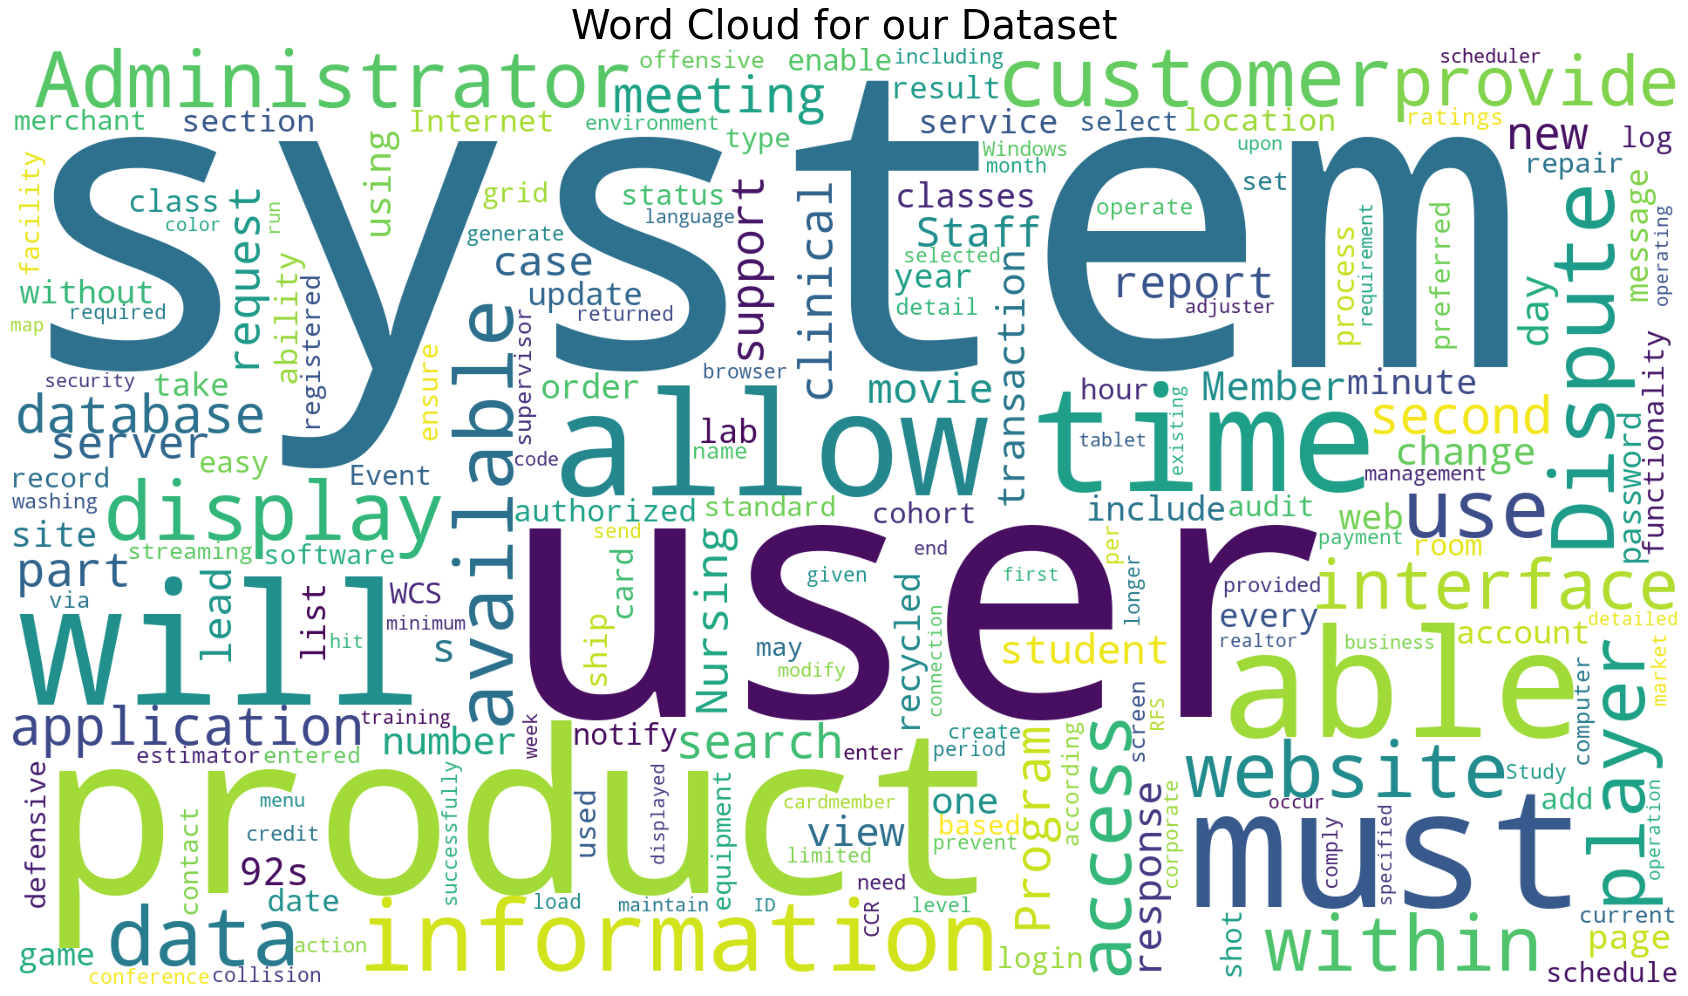

In [7]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize=(30,20))
text =df['Requirements'].values
cloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',
                          collocations=False,
                          width=1920,
                          height=1080
                         ).generate(" ".join(text))
plt.axis('off')
plt.title("Word Cloud for our Dataset",fontsize=40)
plt.imshow(cloud)

In [8]:
from collections import Counter
for i in range(8):
  print("Column:", df.columns[1:][i])
  print(Counter(labels[:,i]))

Column: obstructive<==>supportive
Counter({7: 418, 6: 281, 5: 152, 4: 63, 3: 37, 2: 16, 1: 2})
Column: complicated<==>easy
Counter({6: 278, 5: 254, 7: 210, 4: 144, 3: 57, 2: 24, 1: 2})
Column: inefficient<==>efficient
Counter({7: 406, 6: 306, 5: 128, 4: 71, 3: 36, 2: 18, 1: 4})
Column:  confusing<==>clear
Counter({7: 443, 6: 245, 5: 148, 4: 68, 3: 38, 2: 23, 1: 4})
Column: boring<==>exciting
Counter({3: 256, 4: 249, 5: 185, 2: 142, 6: 89, 7: 26, 1: 22})
Column: not interesting<==>interesting
Counter({4: 265, 3: 245, 5: 222, 2: 103, 6: 92, 7: 23, 1: 19})
Column: conventional<==>inventive
Counter({3: 273, 2: 267, 4: 164, 5: 102, 1: 101, 6: 55, 7: 7})
Column: usual<==>leading edge
Counter({3: 259, 2: 253, 4: 177, 5: 112, 1: 101, 6: 61, 7: 6})


# 2. Pre-processing
---

## 2.1. Tokenization

Tokenization means splitting each word and vectorizing a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary). This process cleans up our text, lowercase, and remove punctuations. This step is basically the same from our previous work involving LSTMs.

This way, we can see which words appear the most in our training set.

In [9]:
tokenizer = Tokenizer(num_words = 2000, oov_token="<OOV>")
tokenizer.fit_on_texts(features)
word_index = tokenizer.word_index
dict(list(word_index.items())[:10])

{'<OOV>': 1,
 'the': 2,
 'shall': 3,
 'to': 4,
 'system': 5,
 'of': 6,
 'be': 7,
 'a': 8,
 'and': 9,
 'product': 10}

After tokenization, the next step is to turn those tokens into lists of sequence.

In [10]:
sequences = tokenizer.texts_to_sequences(features)
print(sequences[0]) # This corresponds to the first sentence in the training data.

[2, 5, 3, 674, 2, 32, 96, 675, 49]


## 2.2. Padding

When we train neural networks for NLP, we need sequences to be in the same size, that's why we use padding. Padding means that we convert all instances of the training data towards the same size. To do this, we need to specify a fixed length to transform all the instances on.

For the project, we can set the sequence by looking quickly at the average proportion of the training words.

In [11]:
import math
word_counts = []
for i in (features):
  word_counts.append(len(i.split(" ")))
print("Average word counts:" , sum(word_counts)/len(word_counts))

# Round max length of padding to the nearest tenth
max_length = math.ceil((sum(word_counts)/len(word_counts))/10) * 10
print("Padded onto length: ", max_length)

# Delete unused variable
del word_counts 

Average word counts: 18.223942208462333
Padded onto length:  20


We can then proceed to do the actual padding. This is done for all instances of the training example.

In [12]:
padded = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

for i in range(5):
  print("Sequence of length", len(sequences[i]), "was padded onto", len(padded[i]))

Sequence of length 9 was padded onto 20
Sequence of length 16 was padded onto 20
Sequence of length 29 was padded onto 20
Sequence of length 36 was padded onto 20
Sequence of length 35 was padded onto 20


In [13]:
padded[0]

array([  2,   5,   3, 674,   2,  32,  96, 675,  49,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0])

## 2.3. SMOTE Oversampling

Generally, oversampling makes fake data so that the minority labels are not squashed by the majority.

Constraint of using SMOTE within this dataset is that it's very fragile to classes with only one example. Since SMOTE works via k-nearest neighbors, at least two members of a class would be mandatory for it to work.

Synthetic samples generated with respect to the most amount of classes in all columns so that input shape (features and labels) are consistent against each other.

## REVISION: ROS Oversampling

ROS generates random data as opposed to the better, more superior SMOTE which generates "more credible" data. We can't use SMOTE on all sheets because of the `n_neighbors` and distance constraint.

We find the least common multiple of all class members amount, and oversample from there to get the matrix dimensions uniform.

In [14]:
import copy
from collections import defaultdict, Counter
from imblearn.over_sampling import SMOTE, RandomOverSampler
max_amount = np.lcm.reduce([1,2,3,4,5,6,7]) * 40
labels_processed = np.zeros((max_amount, 8))

for i in range(8):
  unique_classes = np.unique(df[df.columns[1:][i]])
  amount = [int(
      (max_amount/len(unique_classes)))
      ] * len(unique_classes)
  x = {k:v for (k,v) in zip(unique_classes, amount)}
  smt = RandomOverSampler(sampling_strategy=x)
  X, y = smt.fit_resample(padded, labels[:,i])
  labels_processed[:,i] = y
  print("Column", i, "done.")
  # We don't save nor use the X variable between each iteration, 
  # instead only using the last one.


print("Shape of input features is:", X.shape)
print("Shape of labels is:",labels_processed.shape)

Column 0 done.
Column 1 done.
Column 2 done.
Column 3 done.
Column 4 done.
Column 5 done.
Column 6 done.
Column 7 done.
Shape of input features is: (16800, 20)
Shape of labels is: (16800, 8)


In [15]:
# Sanity check time!
for i in range(8):
  print("For column", df.columns[1:][i])
  print(Counter(labels_processed[:,i]),"\n------")


print("First ten entries of the processed labels:\n", labels_processed[:10,:])
print("First ten entries of the processed features:\n", X[:10,:])

# Last and final assertion to catch matrix errors
try:
  assert(X.shape[0] == labels_processed.shape[0])
  print("Assertion completed!")
except AssertionError:
  print("Error!\nShape of X is", X.shape, "while labels is", labels_processed.shape)
  raise AssertionError

For column obstructive<==>supportive
Counter({3.0: 2400, 7.0: 2400, 5.0: 2400, 6.0: 2400, 2.0: 2400, 4.0: 2400, 1.0: 2400}) 
------
For column complicated<==>easy
Counter({4.0: 2400, 2.0: 2400, 3.0: 2400, 6.0: 2400, 1.0: 2400, 5.0: 2400, 7.0: 2400}) 
------
For column inefficient<==>efficient
Counter({3.0: 2400, 5.0: 2400, 7.0: 2400, 6.0: 2400, 2.0: 2400, 4.0: 2400, 1.0: 2400}) 
------
For column  confusing<==>clear
Counter({3.0: 2400, 5.0: 2400, 7.0: 2400, 6.0: 2400, 1.0: 2400, 4.0: 2400, 2.0: 2400}) 
------
For column boring<==>exciting
Counter({4.0: 2400, 3.0: 2400, 5.0: 2400, 2.0: 2400, 6.0: 2400, 7.0: 2400, 1.0: 2400}) 
------
For column not interesting<==>interesting
Counter({3.0: 2400, 5.0: 2400, 7.0: 2400, 4.0: 2400, 6.0: 2400, 2.0: 2400, 1.0: 2400}) 
------
For column conventional<==>inventive
Counter({6.0: 2400, 5.0: 2400, 3.0: 2400, 2.0: 2400, 4.0: 2400, 1.0: 2400, 7.0: 2400}) 
------
For column usual<==>leading edge
Counter({6.0: 2400, 4.0: 2400, 3.0: 2400, 2.0: 2400, 5.0: 

## 2.4. Train-test Splitting

Finally we get to this part. We can use sklearn's `train_test_split` to do the usual splitting for test set (validation set is specified within building the model in the next section).

Also, specifying `random_state` ensures reproducibility.

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, labels_processed, test_size=0.2, random_state=42)

# Sanity check again and again
print("Training examples:", X_train.shape)
print("Training labels:", y_train.shape)
print("Test examples:", X_test.shape)
print("Test labels:", y_test.shape)

Training examples: (13440, 20)
Training labels: (13440, 8)
Test examples: (3360, 20)
Test labels: (3360, 8)


# 3. Modelling

## 3.1. Building the Model

Since we're training on augmented data, we're going to approach this as conventional regression compared to the LSTM approach we're doing it before.

LSTM model in this manner would result in a pretty bad metric score (around 0.5 to 0.7 F1-score) whereas our fully-connected dense layers resulted in a pretty satisfying F1, which is around 0.8 to 1 for each column.

In [17]:
# Wrapper functions for result interpretation
from matplotlib import pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

def transform_results(estimates):
  res = []
  for x in estimates:
    if x > 7:
      x = 7
      res.append(x)
    else:
      res.append(x)
  return res

In [18]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

initializer = tf.keras.initializers.RandomNormal(seed=1) # Reproducibility

model = Sequential(name="classifier_NN")
model.add(tf.keras.Input(shape=(X_train.shape[1],))) # Automatically detect features as input nodes
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(128, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(128, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(128, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.15))
model.add(layers.Dense(8)) # output layer
opt = tf.keras.optimizers.Adam(learning_rate = 0.0005)
model.compile(loss=tf.keras.losses.MeanSquaredError(), metrics=['mae'], optimizer = opt)
model.summary()

Model: "classifier_NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               5376      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)             

Epoch 1/150
588/588 - 3s - loss: 4.6697 - mae: 1.6623 - val_loss: 3.0012 - val_mae: 1.3901
Epoch 2/150
588/588 - 2s - loss: 2.1442 - mae: 1.1545 - val_loss: 1.5755 - val_mae: 0.9968
Epoch 3/150
588/588 - 2s - loss: 1.6170 - mae: 0.9891 - val_loss: 1.3015 - val_mae: 0.8867
Epoch 4/150
588/588 - 2s - loss: 1.3769 - mae: 0.8881 - val_loss: 1.1267 - val_mae: 0.8068
Epoch 5/150
588/588 - 2s - loss: 1.2312 - mae: 0.8234 - val_loss: 0.9152 - val_mae: 0.6836
Epoch 6/150
588/588 - 2s - loss: 1.1149 - mae: 0.7712 - val_loss: 0.9787 - val_mae: 0.7298
Epoch 7/150
588/588 - 3s - loss: 1.0584 - mae: 0.7390 - val_loss: 0.8916 - val_mae: 0.6672
Epoch 8/150
588/588 - 2s - loss: 0.9964 - mae: 0.7022 - val_loss: 0.8048 - val_mae: 0.6136
Epoch 9/150
588/588 - 2s - loss: 0.9698 - mae: 0.6903 - val_loss: 0.8880 - val_mae: 0.6531
Epoch 10/150
588/588 - 2s - loss: 0.8781 - mae: 0.6462 - val_loss: 0.7144 - val_mae: 0.5514
Epoch 11/150
588/588 - 2s - loss: 0.8532 - mae: 0.6296 - val_loss: 0.6627 - val_mae: 0.52

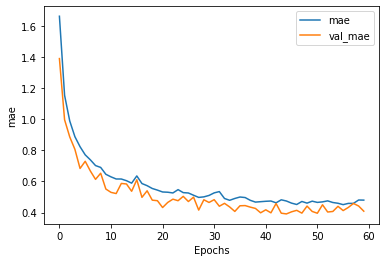

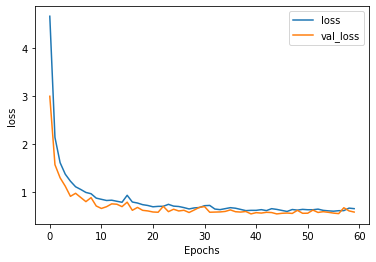

In [19]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
history = model.fit(X_train, y_train, epochs=150, batch_size = 16, validation_split=0.3, 
                    callbacks = [es], # Call checkpoint variable if neccessary
                    verbose=2)

plot_graphs(history, "mae")
plot_graphs(history, "loss")

## 3.2. Result Interpretation and Evaluation

Here we evaluate on `y_test`, which we made sure earlier comes from a similar distribution within the training set itself. 

Resulted on a pretty confident `mae` and `mse`, which I would say a good result considering the number of classes we have.

In [20]:
scores = model.evaluate(
    X_test, y_test, batch_size=1, verbose=1, sample_weight=None, steps=None,
    callbacks=None, max_queue_size=10, workers=4, use_multiprocessing=False,
    return_dict=False
)
print("------------------ EVALUATION FINISHED! ------------------".center(115))
for i in range(len(scores)):
    print("%s: %.2f%%" % (model.metrics_names[i], scores[i]*100))

3360/3360 [==============================] - 5s 2ms/step - loss: 0.6101 - mae: 0.4186
                             ------------------ EVALUATION FINISHED! ------------------                            
loss: 61.01%
mae: 41.86%


We can also print classification report from each column.

In [21]:
from sklearn.metrics import classification_report, f1_score
y_pred = model.predict(X_test)
for i in range(8):
  print("Column", df.columns[1:][i])
  estimates = [round(float(x)) for x in y_pred[:,i]]
  estimates = transform_results(estimates)
  print(np.unique(estimates))
  print(classification_report(y_test[:,i], estimates), "\n------")

Column obstructive<==>supportive
[1 2 3 4 5 6 7]
              precision    recall  f1-score   support

         1.0       0.94      0.84      0.89       462
         2.0       0.68      0.46      0.55       482
         3.0       0.51      0.67      0.58       510
         4.0       0.57      0.65      0.61       517
         5.0       0.59      0.63      0.61       467
         6.0       0.72      0.61      0.66       470
         7.0       0.80      0.81      0.81       452

    accuracy                           0.67      3360
   macro avg       0.69      0.67      0.67      3360
weighted avg       0.68      0.67      0.67      3360
 
------
Column complicated<==>easy
[1 2 3 4 5 6 7]
              precision    recall  f1-score   support

         1.0       0.94      0.84      0.88       463
         2.0       0.71      0.59      0.64       485
         3.0       0.56      0.69      0.62       501
         4.0       0.60      0.66      0.63       515
         5.0       0.63      0.6

## 3.3. Prepare the Plotting Set

Due to the multi-dimensional nature of our results and test set, we need to reshape the predictions by using `numpy`'s `flatten()` attribute, which flattens the array column-wise if we specify the argument `order='F'` to flatten in Fortran-style order.

Keep in mind this will indeed aggregate the metrics like on the `classification_report()` below.

In [22]:
y_pred_flattened = y_pred.flatten(order='F')
y_test_flattened = y_test.flatten(order='F')
y_classified = [round(float(x)) for x in y_pred_flattened]

print("First ten examples of the test set:")
print("Truth labels:", y_test_flattened[:10])
print("Predicted labels:",y_classified[:10])
print("Overall performance on all columns:\n", classification_report(y_test_flattened, y_classified))

First ten examples of the test set:
Truth labels: [2. 1. 2. 1. 4. 3. 4. 3. 3. 7.]
Predicted labels: [2, 1, 2, 2, 5, 4, 4, 3, 4, 1]
Overall performance on all columns:
               precision    recall  f1-score   support

         1.0       0.95      0.86      0.90      3691
         2.0       0.75      0.64      0.69      3921
         3.0       0.61      0.72      0.66      3952
         4.0       0.67      0.73      0.70      4161
         5.0       0.72      0.76      0.74      3786
         6.0       0.85      0.74      0.79      3748
         7.0       0.90      0.91      0.91      3621

    accuracy                           0.76     26880
   macro avg       0.78      0.77      0.77     26880
weighted avg       0.77      0.76      0.77     26880



In [23]:
# Wrapper function(s) from earlier notebook
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
  """
  Modified function behavior, now predicts column-wise
  """
  y_score = clf.predict_proba(X_test)
  target_names = np.unique(y_test)
  # structures
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
 
  # calculate dummies once
  y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
  print(y_test_dummies.shape, y_score.shape)
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])
  
# roc for each class
  fig, ax = plt.subplots(figsize=figsize)
  ax.plot([0, 1], [0, 1], 'k--')
  ax.set_xlim([0.0, 1.0])
  ax.set_ylim([0.0, 1.05])
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('Receiver operating characteristic')
    
  for i in range(len(target_names)):
    ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], target_names[i]))
  
  ax.legend(loc="best")
  ax.grid(alpha=.4)
  sns.despine()
  plt.show()

def plot_multiclass_roc_LSTM(X_test, y_test, n_classes, figsize=(17, 6), model=model):
  """
  Custom-made function to plot ROC curve.
  Sorry I can't run because I don't have the excel file used for this particular notebook.
  """
  y_score = to_categorical(y_test)
  target_names = ["obstructive vs supportive",
                  "complicated vs easy",
                  "inefficient vs efficient",
                  " confusing vs clear",
                  "boring vs exciting",
                  "not interesting vs interesting",
                  "conventional vs inventive",
                  "usual vs leading edge"]
  # structures
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
 
  # One-liner transformation of our existing result 
  y_test_dummies = np.pad(pd.get_dummies(y_classified, drop_first=False).values, 
                          ((0,0), 
                           (min(labels.flatten()),0)))
  print(y_test_dummies.shape, y_score.shape) # Quick debug purposes after one-hot encoding
                                             # to ensure matrix dimension is right
  for i in range(1, n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])
  
# roc for each class
  fig, ax = plt.subplots(figsize=figsize)
  ax.plot([0, 1], [0, 1], 'k--')
  ax.set_xlim([0.0, 1.0])
  ax.set_ylim([0.0, 1.05])
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('Column-wise Receiver Operating Characteristic Plot')
    
  for i in range(1, len(target_names)):
    ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], target_names[i]))
  
  ax.legend(loc="best")
  ax.grid(alpha=.4)
  sns.despine()
  plt.show()


# plot_multiclass_roc_LSTM(X_test, y_classified, 8, figsize=(17, 6))

ROC AUC score: 0.862355214714738


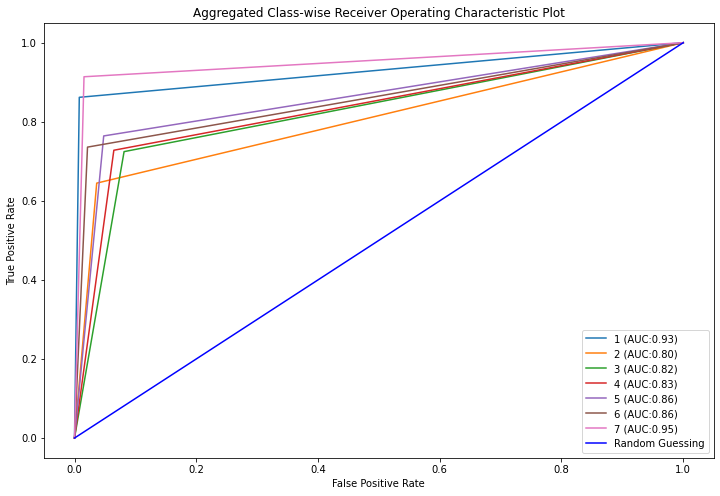

In [24]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
def multiclass_roc_auc_score(y_test, y_pred, average="weighted"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(set(labels.flatten())):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test_flattened, y_classified))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
c_ax.set_title('Aggregated Class-wise Receiver Operating Characteristic Plot')
plt.savefig("auc.png")
plt.show()

## 3.4. Exporting the Model

We can export the model to `HDF5` format designed to store large amounts of information. More info:
* [Wikipedia](https://en.wikipedia.org/wiki/Hierarchical_Data_Format)
* [TensorFlow Documentation](https://www.tensorflow.org/tutorials/keras/save_and_load#hdf5_format)

In [25]:
model.save('UX_Regression.h5')

## 3.5. XGB Method
For comparison, we try implementing XGB.

For column: obstructive<==>supportive
[16:53:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       462
         2.0       0.83      0.88      0.86       482
         3.0       0.76      0.71      0.74       510
         4.0       0.67      0.68      0.67       517
         5.0       0.65      0.65      0.65       467
         6.0       0.73      0.72      0.73       470
         7.0       0.81      0.81      0.81       452

    accuracy                           0.77      3360
   macro avg       0.77      0.77      0.77      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  20   0   0   0   0   0]
 [ 

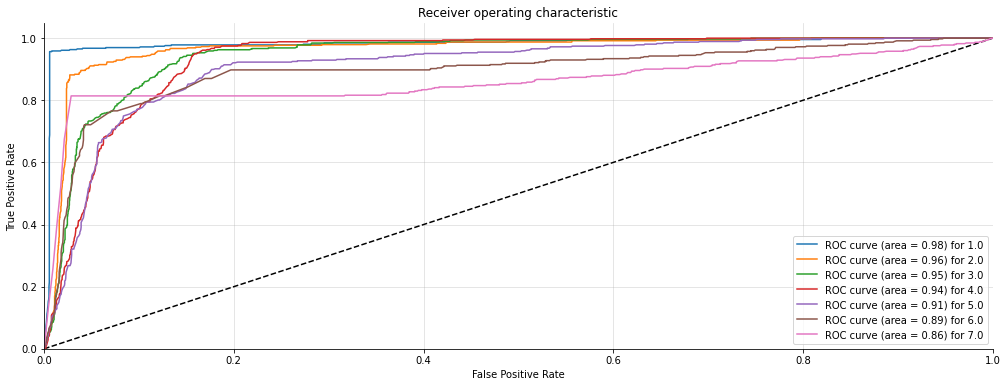

For column: complicated<==>easy
[16:53:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.84      0.88      0.86       485
         3.0       0.76      0.73      0.75       501
         4.0       0.70      0.70      0.70       515
         5.0       0.71      0.74      0.72       460
         6.0       0.83      0.79      0.81       484
         7.0       0.90      0.90      0.90       452

    accuracy                           0.81      3360
   macro avg       0.81      0.81      0.81      3360
weighted avg       0.81      0.81      0.81      3360

Confusion Matrix: 
 [[442  20   0   0   0   1   0]
 [  3 426

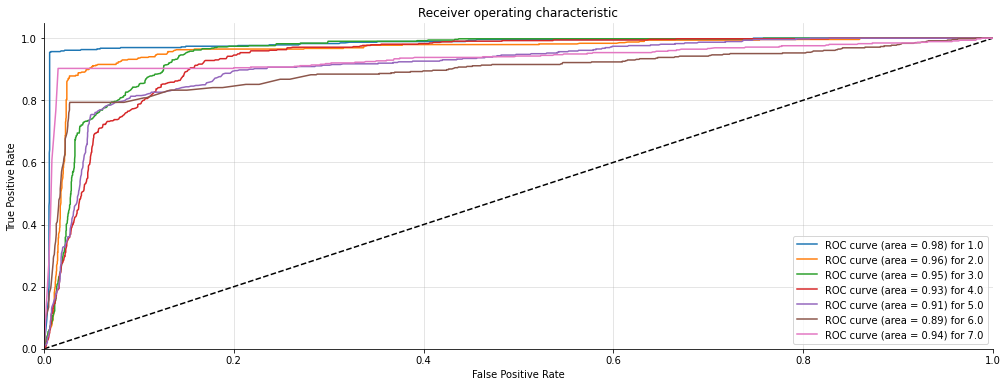

For column: inefficient<==>efficient
[16:53:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       462
         2.0       0.84      0.88      0.86       482
         3.0       0.76      0.72      0.74       506
         4.0       0.68      0.68      0.68       526
         5.0       0.65      0.66      0.66       458
         6.0       0.72      0.71      0.71       475
         7.0       0.83      0.83      0.83       451

    accuracy                           0.78      3360
   macro avg       0.78      0.78      0.78      3360
weighted avg       0.77      0.78      0.77      3360

Confusion Matrix: 
 [[442  19   0   0   0   1   0]
 [  

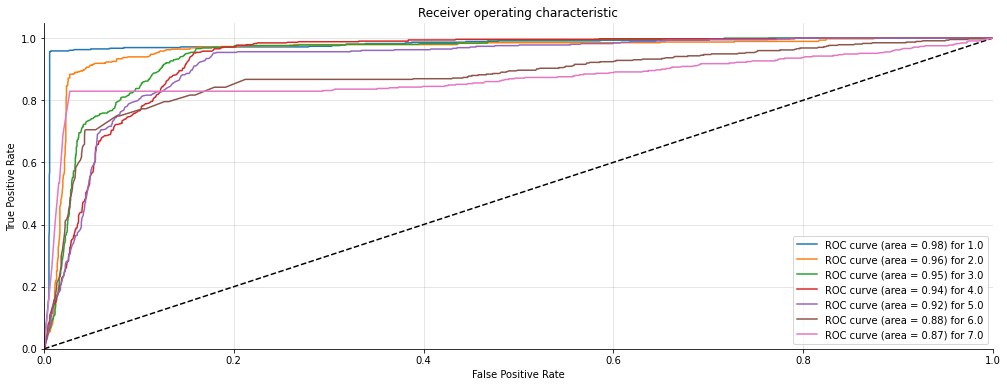

For column:  confusing<==>clear
[16:53:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       461
         2.0       0.84      0.87      0.86       488
         3.0       0.76      0.72      0.74       506
         4.0       0.67      0.69      0.68       516
         5.0       0.66      0.68      0.67       456
         6.0       0.73      0.72      0.73       471
         7.0       0.81      0.79      0.80       462

    accuracy                           0.77      3360
   macro avg       0.78      0.78      0.78      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  19   0   0   0   0   0]
 [  3 426

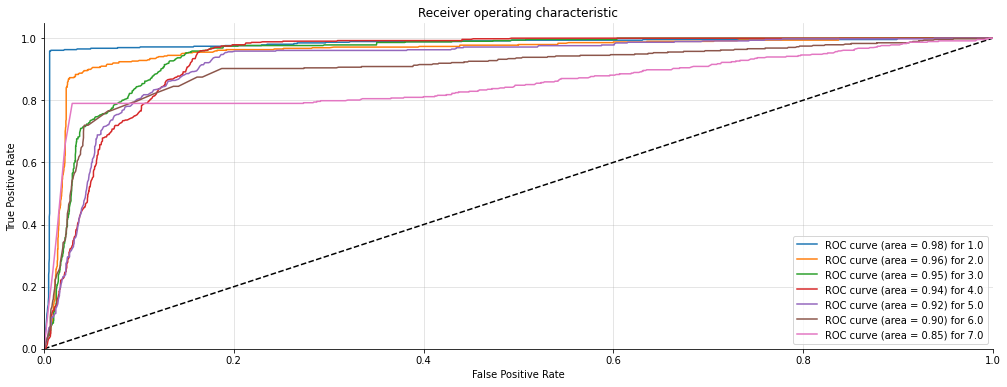

For column: boring<==>exciting
[16:53:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.87      0.88      0.88       491
         3.0       0.83      0.81      0.82       487
         4.0       0.86      0.86      0.86       518
         5.0       0.91      0.92      0.92       487
         6.0       0.96      0.96      0.96       462
         7.0       0.99      0.99      0.99       452

    accuracy                           0.91      3360
   macro avg       0.91      0.91      0.91      3360
weighted avg       0.91      0.91      0.91      3360

Confusion Matrix: 
 [[442  18   1   0   1   1   0]
 [  6 433 

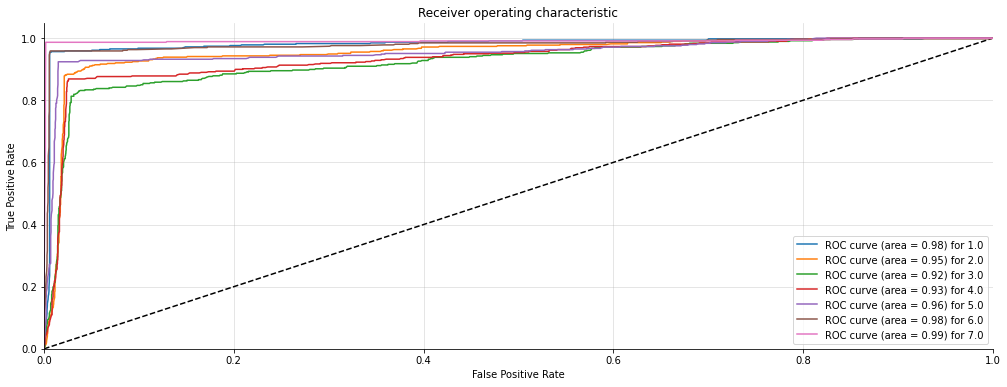

For column: not interesting<==>interesting
[16:53:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       461
         2.0       0.86      0.87      0.86       495
         3.0       0.81      0.79      0.80       490
         4.0       0.83      0.83      0.83       519
         5.0       0.88      0.91      0.90       481
         6.0       0.96      0.96      0.96       465
         7.0       0.99      0.99      0.99       449

    accuracy                           0.90      3360
   macro avg       0.90      0.90      0.90      3360
weighted avg       0.90      0.90      0.90      3360

Confusion Matrix: 
 [[442  18   1   0   0   0   0

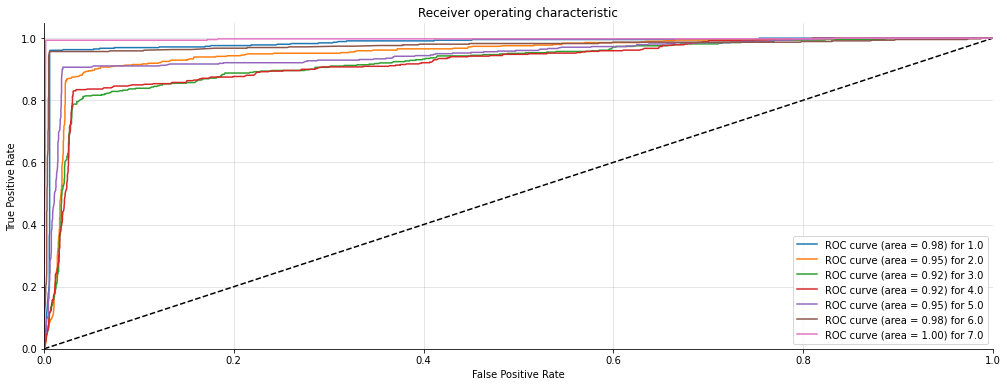

For column: conventional<==>inventive
[16:53:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       460
         2.0       0.97      0.95      0.96       502
         3.0       0.94      0.95      0.95       474
         4.0       0.95      0.94      0.95       527
         5.0       0.97      0.98      0.97       486
         6.0       0.98      0.99      0.99       459
         7.0       1.00      1.00      1.00       452

    accuracy                           0.97      3360
   macro avg       0.97      0.97      0.97      3360
weighted avg       0.97      0.97      0.97      3360

Confusion Matrix: 
 [[454   6   0   0   0   0   0]
 [ 

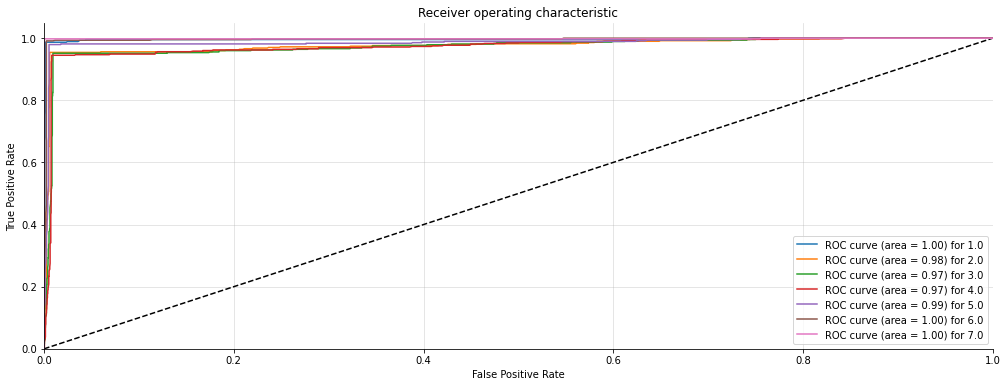

For column: usual<==>leading edge
[16:53:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       459
         2.0       1.00      1.00      1.00       496
         3.0       1.00      1.00      1.00       478
         4.0       1.00      1.00      1.00       523
         5.0       1.00      1.00      1.00       491
         6.0       1.00      1.00      1.00       462
         7.0       1.00      1.00      1.00       451

    accuracy                           1.00      3360
   macro avg       1.00      1.00      1.00      3360
weighted avg       1.00      1.00      1.00      3360

Confusion Matrix: 
 [[459   0   0   0   0   0   0]
 [  0 4

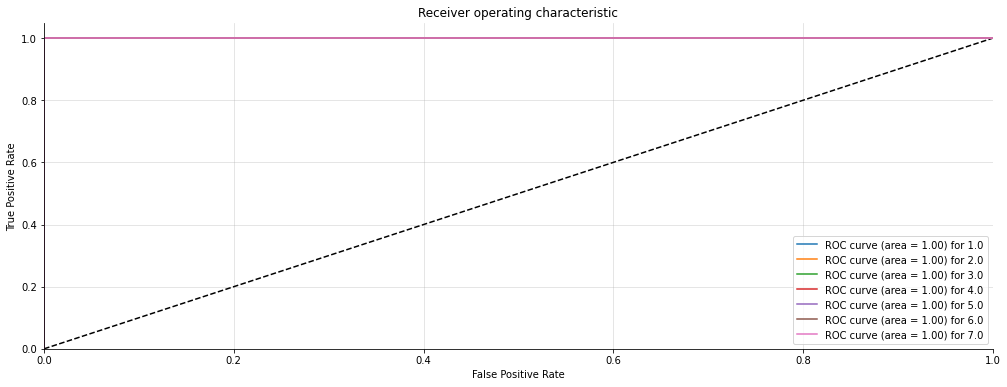

In [26]:
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
def XGBmodel(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    xgb_classifier = XGBClassifier()
    xgb_classifier.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in xgb_classifier.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    plot_multiclass_roc(xgb_classifier, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  XGBmodel(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

## 3.6. SVM Method

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.49      0.92      0.64       462
         2.0       0.60      0.59      0.59       482
         3.0       0.63      0.40      0.49       510
         4.0       0.61      0.41      0.49       517
         5.0       0.50      0.46      0.48       467
         6.0       0.62      0.59      0.61       470
         7.0       0.80      0.81      0.81       452

    accuracy                           0.59      3360
   macro avg       0.61      0.60      0.59      3360
weighted avg       0.61      0.59      0.58      3360

Confusion Matrix: 
 [[423  16   3   0   0  15   5]
 [122 285  34   9  16  16   0]
 [103  75 206  70  42  13   1]
 [ 78  42  42 212 126  14   3]
 [ 83  11  19  34 213 107   0]
 [ 37  30   9  10  20 279  85]
 [ 21  19  14  10  12   8 368]]
Accuracy Score : 0.5910714285714286
Precision Score : 0.605291465235969
Recall Score : 0.5910714285714286
F1 Score : 0.58216590

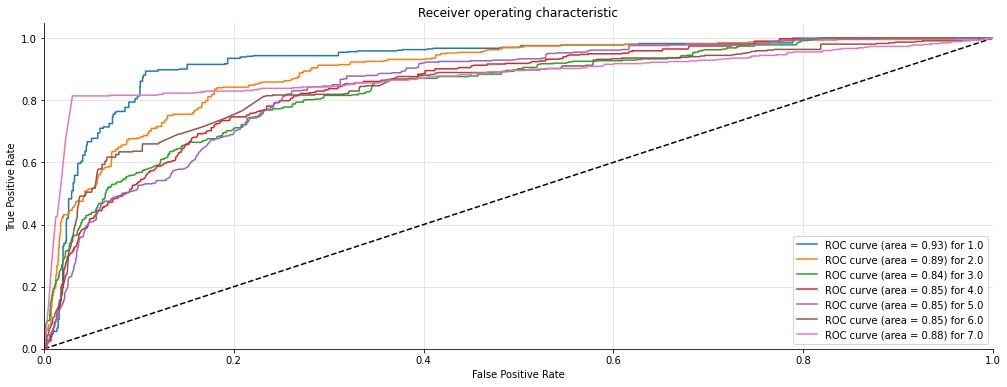

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.49      0.91      0.63       463
         2.0       0.59      0.58      0.59       485
         3.0       0.64      0.40      0.49       501
         4.0       0.65      0.44      0.53       515
         5.0       0.60      0.52      0.55       460
         6.0       0.69      0.71      0.70       484
         7.0       0.89      0.90      0.89       452

    accuracy                           0.63      3360
   macro avg       0.65      0.64      0.63      3360
weighted avg       0.65      0.63      0.62      3360

Confusion Matrix: 
 [[421  16   3   0   0  18   5]
 [126 282  34  11  14  18   0]
 [106  79 202  70  34   9   1]
 [ 80  40  44 227 100  21   3]
 [ 83  16  16  25 237  83   0]
 [ 34  32  13  12   6 343  44]
 [ 17  12   5   3   4   3 408]]
Accuracy Score : 0.6309523809523809
Precision Score : 0.64825888300634
Recall Score : 0.6309523809523809
F1 Score : 0.623204989494501

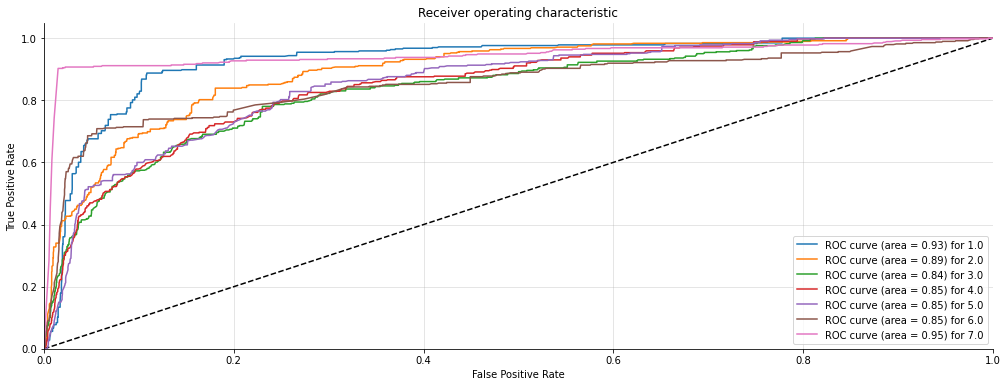

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.49      0.92      0.64       462
         2.0       0.60      0.60      0.60       482
         3.0       0.63      0.40      0.49       506
         4.0       0.62      0.40      0.49       526
         5.0       0.51      0.48      0.50       458
         6.0       0.62      0.59      0.60       475
         7.0       0.80      0.83      0.82       451

    accuracy                           0.59      3360
   macro avg       0.61      0.60      0.59      3360
weighted avg       0.61      0.59      0.59      3360

Confusion Matrix: 
 [[423  15   3   0   0  16   5]
 [119 289  34   9  14  17   0]
 [104  76 203  70  39  11   3]
 [ 81  43  47 211 126  14   4]
 [ 81  10   8  30 220 109   0]
 [ 39  31  18   9  21 278  79]
 [ 22  18  10  10  10   7 374]]
Accuracy Score : 0.5946428571428571
Precision Score : 0.6096732661531181
Recall Score : 0.5946428571428571
F1 Score : 0.58547560

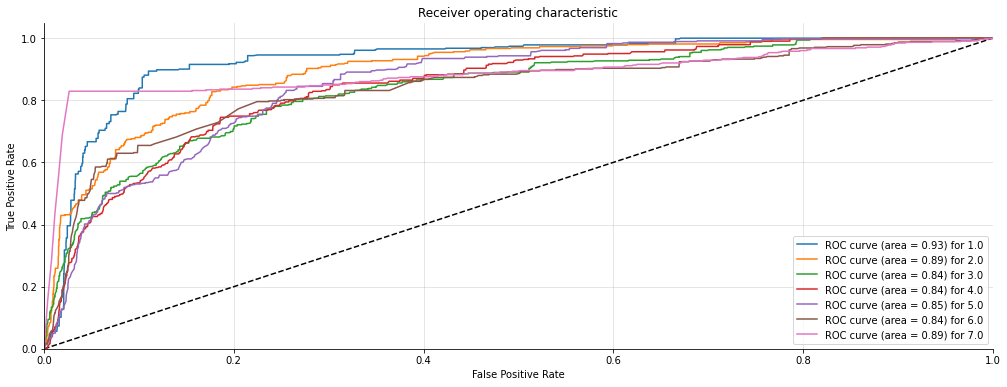

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.49      0.92      0.64       461
         2.0       0.60      0.59      0.59       488
         3.0       0.63      0.40      0.49       506
         4.0       0.62      0.39      0.48       516
         5.0       0.51      0.50      0.50       456
         6.0       0.61      0.59      0.60       471
         7.0       0.79      0.79      0.79       462

    accuracy                           0.59      3360
   macro avg       0.61      0.60      0.59      3360
weighted avg       0.61      0.59      0.58      3360

Confusion Matrix: 
 [[423  15   3   0   0  15   5]
 [124 287  35   5  21  16   0]
 [100  78 202  72  42  11   1]
 [ 76  40  44 203 128  22   3]
 [ 78   9  10  26 226 107   0]
 [ 38  28  11   7  21 280  86]
 [ 28  22  16  15   9   5 367]]
Accuracy Score : 0.5916666666666667
Precision Score : 0.6076908944242236
Recall Score : 0.5916666666666667
F1 Score : 0.5828985222270

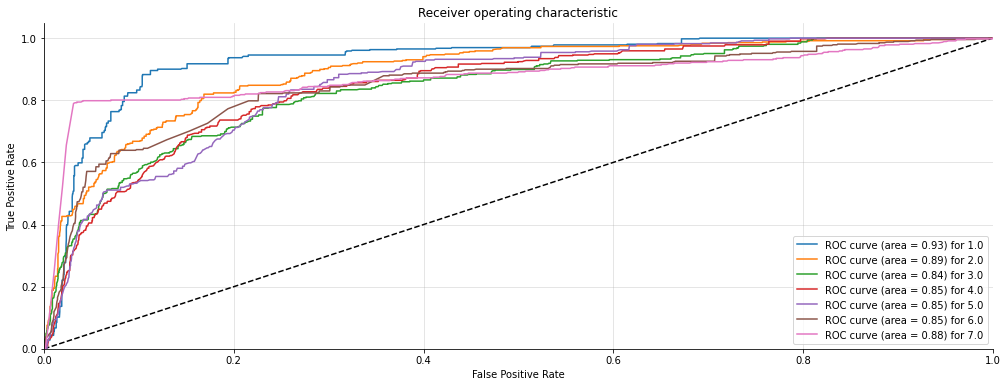

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.49      0.90      0.64       463
         2.0       0.59      0.56      0.58       491
         3.0       0.71      0.46      0.56       487
         4.0       0.79      0.53      0.63       518
         5.0       0.77      0.64      0.70       487
         6.0       0.77      0.86      0.81       462
         7.0       0.97      0.99      0.98       452

    accuracy                           0.70      3360
   macro avg       0.73      0.71      0.70      3360
weighted avg       0.73      0.70      0.70      3360

Confusion Matrix: 
 [[418  16   3   0   0  21   5]
 [134 275  37  12  14  19   0]
 [108  79 226  42  22  10   0]
 [ 69  58  32 275  51  27   6]
 [ 93  12  15  18 311  38   0]
 [ 26  25   3   2   3 398   5]
 [  0   0   1   1   1   3 446]]
Accuracy Score : 0.6991071428571428
Precision Score : 0.7268610127629245
Recall Score : 0.6991071428571428
F1 Score : 0.69571960727449

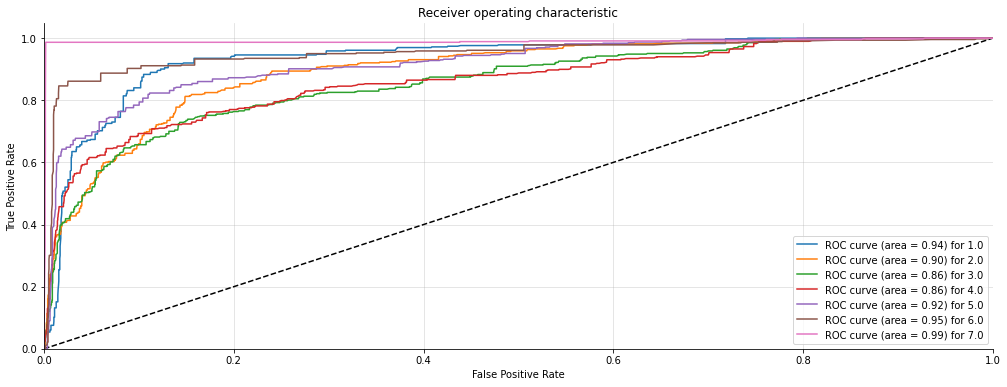

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.50      0.91      0.64       461
         2.0       0.61      0.58      0.60       495
         3.0       0.66      0.44      0.53       490
         4.0       0.76      0.50      0.60       519
         5.0       0.74      0.62      0.67       481
         6.0       0.77      0.86      0.81       465
         7.0       0.97      0.99      0.98       449

    accuracy                           0.69      3360
   macro avg       0.72      0.70      0.69      3360
weighted avg       0.71      0.69      0.69      3360

Confusion Matrix: 
 [[419  14   3   0   0  20   5]
 [126 286  37  10  15  21   0]
 [101  86 218  46  25  13   1]
 [ 75  46  49 260  58  26   5]
 [ 95  10  19  22 296  39   0]
 [ 26  24   3   2   6 399   5]
 [  0   0   1   1   0   1 446]]
Accuracy Score : 0.6916666666666667
Precision Score : 0.7141352624222518
Recall Score : 0.6916666666666667
F1 Score : 0.68

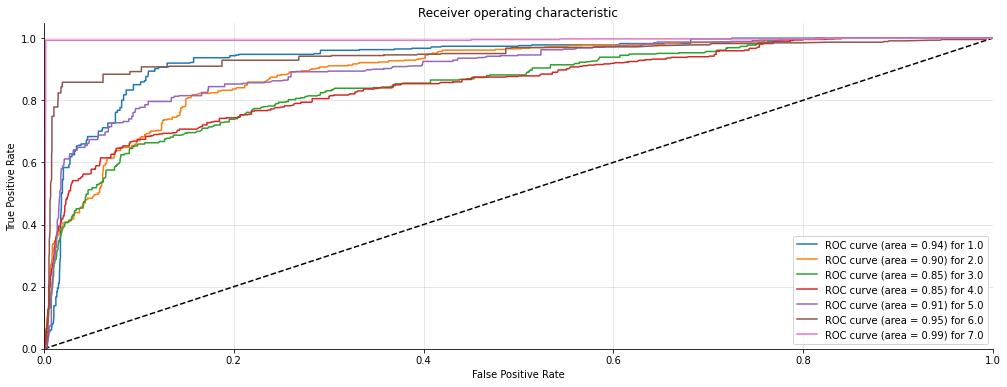

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.52      0.93      0.67       460
         2.0       0.69      0.61      0.65       502
         3.0       0.83      0.57      0.68       474
         4.0       0.85      0.61      0.71       527
         5.0       0.82      0.70      0.76       486
         6.0       0.79      0.89      0.84       459
         7.0       0.98      1.00      0.99       452

    accuracy                           0.75      3360
   macro avg       0.78      0.76      0.75      3360
weighted avg       0.78      0.75      0.75      3360

Confusion Matrix: 
 [[429   3   2   0   0  21   5]
 [128 306  17  16  15  19   1]
 [ 80  61 272  23  27  11   0]
 [ 68  45  35 319  29  27   4]
 [ 93   7   0  19 340  27   0]
 [ 27  21   0   0   3 408   0]
 [  0   0   0   0   0   1 451]]
Accuracy Score : 0.7514880952380952
Precision Score : 0.7836398109637089
Recall Score : 0.7514880952380952
F1 Score : 0.7515451

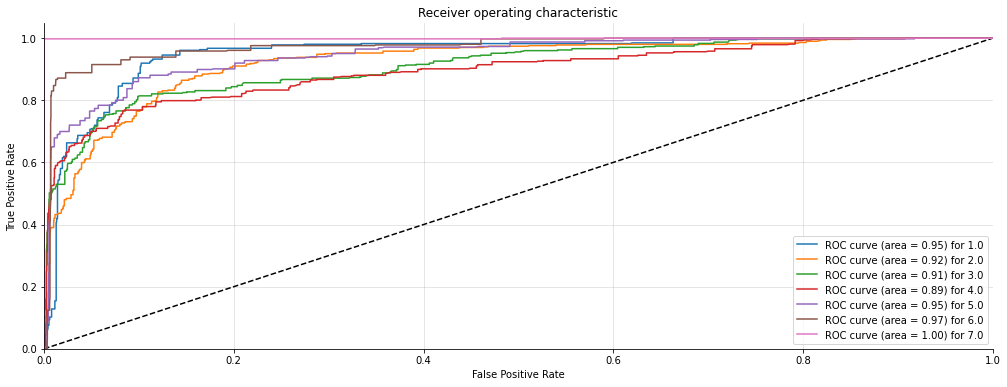

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       0.52      0.93      0.67       459
         2.0       0.70      0.65      0.68       496
         3.0       0.84      0.62      0.71       478
         4.0       0.92      0.64      0.75       523
         5.0       0.87      0.70      0.78       491
         6.0       0.82      0.90      0.86       462
         7.0       0.98      1.00      0.99       451

    accuracy                           0.77      3360
   macro avg       0.81      0.78      0.78      3360
weighted avg       0.81      0.77      0.77      3360

Confusion Matrix: 
 [[428   2   9   0   0  14   6]
 [127 324   7   8  12  18   0]
 [ 76  65 297  12  21   7   0]
 [ 64  44  36 334  19  22   4]
 [ 95   7   4  11 346  28   0]
 [ 26  21   0   0   0 415   0]
 [  0   0   0   0   0   0 451]]
Accuracy Score : 0.7723214285714286
Precision Score : 0.8086537198800327
Recall Score : 0.7723214285714286
F1 Score : 0.77488666776

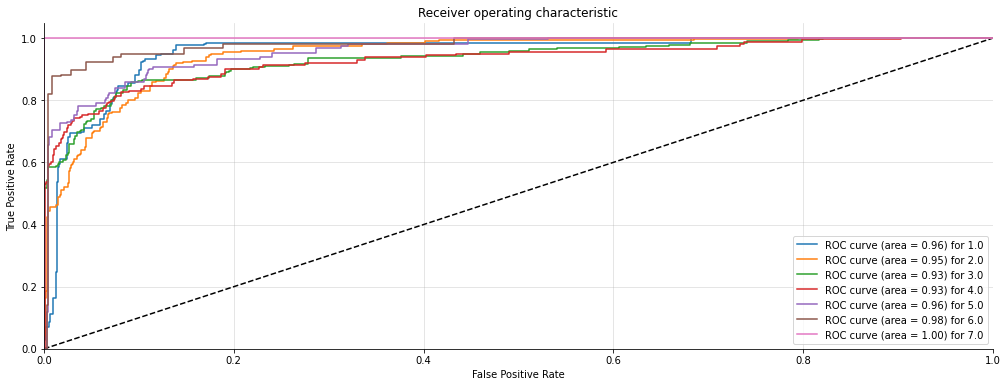

In [27]:
def SVMmodel(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    svc = SVC( probability=True)
    svc.fit(X_train, y_train)

    # predictions over test set
    predictions=[round(float(x)) for x in svc.predict(X_test)]
    print((classification_report(y_test, predictions)))

    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))

    plot_multiclass_roc(svc, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  SVMmodel(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

## 3.7. Custom-Built Ordinal Classifier

Credit: [Muhammad for Towards Data Science](https://towardsdatascience.com/simple-trick-to-train-an-ordinal-regression-with-any-classifier-6911183d2a3c)

Ordinal classifier basically does a similar thing to one-hot encoding -- but despite having one value each column, ordinal encoding maps unique binary values for each of our unique classes.

We implement a custom object called `OrdinalClassifier` built on top of any `sklearn` model that supports the `predict_proba()` function; ranging from Naive Bayes to decision trees.

Last implementation, we deduced the labels by one, from `[1,2,3,4,5,6,7]` to `[0,1,2,3,4,5,6]` due to the nature of zero-indexing of standard sklearn library. But this doesn't work if the labels aren't ranging fully from 1 to 7 -- could be 2 to 6 or 2 to 7 instead.

So the solution is to change the overall behavior of the `OrdinalClassifier` object to take maximum class (e.g. 7) and minimum class (e.g. 2 or 3) into consideration. From there, we simulate the `np.argmax()` function to be added the minimum class before being returned. We also add the minimum class as an index towards `self.clfs` dictionary when adding new value, so we don't need to deduce the labels by hand. In other words, labels stay as-is instead of being deduced by 1 :)

This also changes how the approach for ordinal encoding works -- instead of `k - 1` like the author's original implementation, we feed `k` numbers of encoding because our labels are already one-indexed.

Keep in mind that the `predict_proba()` function does not yet implement this change, because it's only a wrapper function before eventually calling `predict()` in which we care the most about the result. 

For column: obstructive<==>supportive
[16:59:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:36] WARNING: C:/Users/Adm

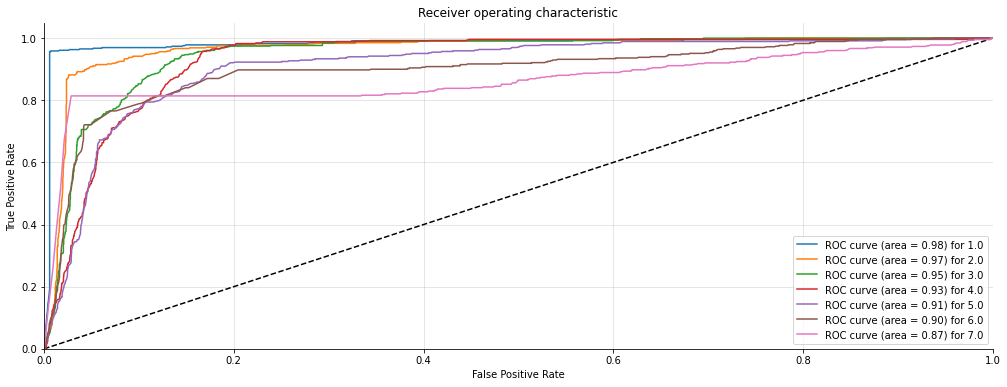

For column: complicated<==>easy
[16:59:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:39] WARNING: C:/Users/Administr

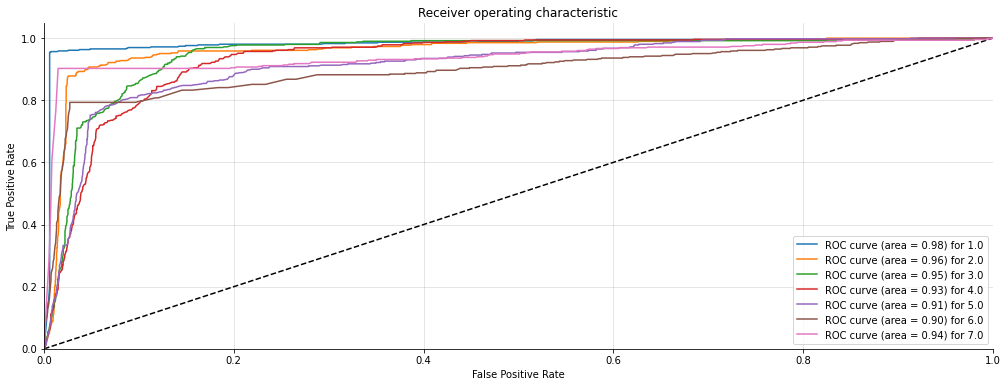

For column: inefficient<==>efficient
[16:59:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:41] WARNING: C:/Users/Admi

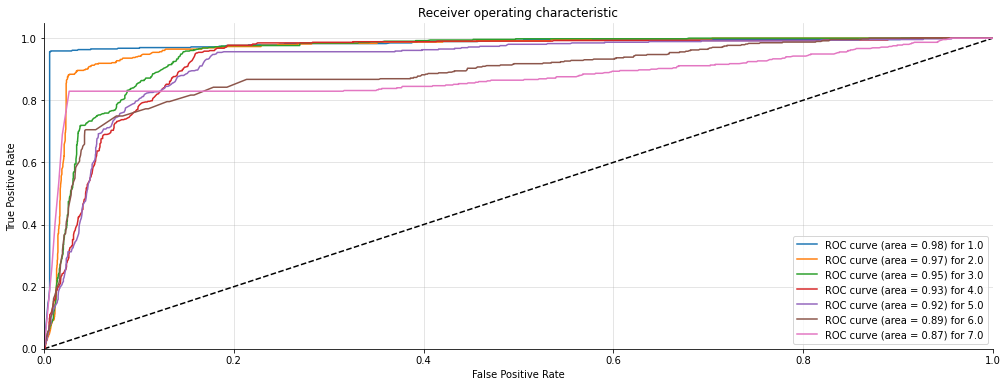

For column:  confusing<==>clear
[16:59:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:44] WARNING: C:/Users/Administr

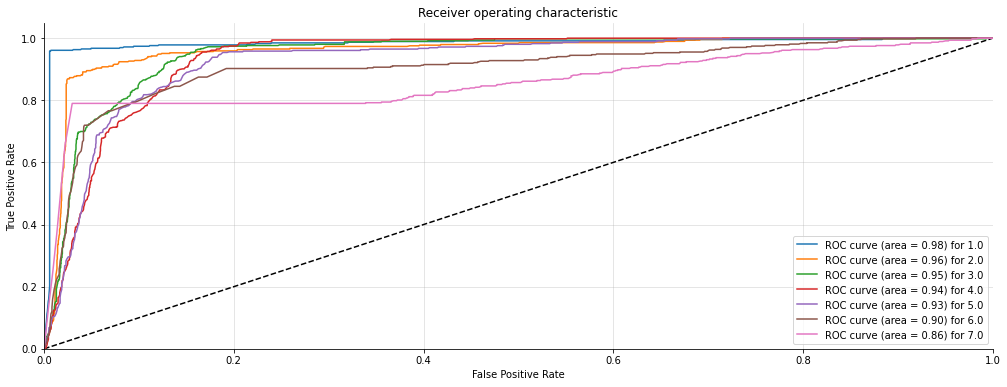

For column: boring<==>exciting
[16:59:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:47] WARNING: C:/Users/Administra

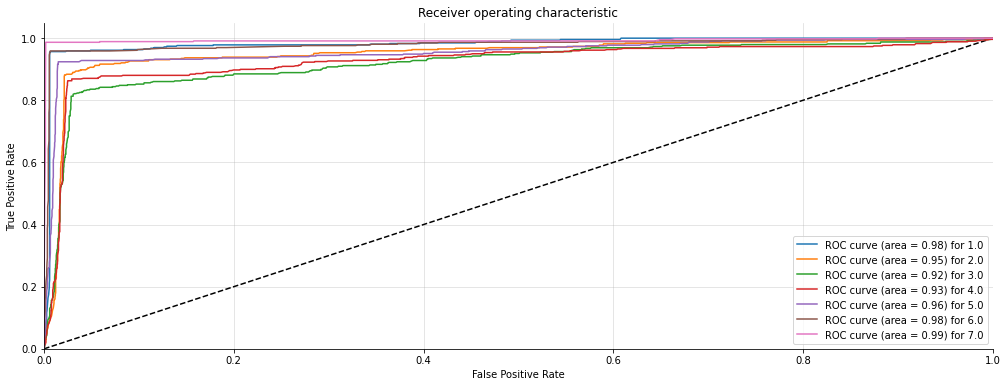

For column: not interesting<==>interesting
[16:59:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:50] WARNING: C:/User

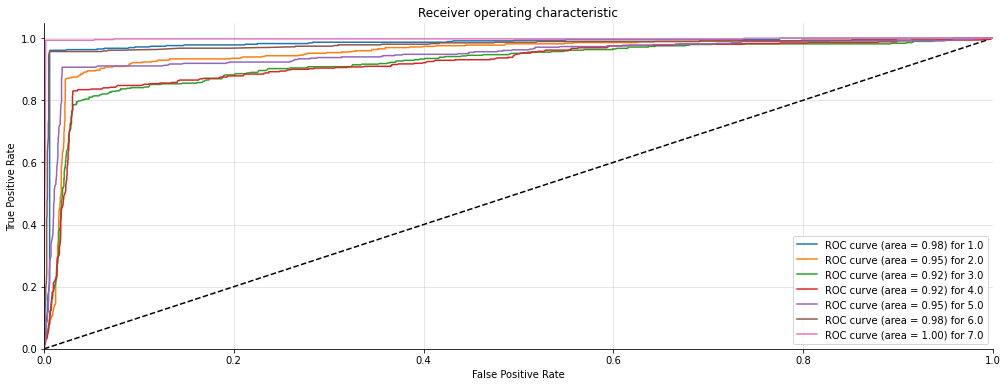

For column: conventional<==>inventive
[16:59:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:53] WARNING: C:/Users/Adm

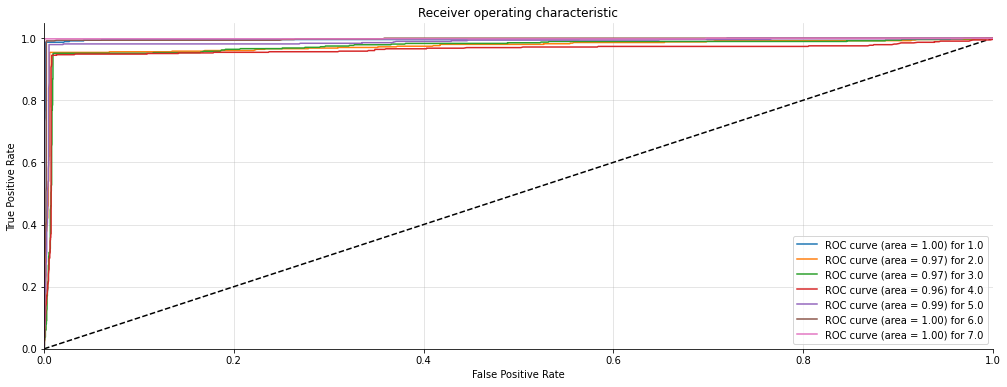

For column: usual<==>leading edge
[16:59:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:56] WARNING: C:/Users/Adminis

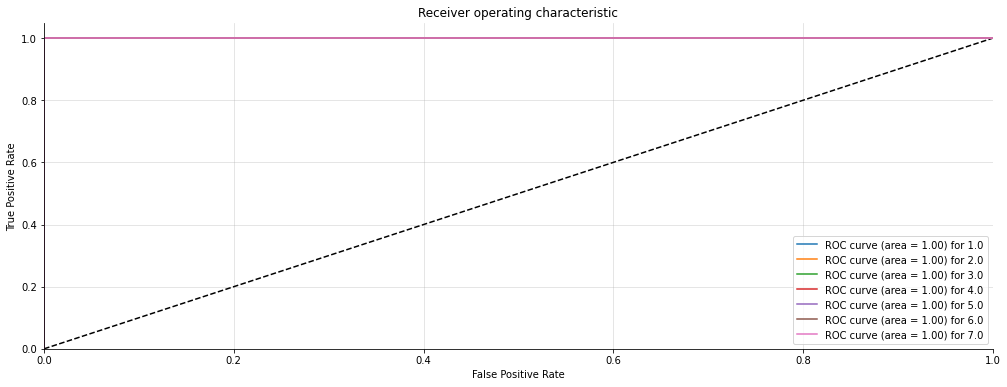

In [28]:
from sklearn.base import clone


class OrdinalClassifier():
    
    def __init__(self, clf):
        self.clf = clf
        self.clfs = {}
    
    def fit(self, X, y):
        self.unique_class = np.sort(np.unique(y))
        self.max_class = max(self.unique_class)
        self.min_class = min(self.unique_class)
        if self.unique_class.shape[0] > 2:
            # print(self.unique_class.shape[0]) # Uncomment to debug
            for i in range(self.unique_class.shape[0]):
                # for each k ordinal value we fit a binary classification problem
                binary_y = (y > self.unique_class[i]).astype(np.uint8)
                clf = clone(self.clf)
                
                
                clf.fit(X, binary_y)
                self.clfs[i + self.min_class] = clf
    
    def predict_proba(self, X):
        clfs_predict = {k:self.clfs[k].predict_proba(X) for k in self.clfs}
        # print(self.clfs) # Uncomment to debug
        predicted = []
        for i,y in enumerate(self.unique_class):
            if i == 0:
                # V1 = 1 - Pr(y > V1)
                predicted.append(1 - clfs_predict[y][:,1])
            elif y in clfs_predict:
                # Vi = Pr(y > Vi-1) - Pr(y > Vi)
                 predicted.append(clfs_predict[y-1][:,1] - clfs_predict[y][:,1])
            else:
                # Vk = Pr(y > Vk-1)
                predicted.append(clfs_predict[y-1][:,1])
        return np.vstack(predicted).T
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1) + self.min_class

def OrdinalModel(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    clf = OrdinalClassifier(XGBClassifier()) # Using XGB as the placeholder model 
    clf.fit(X_train, y_train)

    # predictions over test set
    predictions = clf.predict(X_test)
    print((classification_report(y_test, predictions)))

    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))

    plot_multiclass_roc(clf, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  OrdinalModel(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))
  #break # Uncomment to debug

# 4. Other Deep Learning Model(s)

## 4.1. Bidirectional LSTM

In [29]:
## Callbacks
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
  "model_checkpoints", monitor="val_loss", verbose=1, save_best_only=True, mode="min")

## Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

LSTM_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(2000, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(64, activation='relu', 
                          
                          # Prevent overfitting
                          kernel_regularizer=tf.keras.regularizers.L2(l2=0.01), 

                          # Ensuring consistent outputs and not run into potential local optima
                          # Avoid initializing standard normal (mean = 0, std = 1) to reach faster convergence and less initial loss.
                          kernel_initializer=tf.keras.initializers.RandomNormal(seed=42)
                          
                          ),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(8, activation='linear')
])
LSTM_model.summary()

LSTM_model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer= opt, metrics=['mae'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          128000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 520       
Total params: 202,824
Trainable params: 202,824
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = LSTM_model.fit(X_train, y_train, epochs=100, batch_size = 512, validation_split=0.2, 
                    callbacks = [es], # Call checkpoint variable if neccessary
                    verbose=1)

Epoch 1/100
21/21 [==============================] - 4s 111ms/step - loss: 17.3786 - mae: 3.6129 - val_loss: 6.9256 - val_mae: 2.1382
Epoch 2/100
21/21 [==============================] - 2s 83ms/step - loss: 5.9656 - mae: 1.9973 - val_loss: 4.1065 - val_mae: 1.7242
Epoch 3/100
21/21 [==============================] - 2s 86ms/step - loss: 4.8817 - mae: 1.8327 - val_loss: 3.5179 - val_mae: 1.5868
Epoch 4/100
21/21 [==============================] - 2s 78ms/step - loss: 3.7463 - mae: 1.5529 - val_loss: 1.9785 - val_mae: 1.0942
Epoch 5/100
21/21 [==============================] - 2s 76ms/step - loss: 2.2927 - mae: 1.1546 - val_loss: 1.2312 - val_mae: 0.8155
Epoch 6/100
21/21 [==============================] - 2s 75ms/step - loss: 1.8378 - mae: 1.0103 - val_loss: 1.0594 - val_mae: 0.7190
Epoch 7/100
21/21 [==============================] - 2s 75ms/step - loss: 1.6246 - mae: 0.9252 - val_loss: 0.8861 - val_mae: 0.5940
Epoch 8/100
21/21 [==============================] - 2s 74ms/step - loss: 

### 4.1.1. Interpretation

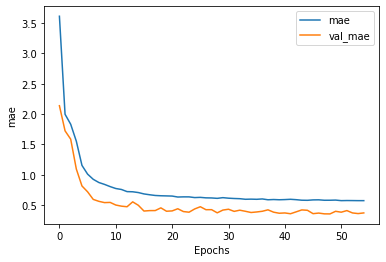

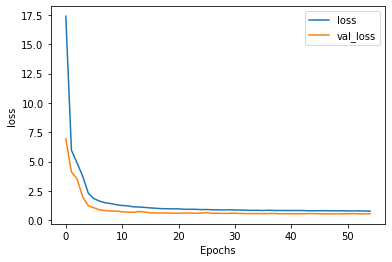

In [31]:
plot_graphs(history, "mae")
plot_graphs(history, "loss")

In [32]:
scores = LSTM_model.evaluate(
    X_test, y_test, batch_size=1, verbose=1, sample_weight=None, steps=None,
    callbacks=None, max_queue_size=10, workers=4, use_multiprocessing=False,
    return_dict=False
)
print("------------------ EVALUATION FINISHED! ------------------".center(115))
for i in range(len(scores)):
    print("%s: %.2f%%" % (model.metrics_names[i], scores[i]*100))

3360/3360 [==============================] - 9s 3ms/step - loss: 0.5464 - mae: 0.3747
                             ------------------ EVALUATION FINISHED! ------------------                            
loss: 54.64%
mae: 37.47%


In [33]:
LSTM_y_pred = LSTM_model.predict(X_test)
LSTM_y_pred_flattened = LSTM_y_pred.flatten(order='F')
LSTM_y_classified = [round(float(x)) for x in LSTM_y_pred_flattened]

print("First ten examples of the test set:")
print("Truth labels:", y_test_flattened[:10])
print("Predicted labels:",LSTM_y_classified[:10])
print("Overall performance on all columns:\n", classification_report(y_test_flattened, LSTM_y_classified))

First ten examples of the test set:
Truth labels: [2. 1. 2. 1. 4. 3. 4. 3. 3. 7.]
Predicted labels: [2, 1, 2, 1, 5, 4, 4, 3, 4, 1]
Overall performance on all columns:
               precision    recall  f1-score   support

         1.0       0.94      0.95      0.95      3691
         2.0       0.84      0.75      0.79      3921
         3.0       0.72      0.72      0.72      3952
         4.0       0.73      0.80      0.76      4161
         5.0       0.79      0.80      0.79      3786
         6.0       0.87      0.85      0.86      3748
         7.0       0.92      0.91      0.92      3621

    accuracy                           0.82     26880
   macro avg       0.83      0.83      0.83     26880
weighted avg       0.83      0.82      0.82     26880



## 4.2. BERT [deprecated]

In [34]:
"""!pip install -q -U tensorflow-text
!pip install -q tf-models-official
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

to_handle = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1'
to_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
bert_model = hub.KerasLayer(to_preprocess)

text_test = ['this is such an amazing movie!']
text_preprocessed = bert_model(text_test)

def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(to_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(to_handle, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

classifier_model = build_classifier_model()
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
print(f'Training model with {to_handle}')
history = classifier_model.fit(X_train, y_train)"""

"!pip install -q -U tensorflow-text\n!pip install -q tf-models-official\nimport tensorflow_hub as hub\nimport tensorflow_text as text\nfrom official.nlp import optimization  # to create AdamW optimizer\n\nto_handle = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1'\nto_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'\nbert_model = hub.KerasLayer(to_preprocess)\n\ntext_test = ['this is such an amazing movie!']\ntext_preprocessed = bert_model(text_test)\n\ndef build_classifier_model():\n  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')\n  preprocessing_layer = hub.KerasLayer(to_preprocess, name='preprocessing')\n  encoder_inputs = preprocessing_layer(text_input)\n  encoder = hub.KerasLayer(to_handle, trainable=True, name='BERT_encoder')\n  outputs = encoder(encoder_inputs)\n  net = outputs['pooled_output']\n  net = tf.keras.layers.Dropout(0.1)(net)\n  net = tf.keras.layers.Dense(1, activation=None, name='classifi

# RBFN

In [35]:

from keras import backend as K
from tensorflow.keras.layers import Layer, InputSpec
from keras.initializers import RandomUniform, Initializer, Constant
import numpy as np

In [36]:
class InitCentersRandom(Initializer):
    """ Initializer for initialization of centers of RBF network
        as random samples from the given data set.
    # Arguments
        X: matrix, dataset to choose the centers from (random rows
          are taken as centers)
    """

    def __init__(self, X):
        self.X = X

    def __call__(self, shape, dtype=None):
        assert shape[1] == self.X.shape[1]
        print("done")
        idx = np.random.randint(self.X.shape[0], size=shape[0])
        return self.X[idx, :]


class RBFLayer(Layer):
    """ Layer of Gaussian RBF units.
    # Example
    ```python
        model = Sequential()
        model.add(RBFLayer(10,
                           initializer=InitCentersRandom(X),
                           betas=1.0,
                           input_shape=(1,)))
        model.add(Dense(1))
    ```
    # Arguments
        output_dim: number of hidden units (i.e. number of outputs of the
                    layer)
        initializer: instance of initiliazer to initialize centers
        betas: float, initial value for betas
    """

    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):
        self.output_dim = output_dim
        self.init_betas = betas
        if not initializer:
            self.initializer = RandomUniform(0.0, 1.0)
        else:
            self.initializer = initializer
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):

        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=Constant(
                                         value=self.init_betas),
                                     # initializer='ones',
                                     trainable=True)

        super(RBFLayer, self).build(input_shape)

    def call(self, x):

        C = K.expand_dims(self.centers)
        H = K.transpose(C-K.transpose(x))
        return K.exp(-self.betas * K.sum(H**2, axis=1))

        # C = self.centers[np.newaxis, :, :]
        # X = x[:, np.newaxis, :]

        # diffnorm = K.sum((C-X)**2, axis=-1)
        # ret = K.exp( - self.betas * diffnorm)
        # return ret

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

from keras.initializers import Initializer
from sklearn.cluster import KMeans


class InitCentersKMeans(Initializer):
    """ Initializer for initialization of centers of RBF network
        by clustering the given data set.
    # Arguments
        X: matrix, dataset
    """

    def __init__(self, X, max_iter=100):
        self.X = X
        self.max_iter = max_iter

    def __call__(self, shape, dtype=None):
        assert shape[1] == self.X.shape[1]

        n_centers = shape[0]
        km = KMeans(n_clusters=n_centers, max_iter=self.max_iter, verbose=0)
        km.fit(self.X)
        return km.cluster_centers_


In [37]:
import numpy as np, pandas as pd
from keras.models import Sequential 
from keras.layers.core import Dense
from keras.layers import Activation
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt

In [38]:
model = Sequential()
rbflayer = RBFLayer(100,
                        initializer=InitCentersKMeans(X_train),
                        betas=3.0,
                        input_shape=(X_train.shape[1],))
model.add(rbflayer)
model.add(Dense(8))
model.add(Activation('linear'))
model.compile(loss='mean_squared_error',
                  optimizer='adam', metrics=['accuracy'])
model.build(X_train.shape)
print(model.summary())
history1 = model.fit(X_train, y_train, epochs=100)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (13440, 100)              2100      
_________________________________________________________________
dense (Dense)                (13440, 8)                808       
_________________________________________________________________
activation (Activation)      (13440, 8)                0         
Total params: 2,908
Trainable params: 2,908
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
420/420 [==============================] - 15s 2ms/step - loss: 19.4319 - accuracy: 0.2287
Epoch 2/100
420/420 [==============================] - 1s 2ms/step - loss: 16.3813 - accuracy: 0.0404
Epoch 3/100
420/420 [==============================] - 1s 2ms/step - loss: 13.6450 - accuracy: 0.0123
Epoch 4/100
420/420 [==============================] - 1s 2ms/step - los

420/420 [==============================] - 1s 2ms/step - loss: 3.9121 - accuracy: 0.7430
Epoch 68/100
420/420 [==============================] - 1s 2ms/step - loss: 3.9852 - accuracy: 0.4494
Epoch 69/100
420/420 [==============================] - 1s 2ms/step - loss: 3.9838 - accuracy: 0.0881
Epoch 70/100
420/420 [==============================] - 1s 2ms/step - loss: 4.0204 - accuracy: 0.3448
Epoch 71/100
420/420 [==============================] - 1s 2ms/step - loss: 3.9896 - accuracy: 0.0552
Epoch 72/100
420/420 [==============================] - 1s 2ms/step - loss: 4.0340 - accuracy: 0.1386
Epoch 73/100
420/420 [==============================] - 1s 2ms/step - loss: 3.9640 - accuracy: 0.4060
Epoch 74/100
420/420 [==============================] - 1s 2ms/step - loss: 4.0050 - accuracy: 0.0396
Epoch 75/100
420/420 [==============================] - 1s 2ms/step - loss: 3.9645 - accuracy: 0.5243
Epoch 76/100
420/420 [==============================] - 1s 2ms/step - loss: 4.0005 - accuracy: 

In [39]:
y_train.shape

(13440, 8)

In [40]:
LSTM_y_pred = model.predict(X_test)
LSTM_y_pred_flattened = LSTM_y_pred.flatten(order='F')
LSTM_y_classified = [round(float(x)) for x in LSTM_y_pred_flattened]

print("First ten examples of the test set:")
print("Truth labels:", y_test[:10])
print("Predicted labels:",LSTM_y_classified[:10])
print("Overall performance on all columns:\n", classification_report(y_test.flatten(order='F'), LSTM_y_classified))

First ten examples of the test set:
Truth labels: [[2. 2. 2. 2. 2. 2. 2. 2.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [2. 2. 2. 2. 2. 2. 2. 2.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [4. 4. 4. 4. 5. 5. 5. 5.]
 [3. 3. 3. 3. 3. 3. 4. 4.]
 [4. 4. 4. 4. 4. 4. 4. 4.]
 [3. 3. 3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3. 4. 4.]
 [7. 7. 7. 7. 2. 2. 1. 1.]]
Predicted labels: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
Overall performance on all columns:
               precision    recall  f1-score   support

         1.0       0.00      0.00      0.00      3691
         2.0       0.00      0.00      0.00      3921
         3.0       0.82      0.01      0.02      3952
         4.0       0.16      1.00      0.27      4161
         5.0       0.82      0.03      0.06      3786
         6.0       0.86      0.04      0.08      3748
         7.0       0.00      0.00      0.00      3621

    accuracy                           0.17     26880
   macro avg       0.38      0.15      0.06     26880
weighted avg       0.38      0.17      0.07     268

In [41]:
from sklearn.metrics import classification_report

In [42]:
X_test.shape

(3360, 20)

In [43]:
y_test.shape

(3360, 8)

# Multiclass Logistic regression

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.23      0.54      0.32       462
         2.0       0.25      0.15      0.18       482
         3.0       0.22      0.10      0.14       510
         4.0       0.26      0.20      0.23       517
         5.0       0.25      0.12      0.16       467
         6.0       0.20      0.15      0.17       470
         7.0       0.49      0.85      0.62       452

    accuracy                           0.29      3360
   macro avg       0.27      0.30      0.26      3360
weighted avg       0.27      0.29      0.26      3360

Confusion Matrix: 
 [[248  26  25  24  27  54  58]
 [166  70  37  50  37  59  63]
 [159  66  52  81  28  59  65]
 [159  41  63 103  41  53  57]
 [173  38  31  85  55  51  34]
 [154  31  21  47  28  72 117]
 [ 27   9   9   8   6  11 382]]
Accuracy Score : 0.2922619047619048
Precision Score : 0.2688286255732977
Recall Score : 0.2922619047619048
F1 Score : 0.2563052

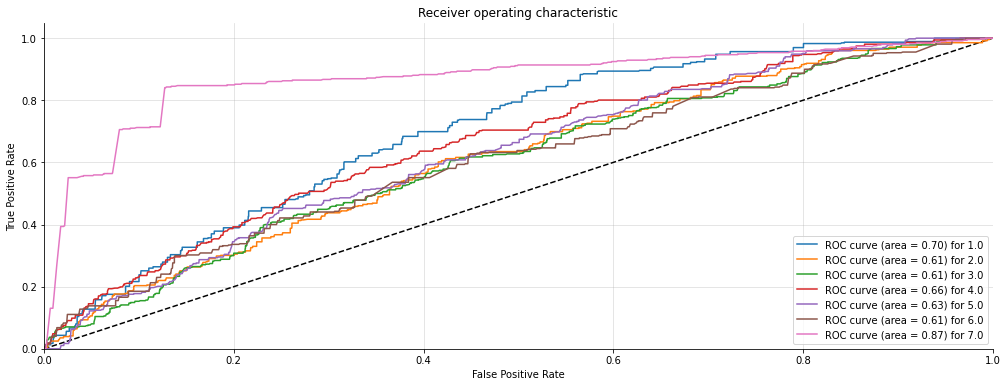

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.27      0.22      0.24       463
         2.0       0.22      0.16      0.19       485
         3.0       0.21      0.16      0.18       501
         4.0       0.24      0.26      0.25       515
         5.0       0.18      0.12      0.15       460
         6.0       0.27      0.33      0.30       484
         7.0       0.53      0.92      0.67       452

    accuracy                           0.31      3360
   macro avg       0.27      0.31      0.28      3360
weighted avg       0.27      0.31      0.28      3360

Confusion Matrix: 
 [[102  41  42  66  48  93  71]
 [ 64  79  64  79  57  82  60]
 [ 41  67  78 107  41 108  59]
 [ 49  64  75 133  63  75  56]
 [ 55  65  61 116  57  78  28]
 [ 56  43  39  49  41 162  94]
 [  5   4   4  10   5   9 415]]
Accuracy Score : 0.3053571428571429
Precision Score : 0.2723944005173537
Recall Score : 0.3053571428571429
F1 Score : 0.2788123177576

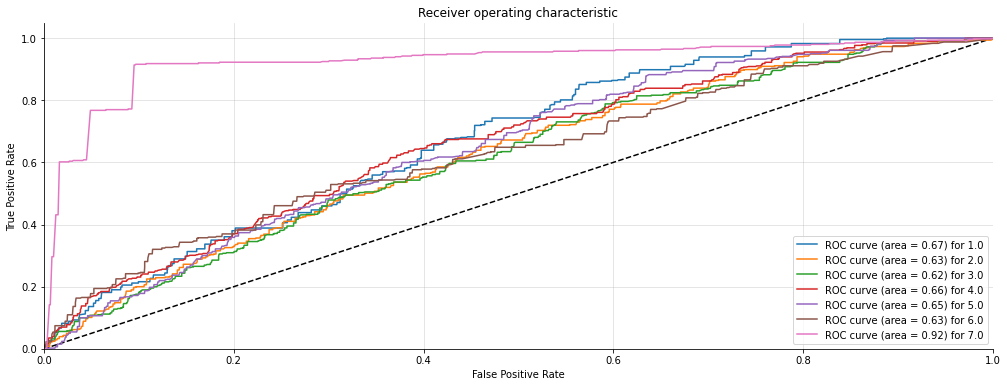

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.22      0.51      0.31       462
         2.0       0.20      0.12      0.15       482
         3.0       0.21      0.11      0.15       506
         4.0       0.28      0.19      0.22       526
         5.0       0.21      0.10      0.13       458
         6.0       0.22      0.17      0.19       475
         7.0       0.48      0.85      0.62       451

    accuracy                           0.29      3360
   macro avg       0.26      0.29      0.25      3360
weighted avg       0.26      0.29      0.25      3360

Confusion Matrix: 
 [[236  31  28  17  30  62  58]
 [160  59  40  56  34  60  73]
 [149  66  57  70  28  65  71]
 [156  52  72  98  41  50  57]
 [169  45  50  66  45  48  35]
 [161  31  18  42  27  81 115]
 [ 28   9   8   5   7   9 385]]
Accuracy Score : 0.28601190476190474
Precision Score : 0.25886326150078404
Recall Score : 0.28601190476190474
F1 Score : 0.24968

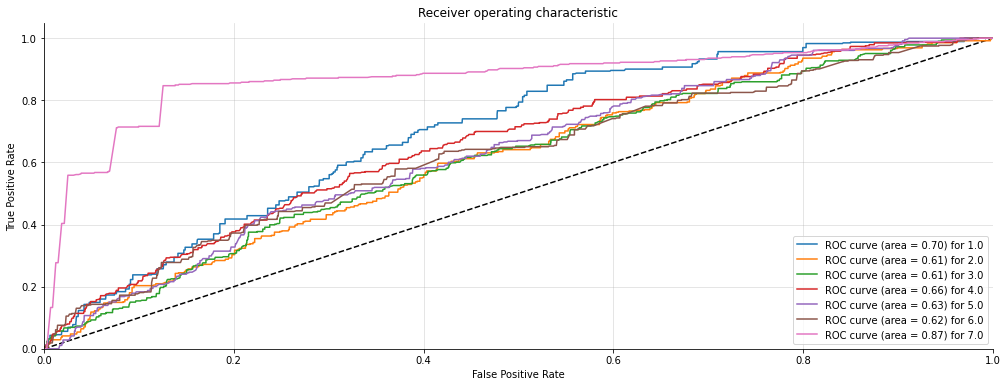

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.22      0.51      0.31       461
         2.0       0.22      0.13      0.16       488
         3.0       0.22      0.11      0.15       506
         4.0       0.27      0.18      0.22       516
         5.0       0.23      0.11      0.15       456
         6.0       0.22      0.17      0.19       471
         7.0       0.47      0.81      0.60       462

    accuracy                           0.29      3360
   macro avg       0.26      0.29      0.25      3360
weighted avg       0.26      0.29      0.25      3360

Confusion Matrix: 
 [[236  33  27  22  27  52  64]
 [168  65  43  44  38  55  75]
 [149  69  57  70  30  66  65]
 [159  48  66  93  48  48  54]
 [167  41  44  68  52  48  36]
 [153  34  15  40  27  81 121]
 [ 36  12   8  10   7  14 375]]
Accuracy Score : 0.28541666666666665
Precision Score : 0.26303179534381194
Recall Score : 0.28541666666666665
F1 Score : 0.2519346083

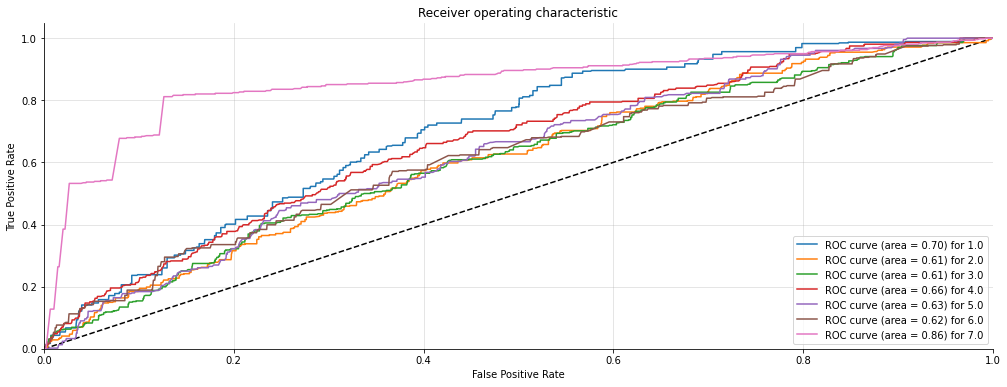

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.34      0.22      0.27       463
         2.0       0.26      0.17      0.20       491
         3.0       0.21      0.15      0.18       487
         4.0       0.22      0.19      0.20       518
         5.0       0.26      0.27      0.26       487
         6.0       0.31      0.51      0.39       462
         7.0       0.67      0.99      0.80       452

    accuracy                           0.35      3360
   macro avg       0.32      0.36      0.33      3360
weighted avg       0.32      0.35      0.32      3360

Confusion Matrix: 
 [[101  38  44  69  68  86  57]
 [ 49  82  66  78  71 104  41]
 [ 31  53  75  86 101 109  32]
 [ 34  56  71  99 105 124  29]
 [ 35  56  80  73 132  88  23]
 [ 42  32  25  49  40 234  40]
 [  1   1   0   1   0   2 447]]
Accuracy Score : 0.3482142857142857
Precision Score : 0.31880000262536773
Recall Score : 0.3482142857142857
F1 Score : 0.3220733045697

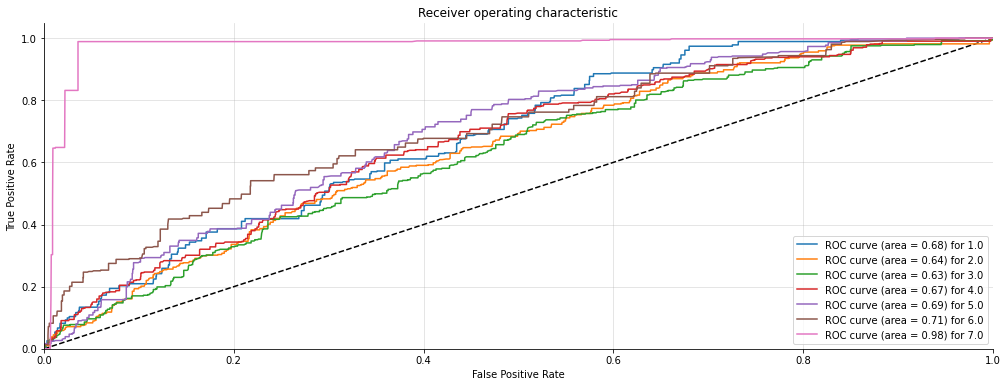

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.30      0.20      0.24       461
         2.0       0.22      0.13      0.17       495
         3.0       0.21      0.16      0.18       490
         4.0       0.24      0.20      0.22       519
         5.0       0.26      0.29      0.27       481
         6.0       0.30      0.48      0.37       465
         7.0       0.66      1.00      0.79       449

    accuracy                           0.34      3360
   macro avg       0.31      0.35      0.32      3360
weighted avg       0.31      0.34      0.31      3360

Confusion Matrix: 
 [[ 90  33  41  65  87  89  56]
 [ 58  65  69  84  74 101  44]
 [ 32  47  77  77 103 121  33]
 [ 34  49  80 106 103 111  36]
 [ 40  56  68  60 140  97  20]
 [ 48  39  32  44  36 225  41]
 [  1   0   0   0   0   1 447]]
Accuracy Score : 0.34226190476190477
Precision Score : 0.3089757933880681
Recall Score : 0.34226190476190477
F1 Score : 0.

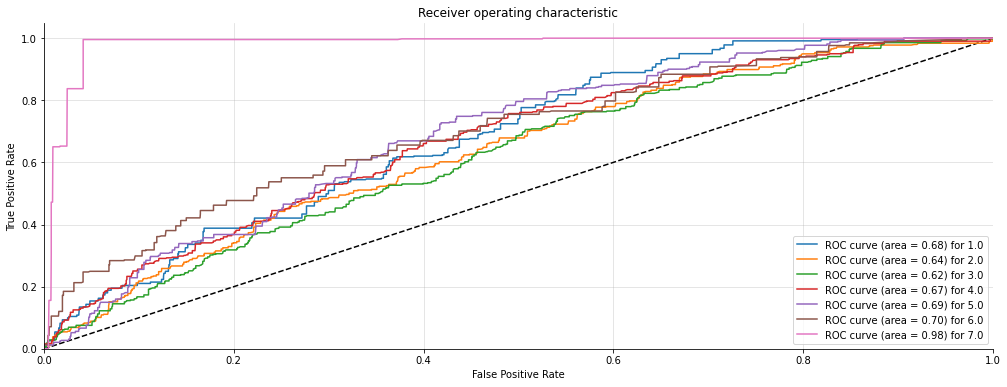

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.31      0.19      0.24       460
         2.0       0.22      0.15      0.18       502
         3.0       0.21      0.18      0.19       474
         4.0       0.23      0.18      0.20       527
         5.0       0.26      0.29      0.27       486
         6.0       0.29      0.47      0.36       459
         7.0       0.70      1.00      0.82       452

    accuracy                           0.34      3360
   macro avg       0.32      0.35      0.32      3360
weighted avg       0.31      0.34      0.32      3360

Confusion Matrix: 
 [[ 88  49  53  59  71  87  53]
 [ 53  75  69  82  82 103  38]
 [ 25  58  84  71  94 113  29]
 [ 29  62  71  94 125 122  24]
 [ 38  57  70  60 139  97  25]
 [ 49  41  52  48  26 216  27]
 [  0   0   0   1   0   0 451]]
Accuracy Score : 0.3413690476190476
Precision Score : 0.3119062369154085
Recall Score : 0.3413690476190476
F1 Score : 0.3164949

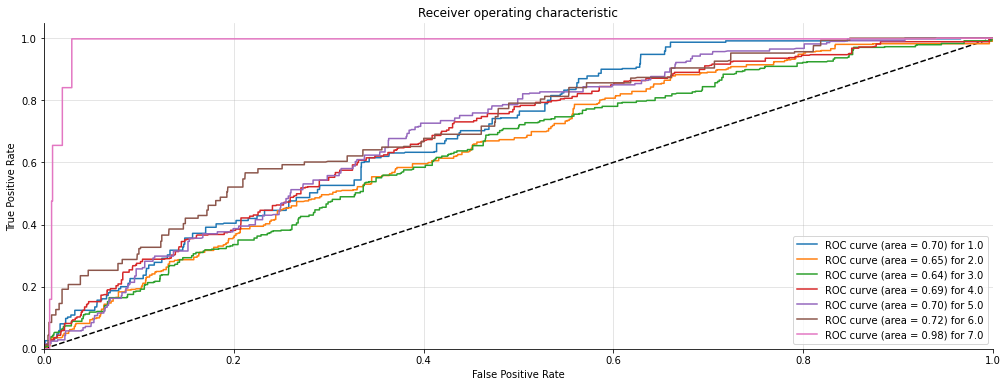

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       0.33      0.19      0.24       459
         2.0       0.23      0.18      0.20       496
         3.0       0.22      0.19      0.20       478
         4.0       0.23      0.20      0.21       523
         5.0       0.27      0.29      0.28       491
         6.0       0.29      0.44      0.35       462
         7.0       0.72      1.00      0.84       451

    accuracy                           0.35      3360
   macro avg       0.33      0.35      0.33      3360
weighted avg       0.32      0.35      0.33      3360

Confusion Matrix: 
 [[ 87  53  51  63  77  81  47]
 [ 46  89  69  82  76  98  36]
 [ 21  59  90  72  97 113  26]
 [ 25  73  71 103 117 112  22]
 [ 34  70  69  64 143  95  16]
 [ 50  40  60  57  25 202  28]
 [  0   0   0   0   0   0 451]]
Accuracy Score : 0.34672619047619047
Precision Score : 0.32237035240092726
Recall Score : 0.34672619047619047
F1 Score : 0.32579520

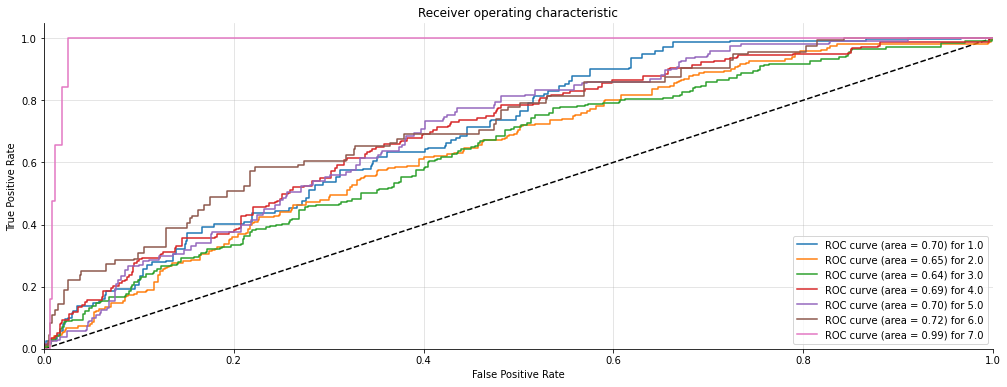

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
def Logistic(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs')   
    model.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in model.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    plot_multiclass_roc(model, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  Logistic(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

# Neural network - classifier

In [45]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

initializer = tf.keras.initializers.RandomNormal(seed=1) # Reproducibility

model = Sequential(name="classifier_NN")
model.add(tf.keras.Input(shape=(X_train.shape[1],))) # Automatically detect features as input nodes
model.add(layers.Dense(512, activation='relu', kernel_initializer=initializer))
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
model.add(layers.Dense(128, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(128, activation='relu', kernel_initializer=initializer))
model.add(layers.Dense(64, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(8)) # output layer
opt = tf.keras.optimizers.Adam(learning_rate = 0.0003)
model.compile(loss=tf.keras.losses.MeanSquaredError(), metrics=['mae'], optimizer = opt)
model.summary()

Model: "classifier_NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 512)               10752     
_________________________________________________________________
dense_11 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_14 (Dense)             (None, 128)             

Epoch 1/150
588/588 - 3s - loss: 4.8711 - mae: 1.7123 - val_loss: 2.8999 - val_mae: 1.3024
Epoch 2/150
588/588 - 2s - loss: 2.7390 - mae: 1.2848 - val_loss: 1.8726 - val_mae: 1.0522
Epoch 3/150
588/588 - 2s - loss: 1.9382 - mae: 1.0678 - val_loss: 1.4785 - val_mae: 0.9101
Epoch 4/150
588/588 - 2s - loss: 1.5825 - mae: 0.9564 - val_loss: 1.3894 - val_mae: 0.9206
Epoch 5/150
588/588 - 2s - loss: 1.4122 - mae: 0.9019 - val_loss: 1.1421 - val_mae: 0.8162
Epoch 6/150
588/588 - 2s - loss: 1.2491 - mae: 0.8321 - val_loss: 1.0293 - val_mae: 0.7478
Epoch 7/150
588/588 - 2s - loss: 1.1812 - mae: 0.8006 - val_loss: 0.9015 - val_mae: 0.6650
Epoch 8/150
588/588 - 3s - loss: 1.0645 - mae: 0.7488 - val_loss: 0.8207 - val_mae: 0.6382
Epoch 9/150
588/588 - 2s - loss: 1.0234 - mae: 0.7267 - val_loss: 0.8735 - val_mae: 0.6736
Epoch 10/150
588/588 - 2s - loss: 0.9919 - mae: 0.7107 - val_loss: 0.8297 - val_mae: 0.6695
Epoch 11/150
588/588 - 2s - loss: 0.9484 - mae: 0.6874 - val_loss: 0.8439 - val_mae: 0.66

Epoch 00090: early stopping


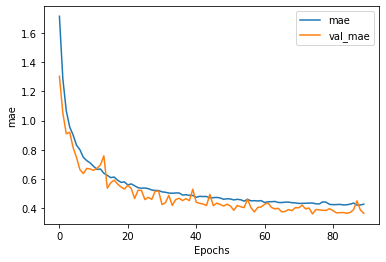

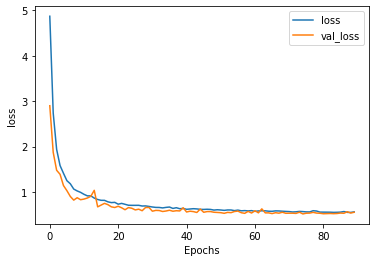

In [46]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
history = model.fit(X_train, y_train, epochs=150, batch_size = 16, validation_split=0.3, 
                    callbacks = [es], # Call checkpoint variable if neccessary
                    verbose=2)

plot_graphs(history, "mae")
plot_graphs(history, "loss")

In [47]:
scores = model.evaluate(
    X_test, y_test, batch_size=1, verbose=1, sample_weight=None, steps=None,
    callbacks=None, max_queue_size=10, workers=4, use_multiprocessing=False,
    return_dict=False
)
print("------------------ EVALUATION FINISHED! ------------------".center(115))
for i in range(len(scores)):
    print("%s: %.2f%%" % (model.metrics_names[i], scores[i]*100))

3360/3360 [==============================] - 5s 1ms/step - loss: 0.5714 - mae: 0.3773
                             ------------------ EVALUATION FINISHED! ------------------                            
loss: 57.14%
mae: 37.73%


# LSTM 

In [48]:
## Callbacks
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
  "model_checkpoints", monitor="val_loss", verbose=1, save_best_only=True, mode="min")

## Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

LSTM_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(4000, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(64, activation='relu', 
                          
                          # Prevent overfitting
                          kernel_regularizer=tf.keras.regularizers.L2(l2=0.01), 

                          # Ensuring consistent outputs and not run into potential local optima
                          # Avoid initializing standard normal (mean = 0, std = 1) to reach faster convergence and less initial loss.
                          kernel_initializer=tf.keras.initializers.RandomNormal(seed=42)
                          
                          ),
     
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation='linear')
])
LSTM_model.summary()

LSTM_model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer= opt, metrics=['mae'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         512000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_18 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 8)                 520       
Total params: 792,136
Trainable params: 792,136
Non-trainable params: 0
_________________________________________________________________


In [49]:
history = LSTM_model.fit(X_train, y_train, epochs=100, batch_size = 512, validation_split=0.2, 
                    callbacks = [es], # Call checkpoint variable if neccessary
                    verbose=1)

Epoch 1/100
21/21 [==============================] - 7s 274ms/step - loss: 13.7060 - mae: 3.0652 - val_loss: 4.3529 - val_mae: 1.7267
Epoch 2/100
21/21 [==============================] - 5s 247ms/step - loss: 4.9281 - mae: 1.7976 - val_loss: 3.4186 - val_mae: 1.5014
Epoch 3/100
21/21 [==============================] - 5s 247ms/step - loss: 3.2722 - mae: 1.3693 - val_loss: 1.8174 - val_mae: 0.9507
Epoch 4/100
21/21 [==============================] - 5s 231ms/step - loss: 1.9492 - mae: 1.0064 - val_loss: 1.2378 - val_mae: 0.7173
Epoch 5/100
21/21 [==============================] - 5s 249ms/step - loss: 1.5864 - mae: 0.8675 - val_loss: 1.0223 - val_mae: 0.6023
Epoch 6/100
21/21 [==============================] - 5s 231ms/step - loss: 1.4002 - mae: 0.7915 - val_loss: 0.9144 - val_mae: 0.5356
Epoch 7/100
21/21 [==============================] - 5s 248ms/step - loss: 1.2933 - mae: 0.7457 - val_loss: 0.8499 - val_mae: 0.4891
Epoch 8/100
21/21 [==============================] - 5s 231ms/step -

21/21 [==============================] - 5s 255ms/step - loss: 0.6262 - mae: 0.4812 - val_loss: 0.5397 - val_mae: 0.3906
Epoch 63/100
21/21 [==============================] - 6s 273ms/step - loss: 0.6236 - mae: 0.4777 - val_loss: 0.5265 - val_mae: 0.4265
Epoch 00063: early stopping


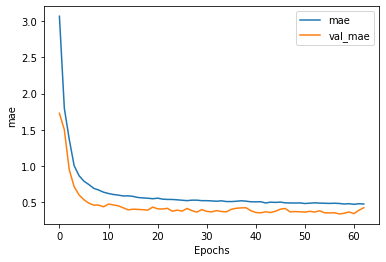

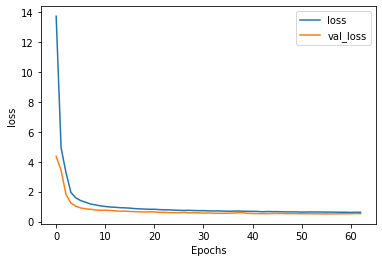

In [50]:
plot_graphs(history, "mae")
plot_graphs(history, "loss")

In [51]:
scores = LSTM_model.evaluate(
    X_test, y_test, batch_size=1, verbose=1, sample_weight=None, steps=None,
    callbacks=None, max_queue_size=10, workers=4, use_multiprocessing=False,
    return_dict=False
)
print("------------------ EVALUATION FINISHED! ------------------".center(115))
for i in range(len(scores)):
    print("%s: %.2f%%" % (model.metrics_names[i], scores[i]*100))

3360/3360 [==============================] - 10s 3ms/step - loss: 0.5402 - mae: 0.4311
                             ------------------ EVALUATION FINISHED! ------------------                            
loss: 54.02%
mae: 43.11%


In [52]:
LSTM_y_pred = LSTM_model.predict(X_test)
LSTM_y_pred_flattened = LSTM_y_pred.flatten(order='F')
LSTM_y_classified = [round(float(x)) for x in LSTM_y_pred_flattened]

print("First ten examples of the test set:")
print("Truth labels:", y_test.flatten(order='F')[:10])
print("Predicted labels:",LSTM_y_classified[:10])
print("Overall performance on all columns:\n", classification_report(y_test.flatten(order='F'), LSTM_y_classified))

First ten examples of the test set:
Truth labels: [2. 1. 2. 1. 4. 3. 4. 3. 3. 7.]
Predicted labels: [2, 2, 3, 1, 5, 4, 4, 3, 4, 1]
Overall performance on all columns:
               precision    recall  f1-score   support

         1.0       0.96      0.67      0.79      3691
         2.0       0.59      0.54      0.57      3921
         3.0       0.59      0.73      0.65      3952
         4.0       0.71      0.81      0.76      4161
         5.0       0.77      0.81      0.79      3786
         6.0       0.88      0.81      0.84      3748
         7.0       0.92      0.91      0.92      3621

    accuracy                           0.75     26880
   macro avg       0.77      0.76      0.76     26880
weighted avg       0.77      0.75      0.76     26880



# Ensemble

In [53]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier


# Decison tree classifier

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       462
         2.0       0.83      0.88      0.85       482
         3.0       0.76      0.71      0.73       510
         4.0       0.66      0.68      0.67       517
         5.0       0.65      0.63      0.64       467
         6.0       0.73      0.72      0.73       470
         7.0       0.81      0.81      0.81       452

    accuracy                           0.77      3360
   macro avg       0.77      0.77      0.77      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  20   0   0   0   0   0]
 [  3 425  52   0   1   1   0]
 [  0  18 363 125   1   3   0]
 [  0   1  18 352 143   1   2]
 [  4   4  15  36 296 112   0]
 [  3  20  10  10   5 339  83]
 [ 10  26  20  11  11   6 368]]
Accuracy Score : 0.7693452380952381
Precision Score : 0.7688008662681955
Recall Score : 0.7693452380952381
F1 Score : 0.7687843

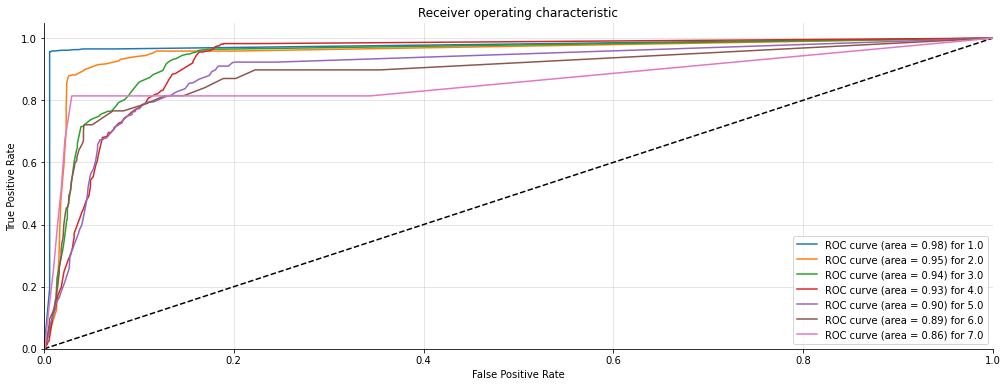

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.83      0.88      0.85       485
         3.0       0.76      0.73      0.74       501
         4.0       0.69      0.70      0.70       515
         5.0       0.71      0.73      0.72       460
         6.0       0.83      0.79      0.81       484
         7.0       0.90      0.90      0.90       452

    accuracy                           0.81      3360
   macro avg       0.81      0.81      0.81      3360
weighted avg       0.81      0.81      0.81      3360

Confusion Matrix: 
 [[442  20   0   0   0   1   0]
 [  3 426  52   0   1   3   0]
 [  0  15 364 120   2   0   0]
 [  0   2  27 361 123   2   0]
 [  3  12  16  23 336  70   0]
 [  5  19  15  12   6 384  43]
 [  9  18   6   4   5   2 408]]
Accuracy Score : 0.8098214285714286
Precision Score : 0.8100897055539051
Recall Score : 0.8098214285714286
F1 Score : 0.8097290783810

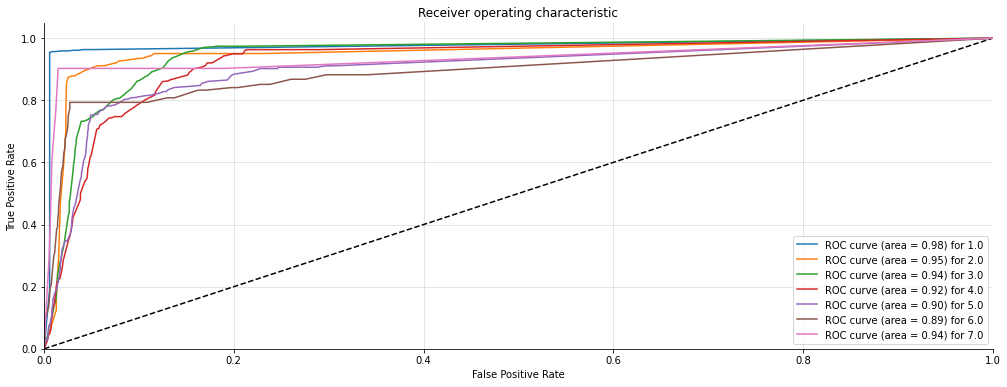

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       462
         2.0       0.83      0.88      0.86       482
         3.0       0.76      0.72      0.74       506
         4.0       0.67      0.68      0.68       526
         5.0       0.65      0.65      0.65       458
         6.0       0.73      0.71      0.72       475
         7.0       0.83      0.83      0.83       451

    accuracy                           0.77      3360
   macro avg       0.77      0.78      0.77      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  19   0   0   0   1   0]
 [  3 426  52   0   1   0   0]
 [  0  15 364 124   0   3   0]
 [  0   2  21 359 142   0   2]
 [  2   4   7  31 297 117   0]
 [  6  19  21  10   7 335  77]
 [  9  27  15  12   8   6 374]]
Accuracy Score : 0.7729166666666667
Precision Score : 0.7722593459908481
Recall Score : 0.7729166666666667
F1 Score : 0.77236818

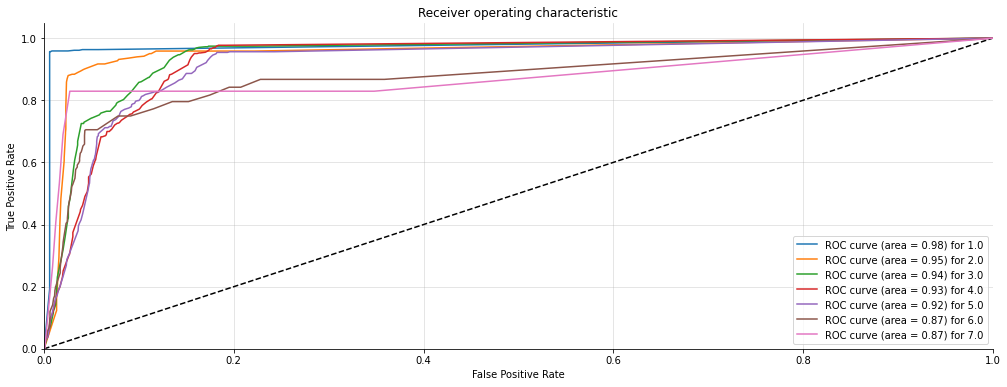

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       461
         2.0       0.83      0.87      0.85       488
         3.0       0.76      0.72      0.74       506
         4.0       0.66      0.68      0.67       516
         5.0       0.66      0.66      0.66       456
         6.0       0.73      0.72      0.73       471
         7.0       0.81      0.79      0.80       462

    accuracy                           0.77      3360
   macro avg       0.77      0.77      0.77      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  19   0   0   0   0   0]
 [  3 426  53   2   1   3   0]
 [  0  15 363 127   0   1   0]
 [  0   1  15 353 143   2   2]
 [  2   2   9  27 303 113   0]
 [  2  15  16   9   4 339  86]
 [ 13  33  23  15   9   4 365]]
Accuracy Score : 0.7711309523809524
Precision Score : 0.7712179633693005
Recall Score : 0.7711309523809524
F1 Score : 0.7709761912751

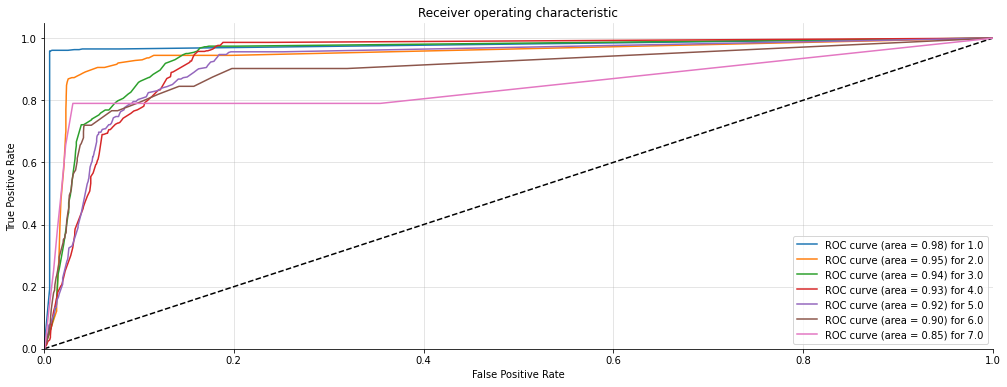

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.87      0.88      0.87       491
         3.0       0.83      0.81      0.82       487
         4.0       0.86      0.86      0.86       518
         5.0       0.91      0.92      0.92       487
         6.0       0.96      0.96      0.96       462
         7.0       0.99      0.99      0.99       452

    accuracy                           0.91      3360
   macro avg       0.91      0.91      0.91      3360
weighted avg       0.91      0.91      0.91      3360

Confusion Matrix: 
 [[442  18   1   0   1   1   0]
 [  6 433  46   2   1   3   0]
 [  7  25 395  58   2   0   0]
 [  3  15  18 447  34   1   0]
 [  1   5  11   9 450  11   0]
 [  1   3   4   2   4 443   5]
 [  0   0   2   0   1   3 446]]
Accuracy Score : 0.9095238095238095
Precision Score : 0.9094446093623482
Recall Score : 0.9095238095238095
F1 Score : 0.90945653194747

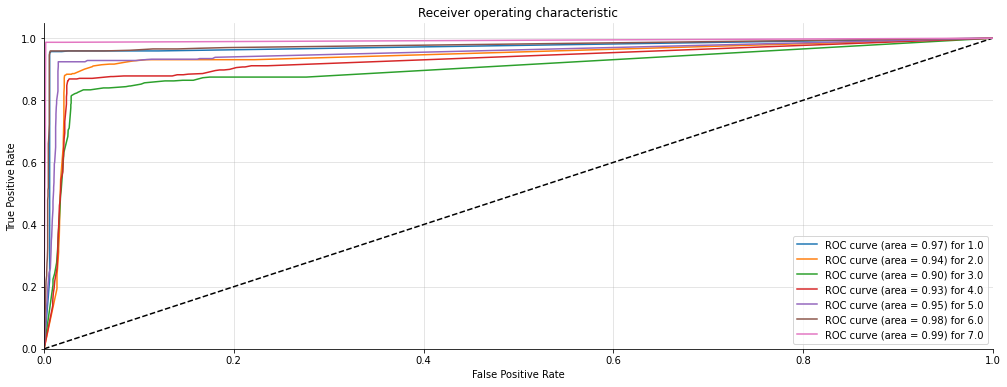

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       461
         2.0       0.85      0.87      0.86       495
         3.0       0.82      0.78      0.79       490
         4.0       0.83      0.83      0.83       519
         5.0       0.88      0.91      0.90       481
         6.0       0.96      0.96      0.96       465
         7.0       0.99      0.99      0.99       449

    accuracy                           0.90      3360
   macro avg       0.90      0.90      0.90      3360
weighted avg       0.90      0.90      0.90      3360

Confusion Matrix: 
 [[442  18   1   0   0   0   0]
 [  6 431  50   2   2   4   0]
 [  7  34 380  68   0   1   0]
 [  3  18  18 431  49   0   0]
 [  1   7  11  15 436  11   0]
 [  1   2   4   2   6 445   5]
 [  0   0   2   0   0   1 446]]
Accuracy Score : 0.8961309523809524
Precision Score : 0.8958293059623144
Recall Score : 0.8961309523809524
F1 Score : 0.89

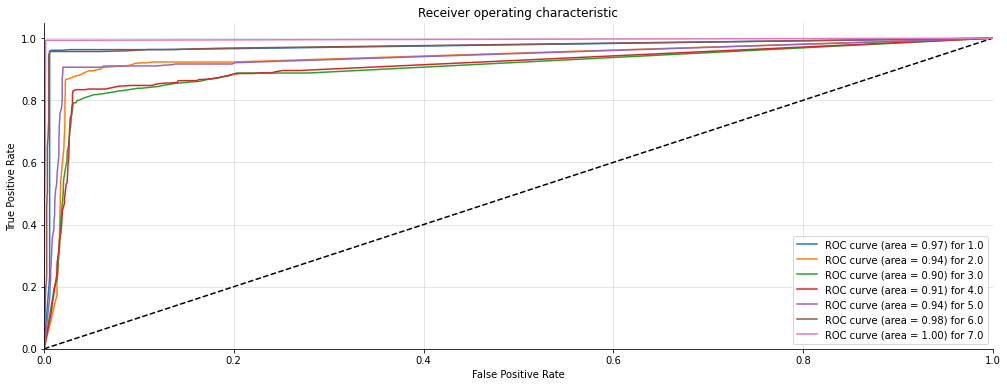

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       460
         2.0       0.96      0.95      0.96       502
         3.0       0.94      0.95      0.95       474
         4.0       0.96      0.94      0.95       527
         5.0       0.97      0.98      0.97       486
         6.0       0.98      0.99      0.99       459
         7.0       1.00      1.00      1.00       452

    accuracy                           0.97      3360
   macro avg       0.97      0.97      0.97      3360
weighted avg       0.97      0.97      0.97      3360

Confusion Matrix: 
 [[454   6   0   0   0   0   0]
 [  5 479  15   2   1   0   0]
 [  0  11 450  13   0   0   0]
 [  0   1  12 498  12   4   0]
 [  0   0   0   8 476   2   0]
 [  0   0   0   0   4 455   0]
 [  0   0   0   0   0   1 451]]
Accuracy Score : 0.9711309523809524
Precision Score : 0.9711308899319431
Recall Score : 0.9711309523809524
F1 Score : 0.9711121

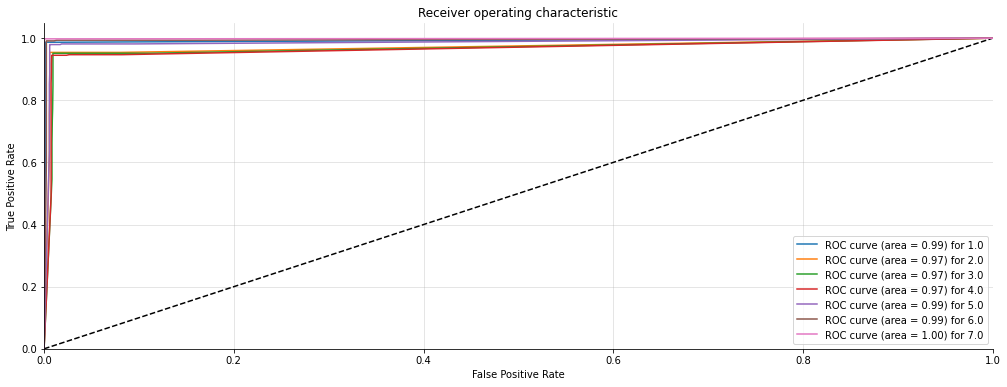

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       459
         2.0       1.00      1.00      1.00       496
         3.0       1.00      1.00      1.00       478
         4.0       1.00      1.00      1.00       523
         5.0       1.00      1.00      1.00       491
         6.0       1.00      1.00      1.00       462
         7.0       1.00      1.00      1.00       451

    accuracy                           1.00      3360
   macro avg       1.00      1.00      1.00      3360
weighted avg       1.00      1.00      1.00      3360

Confusion Matrix: 
 [[459   0   0   0   0   0   0]
 [  0 496   0   0   0   0   0]
 [  0   0 478   0   0   0   0]
 [  0   0   0 523   0   0   0]
 [  0   0   0   0 491   0   0]
 [  0   0   0   0   0 462   0]
 [  0   0   0   0   0   0 451]]
Accuracy Score : 1.0
Precision Score : 1.0
Recall Score : 1.0
F1 Score : 1.0
(3360, 7) (3360, 7)


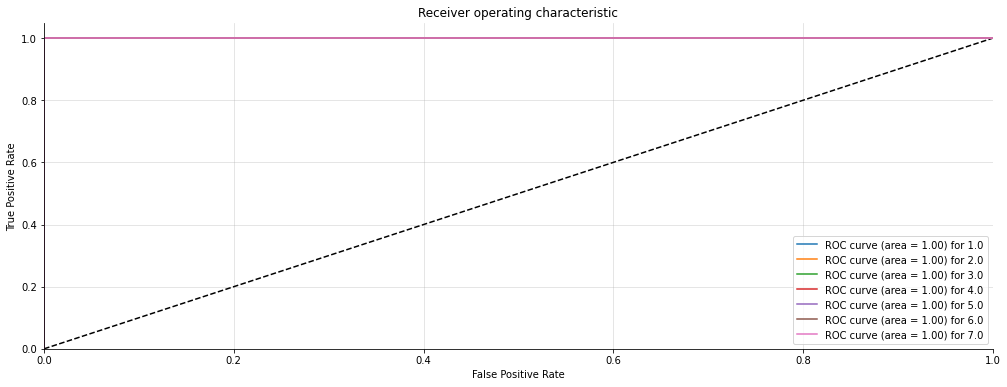

In [54]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
def DTC(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    model = DecisionTreeClassifier(max_depth=None, min_samples_split=2,
     random_state=0)   
    model.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in model.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    plot_multiclass_roc(model, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  DTC(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

# Random forest classifier

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       462
         2.0       0.84      0.88      0.86       482
         3.0       0.76      0.72      0.74       510
         4.0       0.66      0.68      0.67       517
         5.0       0.65      0.65      0.65       467
         6.0       0.73      0.72      0.73       470
         7.0       0.81      0.81      0.81       452

    accuracy                           0.77      3360
   macro avg       0.77      0.77      0.77      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  20   0   0   0   0   0]
 [  3 425  52   0   1   1   0]
 [  0  12 367 126   1   4   0]
 [  0   1  16 353 144   1   2]
 [  4   3  16  30 302 112   0]
 [  3  20   9  11   5 339  83]
 [ 10  26  20  11  11   6 368]]
Accuracy Score : 0.7726190476190476
Precision Score : 0.772303398414997
Recall Score : 0.7726190476190476
F1 Score : 0.77225366

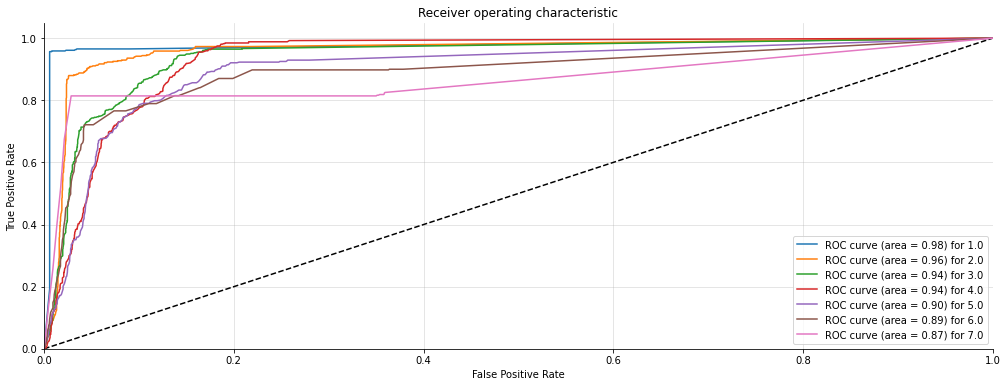

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.84      0.88      0.86       485
         3.0       0.77      0.73      0.75       501
         4.0       0.70      0.70      0.70       515
         5.0       0.71      0.75      0.73       460
         6.0       0.83      0.79      0.81       484
         7.0       0.90      0.90      0.90       452

    accuracy                           0.81      3360
   macro avg       0.82      0.82      0.81      3360
weighted avg       0.81      0.81      0.81      3360

Confusion Matrix: 
 [[442  20   0   0   0   1   0]
 [  3 426  52   0   1   3   0]
 [  0  12 365 122   2   0   0]
 [  0   2  22 362 127   2   0]
 [  3  12  16  16 343  70   0]
 [  5  18  14  14   6 384  43]
 [  9  18   6   4   5   2 408]]
Accuracy Score : 0.8125
Precision Score : 0.8130160228559518
Recall Score : 0.8125
F1 Score : 0.8124834949260713
(3360, 7) (3360, 7)


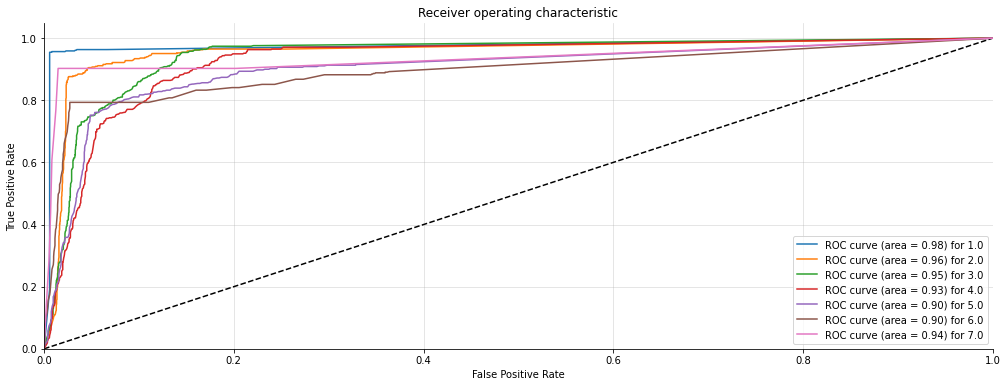

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       462
         2.0       0.84      0.88      0.86       482
         3.0       0.76      0.72      0.74       506
         4.0       0.68      0.68      0.68       526
         5.0       0.65      0.67      0.66       458
         6.0       0.72      0.71      0.71       475
         7.0       0.83      0.83      0.83       451

    accuracy                           0.78      3360
   macro avg       0.78      0.78      0.78      3360
weighted avg       0.77      0.78      0.77      3360

Confusion Matrix: 
 [[442  19   0   0   0   1   0]
 [  3 426  52   0   1   0   0]
 [  0  12 365 125   0   4   0]
 [  0   2  19 357 146   0   2]
 [  2   4   7  22 306 117   0]
 [  6  18  21  11   7 335  77]
 [  9  27  15  12   8   6 374]]
Accuracy Score : 0.7752976190476191
Precision Score : 0.774876896877023
Recall Score : 0.7752976190476191
F1 Score : 0.774890449

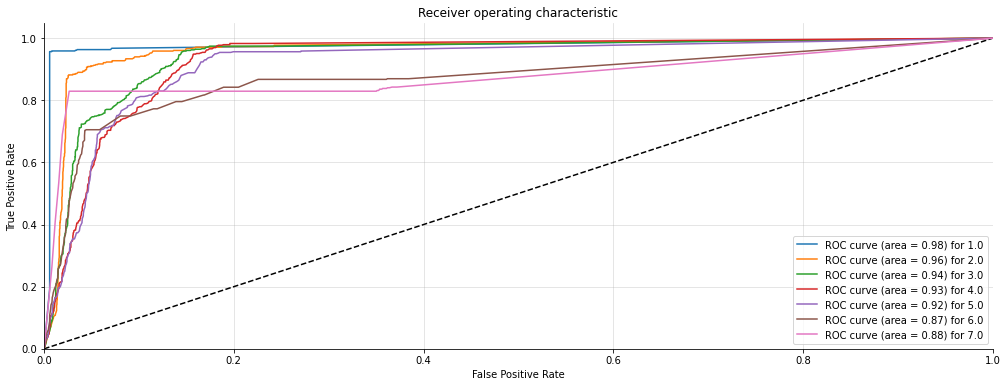

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       461
         2.0       0.84      0.87      0.86       488
         3.0       0.77      0.72      0.74       506
         4.0       0.67      0.69      0.68       516
         5.0       0.66      0.68      0.67       456
         6.0       0.73      0.72      0.73       471
         7.0       0.81      0.79      0.80       462

    accuracy                           0.77      3360
   macro avg       0.78      0.77      0.77      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  19   0   0   0   0   0]
 [  3 426  53   2   1   3   0]
 [  0  12 364 128   1   1   0]
 [  0   0  11 355 146   2   2]
 [  2   2   8  23 308 113   0]
 [  2  15  16   9   4 339  86]
 [ 13  33  22  16   9   4 365]]
Accuracy Score : 0.7735119047619048
Precision Score : 0.7740024313321312
Recall Score : 0.7735119047619048
F1 Score : 0.7735269884641

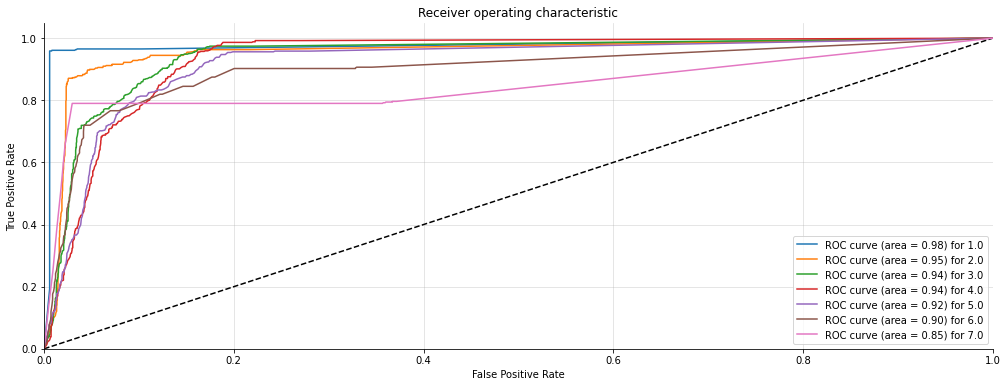

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.87      0.88      0.87       491
         3.0       0.83      0.81      0.82       487
         4.0       0.86      0.86      0.86       518
         5.0       0.91      0.92      0.92       487
         6.0       0.96      0.96      0.96       462
         7.0       0.99      0.99      0.99       452

    accuracy                           0.91      3360
   macro avg       0.91      0.91      0.91      3360
weighted avg       0.91      0.91      0.91      3360

Confusion Matrix: 
 [[442  18   1   0   1   1   0]
 [  6 433  46   2   1   3   0]
 [  7  25 394  59   2   0   0]
 [  3  15  18 447  34   1   0]
 [  1   5  11   9 450  11   0]
 [  1   3   4   2   4 443   5]
 [  0   0   2   0   1   3 446]]
Accuracy Score : 0.9092261904761905
Precision Score : 0.9091359331446817
Recall Score : 0.9092261904761905
F1 Score : 0.90915056698569

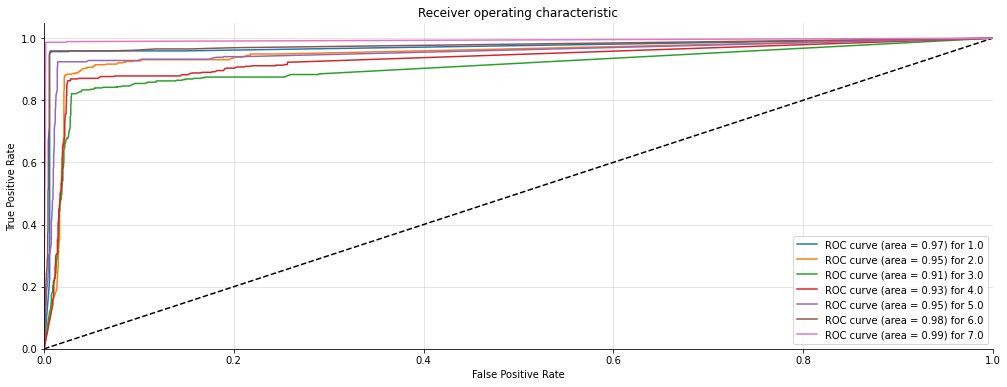

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       461
         2.0       0.85      0.87      0.86       495
         3.0       0.81      0.78      0.80       490
         4.0       0.83      0.83      0.83       519
         5.0       0.88      0.91      0.90       481
         6.0       0.96      0.96      0.96       465
         7.0       0.99      0.99      0.99       449

    accuracy                           0.90      3360
   macro avg       0.90      0.90      0.90      3360
weighted avg       0.90      0.90      0.90      3360

Confusion Matrix: 
 [[442  18   1   0   0   0   0]
 [  6 431  50   2   2   4   0]
 [  7  31 382  69   0   1   0]
 [  3  17  19 431  49   0   0]
 [  1   7  11  15 436  11   0]
 [  1   2   4   2   6 445   5]
 [  0   0   2   0   0   1 446]]
Accuracy Score : 0.8967261904761905
Precision Score : 0.896427080129009
Recall Score : 0.8967261904761905
F1 Score : 0.896

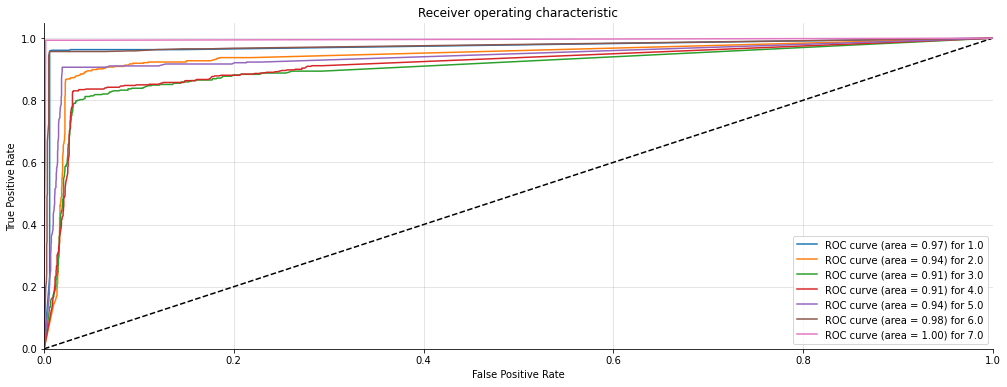

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       460
         2.0       0.97      0.95      0.96       502
         3.0       0.94      0.95      0.95       474
         4.0       0.95      0.94      0.95       527
         5.0       0.97      0.98      0.97       486
         6.0       0.98      0.99      0.99       459
         7.0       1.00      1.00      1.00       452

    accuracy                           0.97      3360
   macro avg       0.97      0.97      0.97      3360
weighted avg       0.97      0.97      0.97      3360

Confusion Matrix: 
 [[454   6   0   0   0   0   0]
 [  5 479  15   2   1   0   0]
 [  0  10 450  14   0   0   0]
 [  0   1  12 498  12   4   0]
 [  0   0   0   8 476   2   0]
 [  0   0   0   0   4 455   0]
 [  0   0   0   0   0   1 451]]
Accuracy Score : 0.9711309523809524
Precision Score : 0.9711339945570253
Recall Score : 0.9711309523809524
F1 Score : 0.9711136

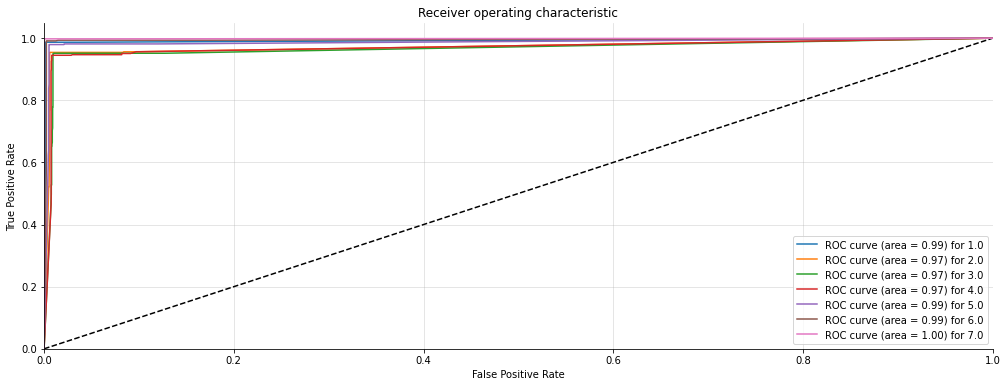

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       459
         2.0       1.00      1.00      1.00       496
         3.0       1.00      1.00      1.00       478
         4.0       1.00      1.00      1.00       523
         5.0       1.00      1.00      1.00       491
         6.0       1.00      1.00      1.00       462
         7.0       1.00      1.00      1.00       451

    accuracy                           1.00      3360
   macro avg       1.00      1.00      1.00      3360
weighted avg       1.00      1.00      1.00      3360

Confusion Matrix: 
 [[459   0   0   0   0   0   0]
 [  0 496   0   0   0   0   0]
 [  0   0 478   0   0   0   0]
 [  0   0   0 523   0   0   0]
 [  0   0   0   0 491   0   0]
 [  0   0   0   0   0 462   0]
 [  0   0   0   0   0   0 451]]
Accuracy Score : 1.0
Precision Score : 1.0
Recall Score : 1.0
F1 Score : 1.0
(3360, 7) (3360, 7)


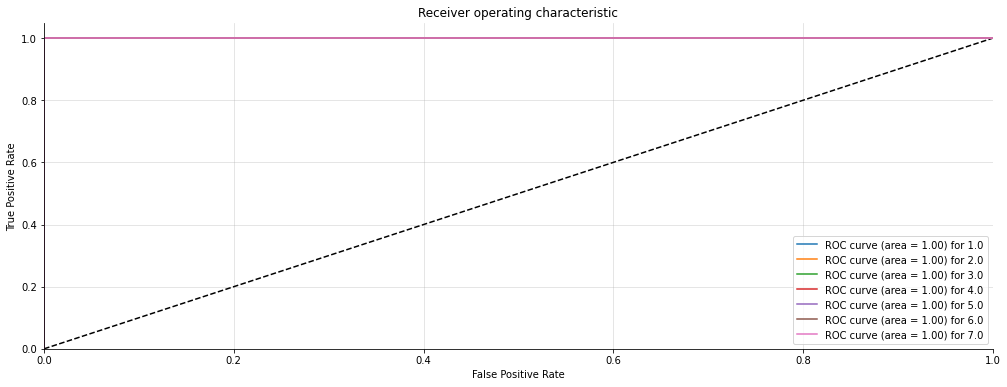

In [55]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
def RFC(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    model = RandomForestClassifier(n_estimators=100, max_depth=None,
     min_samples_split=2, random_state=0)   
    model.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in model.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    plot_multiclass_roc(model, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  RFC(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

# Extra Trees Classifier

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       462
         2.0       0.83      0.88      0.85       482
         3.0       0.76      0.71      0.73       510
         4.0       0.66      0.68      0.67       517
         5.0       0.65      0.63      0.64       467
         6.0       0.73      0.72      0.73       470
         7.0       0.81      0.81      0.81       452

    accuracy                           0.77      3360
   macro avg       0.77      0.77      0.77      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  20   0   0   0   0   0]
 [  3 425  52   0   1   1   0]
 [  0  18 363 125   1   3   0]
 [  0   1  18 352 143   1   2]
 [  4   4  15  36 296 112   0]
 [  3  20  10  10   5 339  83]
 [ 10  26  20  11  11   6 368]]
Accuracy Score : 0.7693452380952381
Precision Score : 0.7688008662681955
Recall Score : 0.7693452380952381
F1 Score : 0.7687843

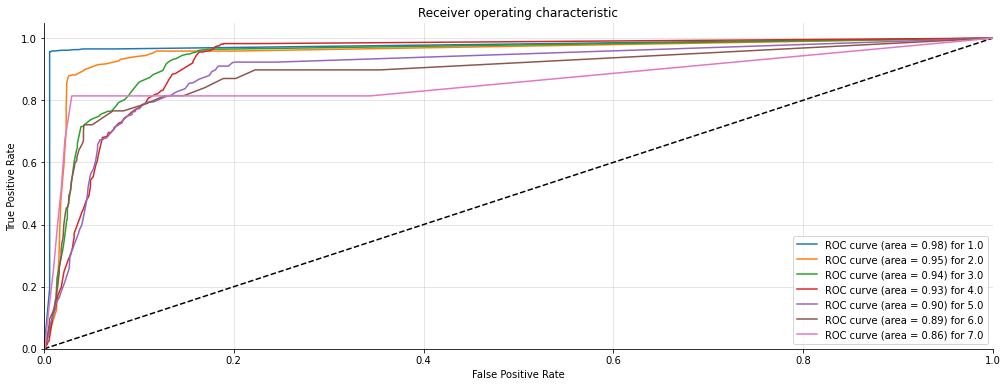

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.83      0.88      0.85       485
         3.0       0.76      0.73      0.74       501
         4.0       0.69      0.70      0.70       515
         5.0       0.71      0.73      0.72       460
         6.0       0.83      0.79      0.81       484
         7.0       0.90      0.90      0.90       452

    accuracy                           0.81      3360
   macro avg       0.81      0.81      0.81      3360
weighted avg       0.81      0.81      0.81      3360

Confusion Matrix: 
 [[442  20   0   0   0   1   0]
 [  3 426  52   0   1   3   0]
 [  0  15 364 120   2   0   0]
 [  0   2  27 361 123   2   0]
 [  3  12  16  23 336  70   0]
 [  5  19  15  12   6 384  43]
 [  9  18   6   4   5   2 408]]
Accuracy Score : 0.8098214285714286
Precision Score : 0.8100897055539051
Recall Score : 0.8098214285714286
F1 Score : 0.8097290783810

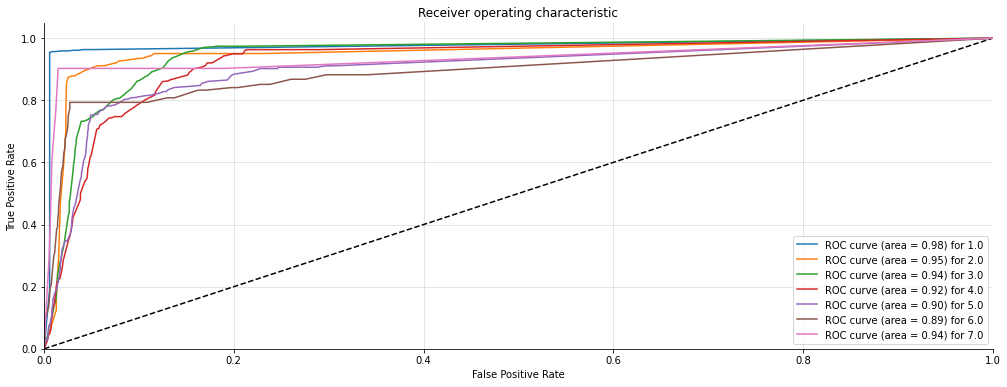

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       462
         2.0       0.83      0.88      0.86       482
         3.0       0.76      0.72      0.74       506
         4.0       0.67      0.68      0.68       526
         5.0       0.65      0.65      0.65       458
         6.0       0.73      0.71      0.72       475
         7.0       0.83      0.83      0.83       451

    accuracy                           0.77      3360
   macro avg       0.77      0.78      0.77      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  19   0   0   0   1   0]
 [  3 426  52   0   1   0   0]
 [  0  15 364 124   0   3   0]
 [  0   2  21 359 142   0   2]
 [  2   4   7  31 297 117   0]
 [  6  19  21  10   7 335  77]
 [  9  27  15  12   8   6 374]]
Accuracy Score : 0.7729166666666667
Precision Score : 0.7722593459908481
Recall Score : 0.7729166666666667
F1 Score : 0.77236818

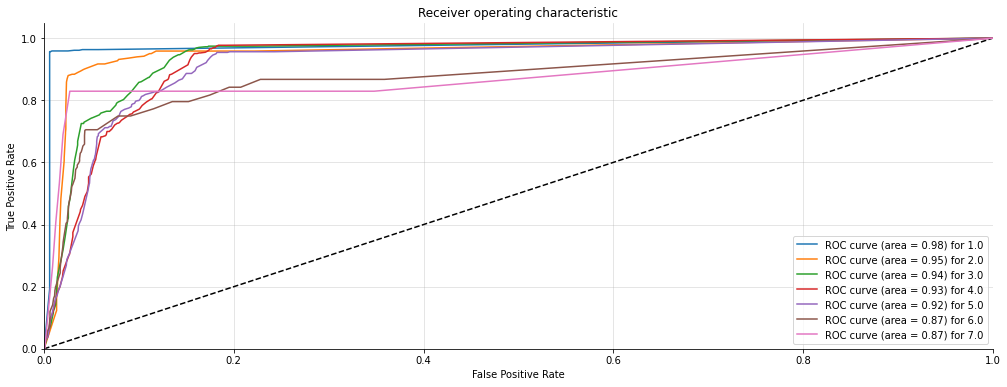

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       461
         2.0       0.83      0.87      0.85       488
         3.0       0.76      0.72      0.74       506
         4.0       0.66      0.68      0.67       516
         5.0       0.66      0.66      0.66       456
         6.0       0.73      0.72      0.73       471
         7.0       0.81      0.79      0.80       462

    accuracy                           0.77      3360
   macro avg       0.77      0.77      0.77      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  19   0   0   0   0   0]
 [  3 426  53   2   1   3   0]
 [  0  15 363 127   0   1   0]
 [  0   1  15 353 143   2   2]
 [  2   2   9  27 303 113   0]
 [  2  15  16   9   4 339  86]
 [ 13  33  23  15   9   4 365]]
Accuracy Score : 0.7711309523809524
Precision Score : 0.7712179633693005
Recall Score : 0.7711309523809524
F1 Score : 0.7709761912751

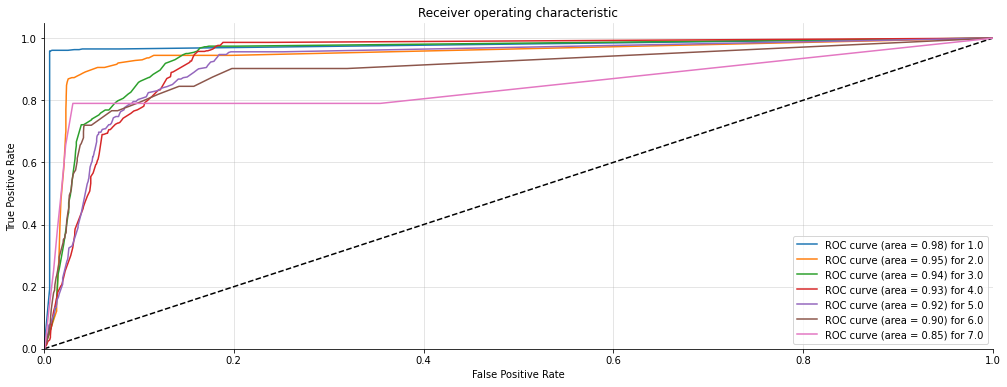

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.87      0.88      0.87       491
         3.0       0.83      0.81      0.82       487
         4.0       0.86      0.86      0.86       518
         5.0       0.91      0.92      0.92       487
         6.0       0.96      0.96      0.96       462
         7.0       0.99      0.99      0.99       452

    accuracy                           0.91      3360
   macro avg       0.91      0.91      0.91      3360
weighted avg       0.91      0.91      0.91      3360

Confusion Matrix: 
 [[442  18   1   0   1   1   0]
 [  6 433  46   2   1   3   0]
 [  7  25 395  58   2   0   0]
 [  3  15  18 447  34   1   0]
 [  1   5  11   9 450  11   0]
 [  1   3   4   2   4 443   5]
 [  0   0   2   0   1   3 446]]
Accuracy Score : 0.9095238095238095
Precision Score : 0.9094446093623482
Recall Score : 0.9095238095238095
F1 Score : 0.90945653194747

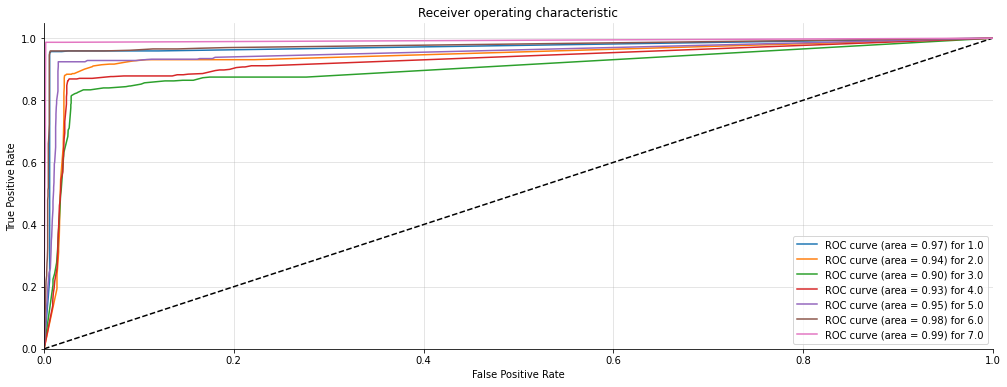

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       461
         2.0       0.85      0.87      0.86       495
         3.0       0.82      0.78      0.79       490
         4.0       0.83      0.83      0.83       519
         5.0       0.88      0.91      0.90       481
         6.0       0.96      0.96      0.96       465
         7.0       0.99      0.99      0.99       449

    accuracy                           0.90      3360
   macro avg       0.90      0.90      0.90      3360
weighted avg       0.90      0.90      0.90      3360

Confusion Matrix: 
 [[442  18   1   0   0   0   0]
 [  6 431  50   2   2   4   0]
 [  7  34 380  68   0   1   0]
 [  3  18  18 431  49   0   0]
 [  1   7  11  15 436  11   0]
 [  1   2   4   2   6 445   5]
 [  0   0   2   0   0   1 446]]
Accuracy Score : 0.8961309523809524
Precision Score : 0.8958293059623144
Recall Score : 0.8961309523809524
F1 Score : 0.89

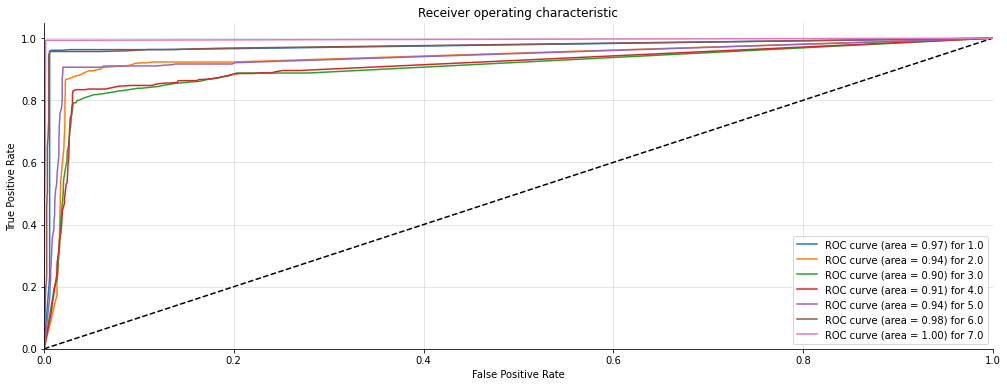

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       460
         2.0       0.96      0.95      0.96       502
         3.0       0.94      0.95      0.95       474
         4.0       0.96      0.94      0.95       527
         5.0       0.97      0.98      0.97       486
         6.0       0.98      0.99      0.99       459
         7.0       1.00      1.00      1.00       452

    accuracy                           0.97      3360
   macro avg       0.97      0.97      0.97      3360
weighted avg       0.97      0.97      0.97      3360

Confusion Matrix: 
 [[454   6   0   0   0   0   0]
 [  5 479  15   2   1   0   0]
 [  0  11 450  13   0   0   0]
 [  0   1  12 498  12   4   0]
 [  0   0   0   8 476   2   0]
 [  0   0   0   0   4 455   0]
 [  0   0   0   0   0   1 451]]
Accuracy Score : 0.9711309523809524
Precision Score : 0.9711308899319431
Recall Score : 0.9711309523809524
F1 Score : 0.9711121

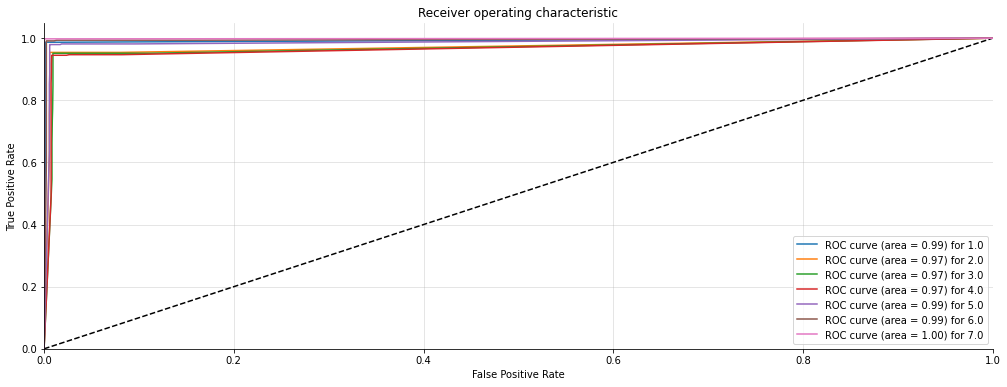

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       459
         2.0       1.00      1.00      1.00       496
         3.0       1.00      1.00      1.00       478
         4.0       1.00      1.00      1.00       523
         5.0       1.00      1.00      1.00       491
         6.0       1.00      1.00      1.00       462
         7.0       1.00      1.00      1.00       451

    accuracy                           1.00      3360
   macro avg       1.00      1.00      1.00      3360
weighted avg       1.00      1.00      1.00      3360

Confusion Matrix: 
 [[459   0   0   0   0   0   0]
 [  0 496   0   0   0   0   0]
 [  0   0 478   0   0   0   0]
 [  0   0   0 523   0   0   0]
 [  0   0   0   0 491   0   0]
 [  0   0   0   0   0 462   0]
 [  0   0   0   0   0   0 451]]
Accuracy Score : 1.0
Precision Score : 1.0
Recall Score : 1.0
F1 Score : 1.0
(3360, 7) (3360, 7)


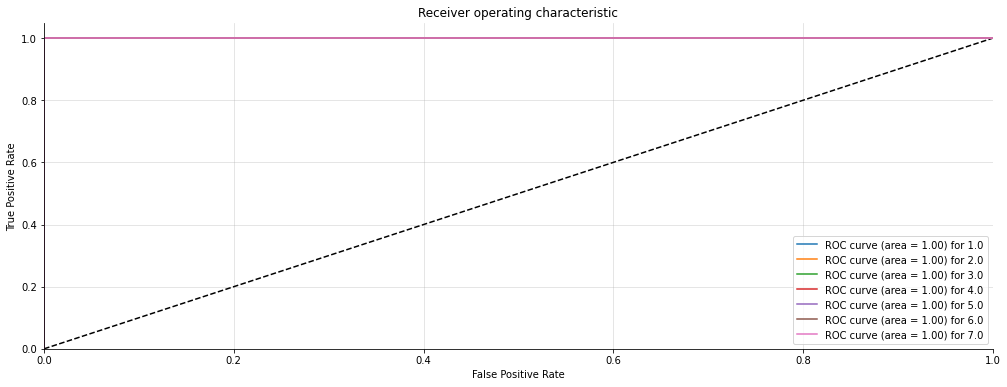

In [56]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
def ETC(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    model = ExtraTreesClassifier(n_estimators=100, max_depth=None,
     min_samples_split=2, random_state=0)   
    model.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in model.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    plot_multiclass_roc(model, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  ETC(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

# Adaboost 

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.60      0.62      0.61       462
         2.0       0.34      0.40      0.37       482
         3.0       0.31      0.38      0.34       510
         4.0       0.41      0.34      0.37       517
         5.0       0.38      0.32      0.35       467
         6.0       0.47      0.44      0.46       470
         7.0       0.73      0.69      0.71       452

    accuracy                           0.45      3360
   macro avg       0.46      0.46      0.46      3360
weighted avg       0.46      0.45      0.45      3360

Confusion Matrix: 
 [[288  79  25  18  21  19  12]
 [ 50 195 101  41  30  57   8]
 [ 39  94 193  73  51  47  13]
 [ 33  75 106 177  95  30   1]
 [ 27  55  78  84 148  70   5]
 [ 28  54  43  30  33 208  74]
 [ 16  15  74  14  11  11 311]]
Accuracy Score : 0.4523809523809524
Precision Score : 0.4586136922275975
Recall Score : 0.4523809523809524
F1 Score : 0.4536500

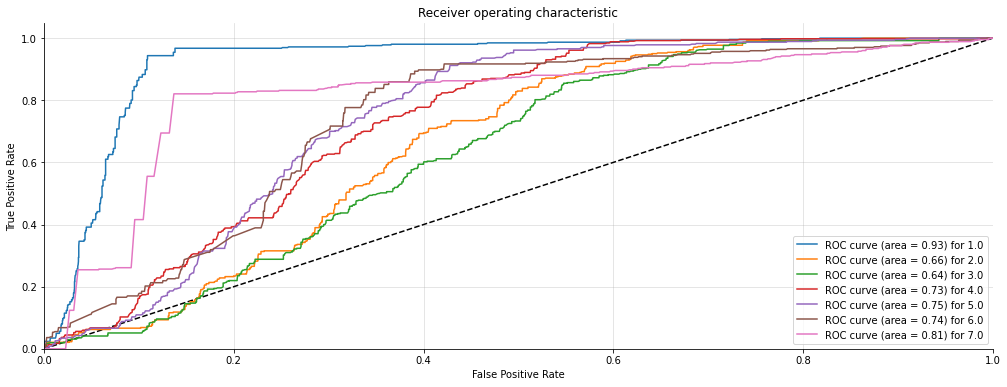

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.59      0.66      0.62       463
         2.0       0.28      0.40      0.33       485
         3.0       0.30      0.32      0.31       501
         4.0       0.37      0.29      0.32       515
         5.0       0.33      0.34      0.34       460
         6.0       0.53      0.43      0.47       484
         7.0       0.80      0.63      0.71       452

    accuracy                           0.43      3360
   macro avg       0.46      0.44      0.44      3360
weighted avg       0.45      0.43      0.44      3360

Confusion Matrix: 
 [[305  56  49  20  16  12   5]
 [ 59 194  72  34  81  32  13]
 [ 45 122 159  79  59  36   1]
 [ 33  84 118 147 109  23   1]
 [ 36  47  69  76 158  70   4]
 [ 26  61  52  40  52 206  47]
 [ 13 134   4   4   5   7 285]]
Accuracy Score : 0.43273809523809526
Precision Score : 0.452704714661296
Recall Score : 0.43273809523809526
F1 Score : 0.437805867286

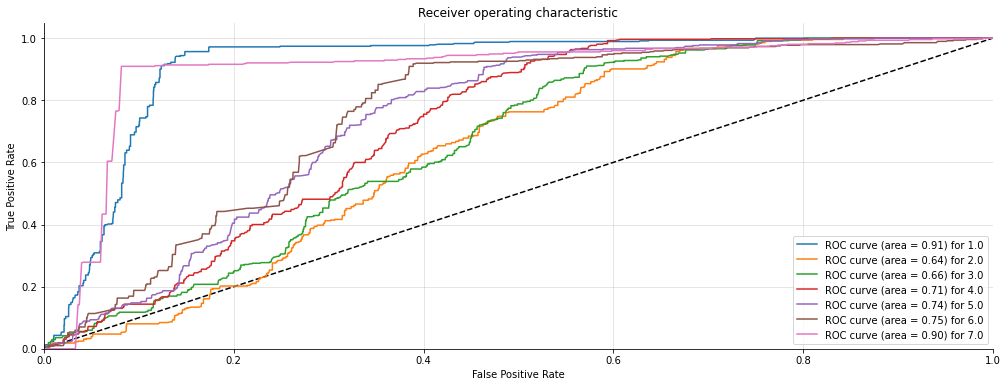

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.60      0.63      0.62       462
         2.0       0.40      0.43      0.41       482
         3.0       0.29      0.38      0.33       506
         4.0       0.37      0.30      0.33       526
         5.0       0.36      0.32      0.34       458
         6.0       0.43      0.41      0.42       475
         7.0       0.63      0.57      0.60       451

    accuracy                           0.43      3360
   macro avg       0.44      0.43      0.43      3360
weighted avg       0.43      0.43      0.43      3360

Confusion Matrix: 
 [[291  53  37  28  14  30   9]
 [ 48 206  79  50  44  44  11]
 [ 44 101 191  81  34  35  20]
 [ 22  69 122 159 114  19  21]
 [ 32  30  77  80 147  67  25]
 [ 30  42  76  22  44 193  68]
 [ 17  12  76  15   7  66 258]]
Accuracy Score : 0.43005952380952384
Precision Score : 0.4349592352187837
Recall Score : 0.43005952380952384
F1 Score : 0.430702

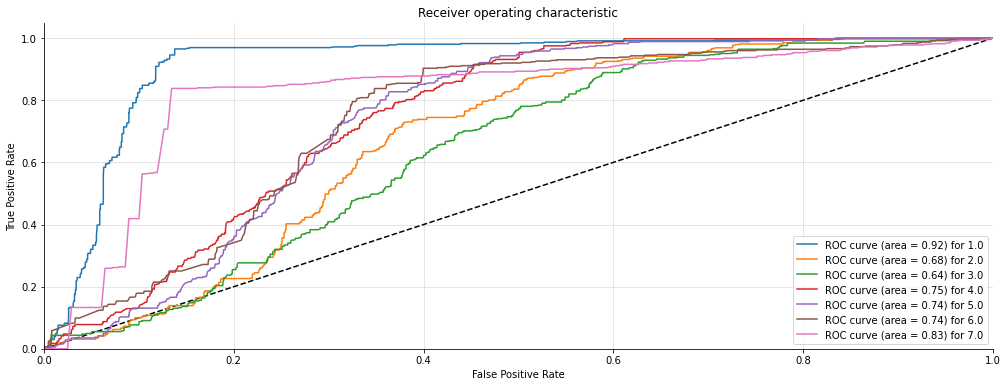

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.63      0.66      0.64       461
         2.0       0.33      0.41      0.36       488
         3.0       0.32      0.35      0.34       506
         4.0       0.35      0.29      0.32       516
         5.0       0.31      0.27      0.29       456
         6.0       0.44      0.40      0.42       471
         7.0       0.69      0.67      0.68       462

    accuracy                           0.43      3360
   macro avg       0.44      0.44      0.43      3360
weighted avg       0.43      0.43      0.43      3360

Confusion Matrix: 
 [[302  58  31  30  11  15  14]
 [ 45 202  71  44  57  48  21]
 [ 50 101 179  83  37  40  16]
 [ 25 102 107 149  90  39   4]
 [ 17  68  66  84 122  97   2]
 [ 26  60  33  19  63 190  80]
 [ 16  30  74  15  14   5 308]]
Accuracy Score : 0.43214285714285716
Precision Score : 0.43396545684614896
Recall Score : 0.43214285714285716
F1 Score : 0.4312971766

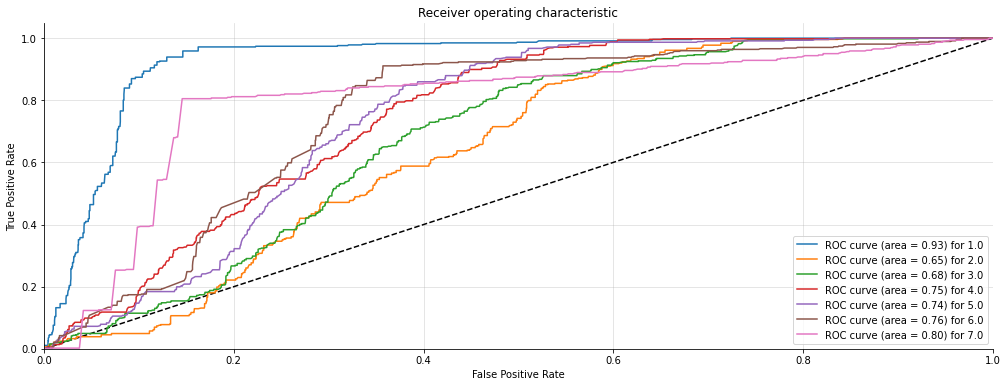

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.26      0.40      0.31       463
         2.0       0.25      0.18      0.21       491
         3.0       0.22      0.21      0.22       487
         4.0       0.30      0.18      0.22       518
         5.0       0.22      0.32      0.26       487
         6.0       0.37      0.35      0.36       462
         7.0       0.96      0.84      0.90       452

    accuracy                           0.35      3360
   macro avg       0.37      0.35      0.35      3360
weighted avg       0.36      0.35      0.35      3360

Confusion Matrix: 
 [[183  66  43  33 103  35   0]
 [103  89  80  46 120  47   6]
 [113  41 102  53 102  75   1]
 [108  65  64  93 123  61   4]
 [119  59  45  52 154  58   0]
 [ 72  32  57  34 102 161   4]
 [  2   1  68   0   1   1 379]]
Accuracy Score : 0.3455357142857143
Precision Score : 0.36278306883779265
Recall Score : 0.3455357142857143
F1 Score : 0.3472062864016

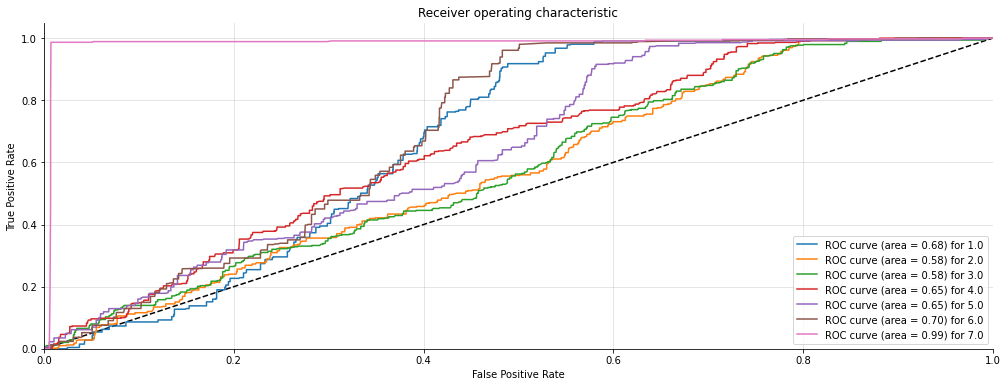

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.29      0.31      0.30       461
         2.0       0.29      0.19      0.23       495
         3.0       0.22      0.22      0.22       490
         4.0       0.33      0.20      0.25       519
         5.0       0.24      0.39      0.30       481
         6.0       0.28      0.32      0.30       465
         7.0       0.95      0.84      0.89       449

    accuracy                           0.35      3360
   macro avg       0.37      0.35      0.36      3360
weighted avg       0.36      0.35      0.35      3360

Confusion Matrix: 
 [[143  72  24  46 126  50   0]
 [ 91  95  80  48  96  80   5]
 [ 77  67 108  38 103  93   4]
 [ 60  33  74 102 175  73   2]
 [ 54  21  67  54 189  96   0]
 [ 74  44  60  24 103 151   9]
 [  0   0  69   1   0   0 379]]
Accuracy Score : 0.34732142857142856
Precision Score : 0.3640662279023016
Recall Score : 0.34732142857142856
F1 Score : 0.

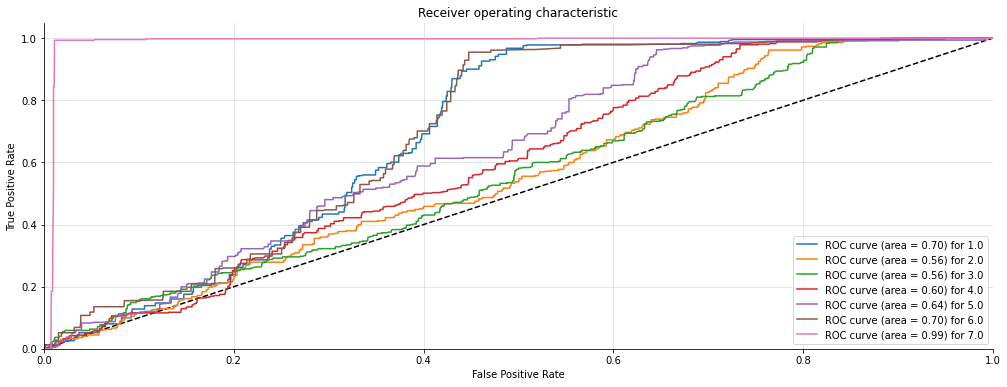

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.20      0.41      0.27       460
         2.0       0.20      0.13      0.16       502
         3.0       0.26      0.15      0.19       474
         4.0       0.22      0.26      0.24       527
         5.0       0.18      0.22      0.20       486
         6.0       0.28      0.22      0.25       459
         7.0       0.94      0.49      0.65       452

    accuracy                           0.27      3360
   macro avg       0.33      0.27      0.28      3360
weighted avg       0.32      0.27      0.27      3360

Confusion Matrix: 
 [[188  70  63  68  66   5   0]
 [187  65  20  90  89  51   0]
 [135  34  71  85 103  41   5]
 [158  49  31 135 113  37   4]
 [137  26  60 106 109  48   0]
 [133  78  30  48  63 101   6]
 [  0   0   0  82  75  72 223]]
Accuracy Score : 0.2654761904761905
Precision Score : 0.31892882950446694
Recall Score : 0.2654761904761905
F1 Score : 0.273667

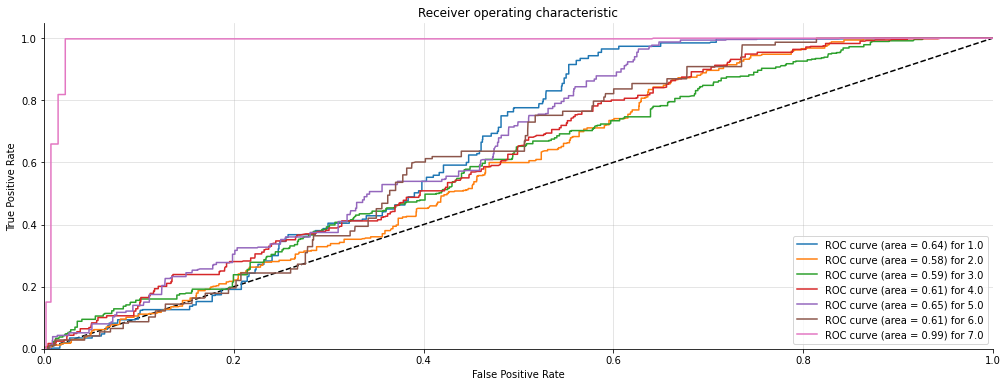

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       0.30      0.23      0.26       459
         2.0       0.22      0.15      0.18       496
         3.0       0.30      0.26      0.28       478
         4.0       0.12      0.15      0.13       523
         5.0       0.19      0.13      0.15       491
         6.0       0.20      0.46      0.28       462
         7.0       0.97      0.50      0.66       451

    accuracy                           0.26      3360
   macro avg       0.33      0.27      0.28      3360
weighted avg       0.32      0.26      0.27      3360

Confusion Matrix: 
 [[107  62  61  55  58 116   0]
 [ 67  74  60  66  70 159   0]
 [ 38  34 125  78  51 152   0]
 [ 61  65  77  77  40 195   8]
 [ 67  50  19  81  64 210   0]
 [ 16  55  74  52  53 212   0]
 [  0   0   0 224   0   0 227]]
Accuracy Score : 0.2636904761904762
Precision Score : 0.3202817253950971
Recall Score : 0.2636904761904762
F1 Score : 0.27268313126

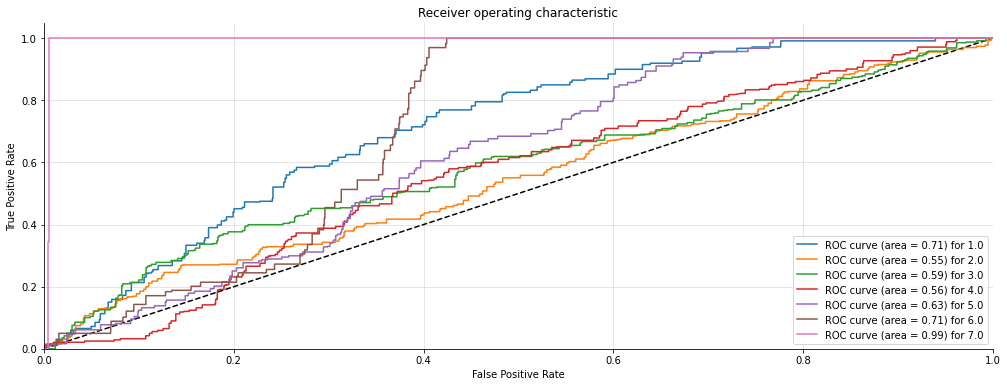

In [57]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
def ADB(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    model = AdaBoostClassifier(n_estimators=500)   
    model.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in model.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    plot_multiclass_roc(model, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  ADB(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

# Gradient boosting 

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.59      0.82      0.69       462
         2.0       0.43      0.34      0.38       482
         3.0       0.40      0.32      0.35       510
         4.0       0.41      0.33      0.37       517
         5.0       0.45      0.44      0.45       467
         6.0       0.54      0.66      0.60       470
         7.0       0.79      0.82      0.80       452

    accuracy                           0.53      3360
   macro avg       0.52      0.53      0.52      3360
weighted avg       0.51      0.53      0.51      3360

Confusion Matrix: 
 [[381  19  17  19   6  20   0]
 [ 57 166  87  73  50  39  10]
 [ 77  93 162  83  49  42   4]
 [ 57  51  88 172 126  23   0]
 [ 38  27  22  51 207 122   0]
 [ 19  21   9  15  14 309  83]
 [ 17  13  22   8  11  12 369]]
Accuracy Score : 0.5255952380952381
Precision Score : 0.5103265959199629
Recall Score : 0.5255952380952381
F1 Score : 0.5126196

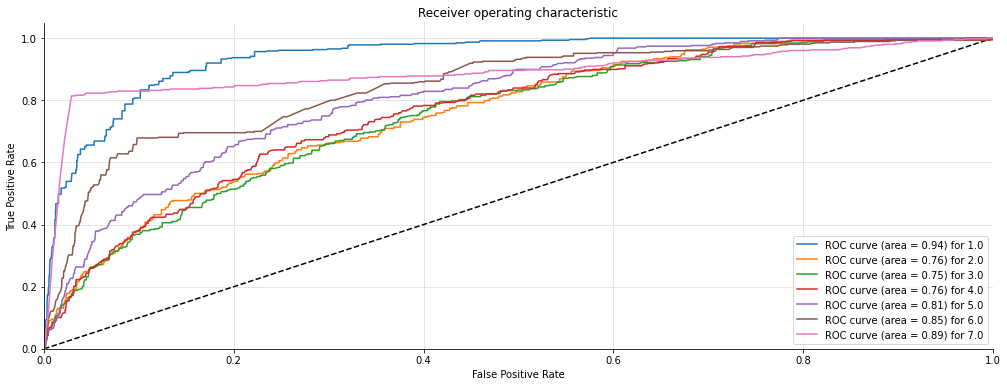

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.51      0.83      0.63       463
         2.0       0.27      0.25      0.26       485
         3.0       0.28      0.13      0.18       501
         4.0       0.34      0.31      0.32       515
         5.0       0.20      0.23      0.21       460
         6.0       0.35      0.35      0.35       484
         7.0       0.88      0.90      0.89       452

    accuracy                           0.42      3360
   macro avg       0.40      0.43      0.41      3360
weighted avg       0.40      0.42      0.40      3360

Confusion Matrix: 
 [[385   8   7  12  30  21   0]
 [ 92 119  49  66  86  66   7]
 [ 90  92  64  87 100  64   4]
 [ 56  93  38 159 108  61   0]
 [ 61  57  34 113 105  90   0]
 [ 59  58  31  35  89 169  43]
 [ 14  11   3   2   3  11 408]]
Accuracy Score : 0.4193452380952381
Precision Score : 0.3998365025375799
Recall Score : 0.4193452380952381
F1 Score : 0.3995352482965

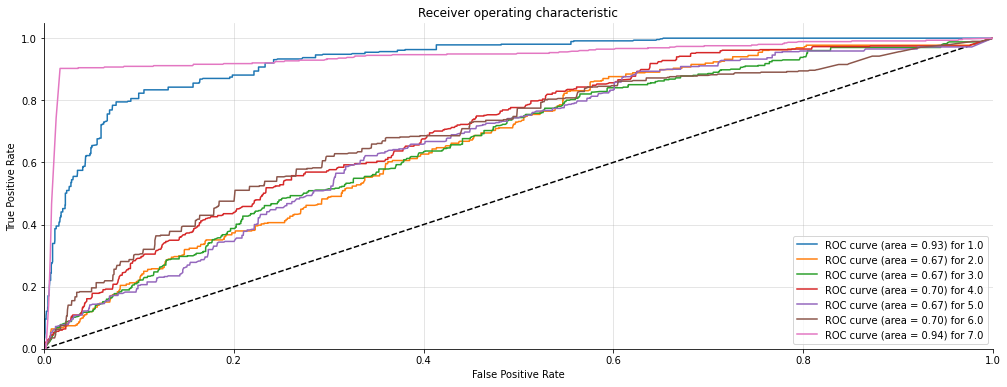

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.61      0.85      0.71       462
         2.0       0.45      0.44      0.44       482
         3.0       0.43      0.32      0.37       506
         4.0       0.45      0.33      0.38       526
         5.0       0.45      0.46      0.45       458
         6.0       0.57      0.65      0.60       475
         7.0       0.80      0.83      0.82       451

    accuracy                           0.54      3360
   macro avg       0.53      0.55      0.54      3360
weighted avg       0.53      0.54      0.53      3360

Confusion Matrix: 
 [[391  34  10   7   5  15   0]
 [ 62 210  67  49  44  43   7]
 [ 73 107 162  74  42  41   7]
 [ 63  54  81 171 132  22   3]
 [ 26  28  26  62 211 105   0]
 [ 15  16  19  13  27 307  78]
 [ 14  22  13   8  11   7 376]]
Accuracy Score : 0.544047619047619
Precision Score : 0.5301540977535424
Recall Score : 0.544047619047619
F1 Score : 0.5313184695

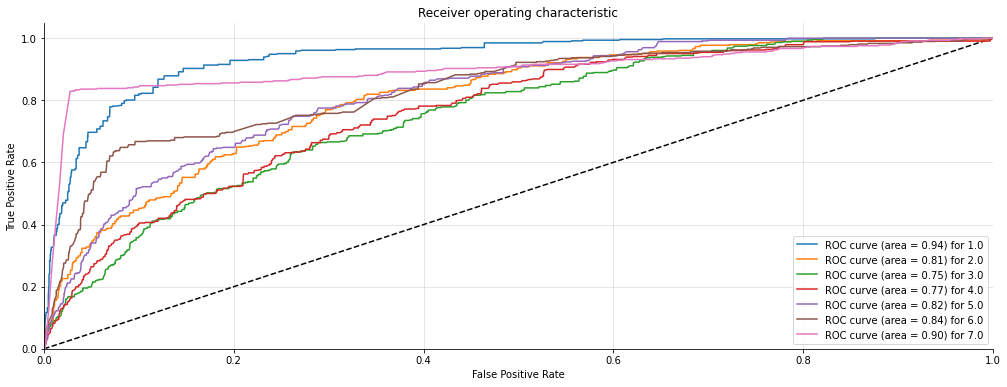

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.53      0.80      0.64       461
         2.0       0.42      0.36      0.39       488
         3.0       0.41      0.30      0.35       506
         4.0       0.43      0.37      0.40       516
         5.0       0.36      0.37      0.36       456
         6.0       0.48      0.51      0.50       471
         7.0       0.78      0.79      0.79       462

    accuracy                           0.49      3360
   macro avg       0.49      0.50      0.49      3360
weighted avg       0.49      0.49      0.48      3360

Confusion Matrix: 
 [[368  33  24   9  15  12   0]
 [ 72 174  73  51  55  50  13]
 [ 81  87 152  84  54  43   5]
 [ 61  42  59 192 120  42   0]
 [ 32  32  35  83 167 107   0]
 [ 51  25  18  11  37 242  87]
 [ 25  20  11  16  13  10 367]]
Accuracy Score : 0.49464285714285716
Precision Score : 0.48512681933054363
Recall Score : 0.49464285714285716
F1 Score : 0.4842045638

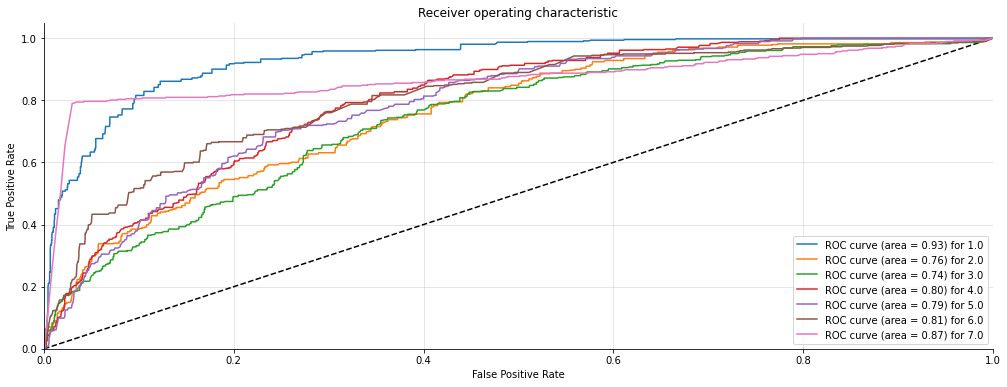

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.58      0.84      0.69       463
         2.0       0.47      0.36      0.41       491
         3.0       0.42      0.31      0.35       487
         4.0       0.47      0.41      0.44       518
         5.0       0.47      0.44      0.45       487
         6.0       0.71      0.93      0.80       462
         7.0       0.99      0.99      0.99       452

    accuracy                           0.60      3360
   macro avg       0.59      0.61      0.59      3360
weighted avg       0.58      0.60      0.58      3360

Confusion Matrix: 
 [[390  26   6  16   8  17   0]
 [ 80 177  57  78  64  35   0]
 [ 92  78 150  71  67  29   0]
 [ 68  47  64 212  87  40   0]
 [ 32  46  73  71 212  53   0]
 [  5   3  11   2   6 430   5]
 [  0   0   0   0   3   3 446]]
Accuracy Score : 0.600297619047619
Precision Score : 0.5812124574069788
Recall Score : 0.600297619047619
F1 Score : 0.5828176673788917

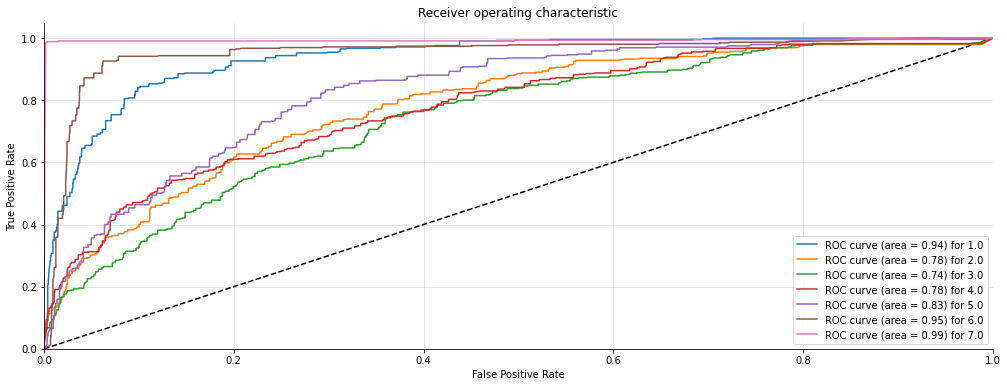

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.54      0.75      0.63       461
         2.0       0.45      0.43      0.44       495
         3.0       0.38      0.26      0.31       490
         4.0       0.39      0.31      0.35       519
         5.0       0.41      0.36      0.38       481
         6.0       0.65      0.89      0.75       465
         7.0       0.99      0.99      0.99       449

    accuracy                           0.56      3360
   macro avg       0.55      0.57      0.55      3360
weighted avg       0.54      0.56      0.54      3360

Confusion Matrix: 
 [[346  36  14  17  17  31   0]
 [ 55 214  55  50  69  52   0]
 [ 96  90 125  74  63  42   0]
 [ 70  74  73 160 101  41   0]
 [ 50  49  58  97 175  52   0]
 [ 21  11   1   8   5 414   5]
 [  0   0   0   0   1   2 446]]
Accuracy Score : 0.5595238095238095
Precision Score : 0.5383551198024283
Recall Score : 0.5595238095238095
F1 Score : 0.54

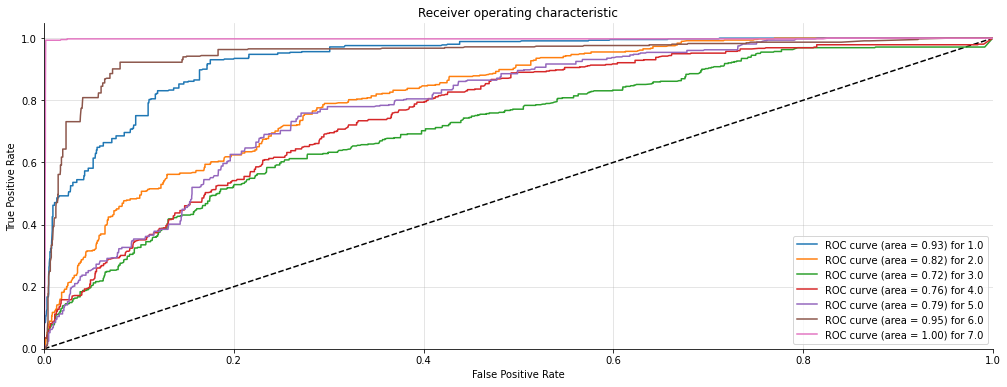

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.61      0.84      0.71       460
         2.0       0.39      0.32      0.35       502
         3.0       0.45      0.33      0.38       474
         4.0       0.61      0.50      0.55       527
         5.0       0.52      0.49      0.51       486
         6.0       0.69      0.91      0.78       459
         7.0       0.98      1.00      0.99       452

    accuracy                           0.62      3360
   macro avg       0.61      0.63      0.61      3360
weighted avg       0.60      0.62      0.60      3360

Confusion Matrix: 
 [[385  18   8  20  10  19   0]
 [ 67 160  83  55  92  45   0]
 [ 78  86 158  47  63  42   0]
 [ 42  80  43 262  53  45   2]
 [ 44  65  52  47 240  38   0]
 [ 16   1   9   0   6 419   8]
 [  0   0   0   0   0   1 451]]
Accuracy Score : 0.6175595238095238
Precision Score : 0.6005989507411464
Recall Score : 0.6175595238095238
F1 Score : 0.6018259

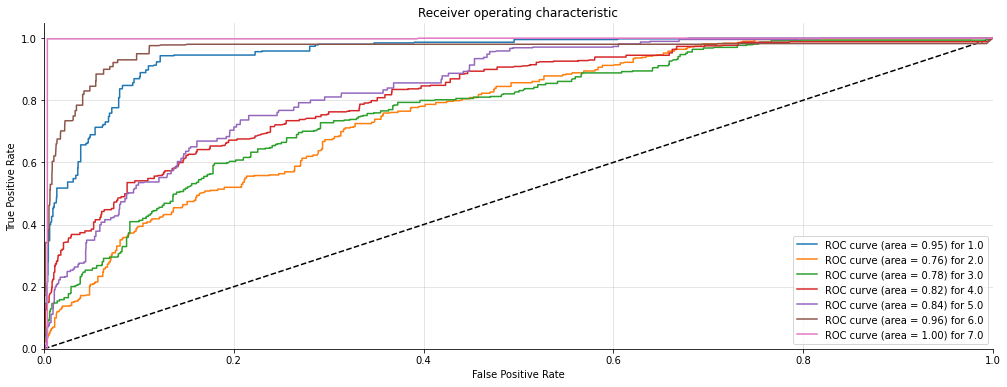

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       0.62      0.81      0.70       459
         2.0       0.37      0.29      0.33       496
         3.0       0.48      0.40      0.44       478
         4.0       0.52      0.40      0.45       523
         5.0       0.51      0.52      0.51       491
         6.0       0.71      0.94      0.81       462
         7.0       1.00      1.00      1.00       451

    accuracy                           0.61      3360
   macro avg       0.60      0.62      0.61      3360
weighted avg       0.59      0.61      0.60      3360

Confusion Matrix: 
 [[374  32   1  14  19  19   0]
 [ 64 145  92  71  87  37   0]
 [ 70  68 193  54  58  35   0]
 [ 43  92  67 207  78  36   0]
 [ 44  52  41  50 254  50   0]
 [ 13   0   9   0   4 436   0]
 [  0   0   0   0   0   0 451]]
Accuracy Score : 0.6130952380952381
Precision Score : 0.5948102730796034
Recall Score : 0.6130952380952381
F1 Score : 0.59725922747

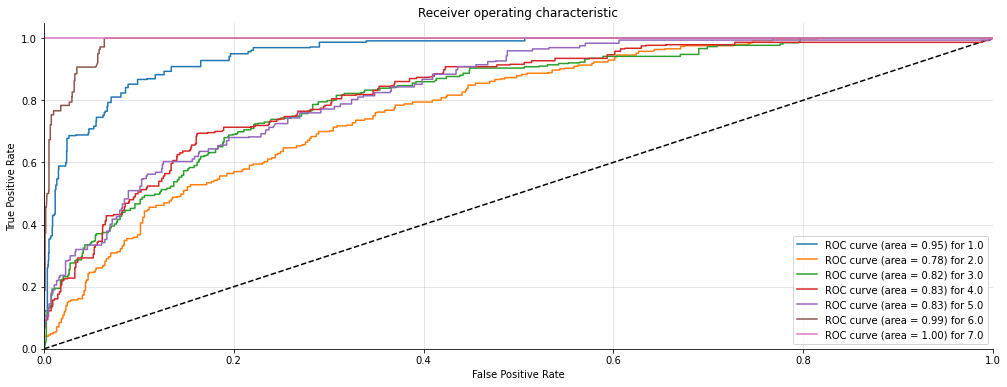

In [58]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
def GBC(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=1, random_state=0)   
    model.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in model.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    plot_multiclass_roc(model, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  GBC(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

# Bagging classfier

In [59]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.95      0.96      0.95       462
         2.0       0.79      0.87      0.83       482
         3.0       0.73      0.66      0.70       510
         4.0       0.64      0.65      0.65       517
         5.0       0.63      0.63      0.63       467
         6.0       0.72      0.70      0.71       470
         7.0       0.81      0.81      0.81       452

    accuracy                           0.75      3360
   macro avg       0.75      0.75      0.75      3360
weighted avg       0.75      0.75      0.75      3360

Confusion Matrix: 
 [[442  19   0   1   0   0   0]
 [  5 420  50   3   1   2   1]
 [  3  37 338 121   3   8   0]
 [  0   5  31 338 141   2   0]
 [  4   4  15  42 293 109   0]
 [  3  22   8  10  17 327  83]
 [ 10  26  20  12  10   6 368]]
Accuracy Score : 0.7517857142857143
Precision Score : 0.7507642005055208
Recall Score : 0.7517857142857143
F1 Score : 0.7506733

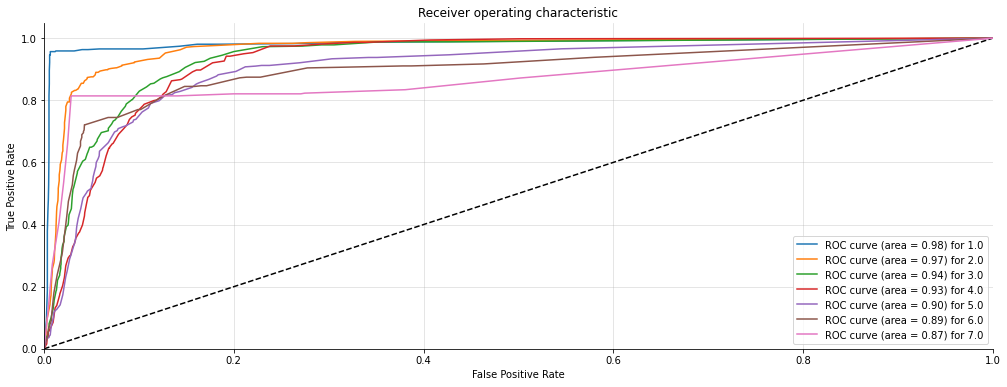

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.95      0.95      0.95       463
         2.0       0.81      0.86      0.84       485
         3.0       0.74      0.70      0.72       501
         4.0       0.69      0.67      0.68       515
         5.0       0.69      0.73      0.71       460
         6.0       0.82      0.79      0.81       484
         7.0       0.90      0.90      0.90       452

    accuracy                           0.80      3360
   macro avg       0.80      0.80      0.80      3360
weighted avg       0.80      0.80      0.80      3360

Confusion Matrix: 
 [[442  20   0   0   0   1   0]
 [  3 419  51   2   6   4   0]
 [  1  25 353 113   7   2   0]
 [  0   2  39 344 127   3   0]
 [  3  12  16  24 335  70   0]
 [  5  19  13  14   6 384  43]
 [  9  19   5   4   5   2 408]]
Accuracy Score : 0.7991071428571429
Precision Score : 0.7991121320731261
Recall Score : 0.7991071428571429
F1 Score : 0.7987937912937

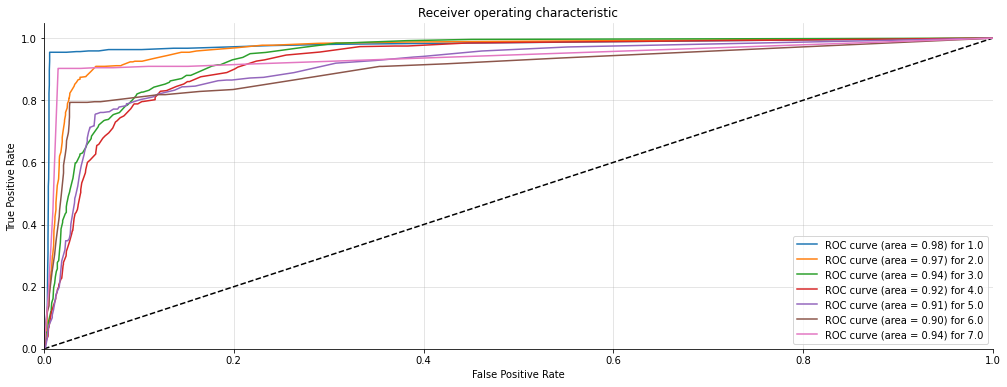

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.94      0.96      0.95       462
         2.0       0.83      0.86      0.84       482
         3.0       0.72      0.71      0.71       506
         4.0       0.65      0.64      0.65       526
         5.0       0.63      0.65      0.64       458
         6.0       0.72      0.70      0.71       475
         7.0       0.83      0.83      0.83       451

    accuracy                           0.76      3360
   macro avg       0.76      0.76      0.76      3360
weighted avg       0.76      0.76      0.76      3360

Confusion Matrix: 
 [[442  19   0   0   0   1   0]
 [  6 414  51   4   4   3   0]
 [  3  15 357 122   5   3   1]
 [  0   2  42 336 146   0   0]
 [  2   4   8  32 298 114   0]
 [  6  18  22  10   8 334  77]
 [  9  27  14  11  10   6 374]]
Accuracy Score : 0.7604166666666666
Precision Score : 0.7595739788822258
Recall Score : 0.7604166666666666
F1 Score : 0.75988689

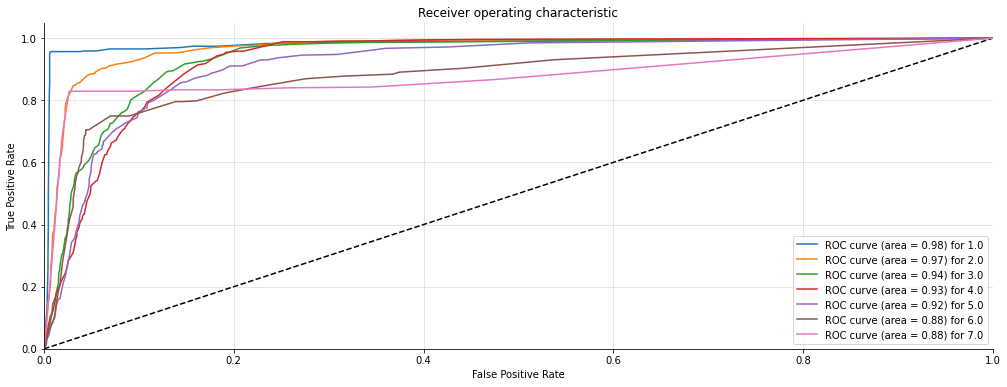

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.95      0.96      0.95       461
         2.0       0.82      0.87      0.84       488
         3.0       0.74      0.68      0.71       506
         4.0       0.64      0.66      0.65       516
         5.0       0.66      0.65      0.65       456
         6.0       0.73      0.72      0.73       471
         7.0       0.81      0.79      0.80       462

    accuracy                           0.76      3360
   macro avg       0.76      0.76      0.76      3360
weighted avg       0.76      0.76      0.76      3360

Confusion Matrix: 
 [[442  18   0   1   0   0   0]
 [  4 425  48   5   3   3   0]
 [  4  25 344 131   0   1   1]
 [  0   1  29 343 141   2   0]
 [  2   1   8  35 297 113   0]
 [  2  15  16   9   4 339  86]
 [ 13  34  22  16   8   4 365]]
Accuracy Score : 0.7604166666666666
Precision Score : 0.760138528094113
Recall Score : 0.7604166666666666
F1 Score : 0.75990934057638

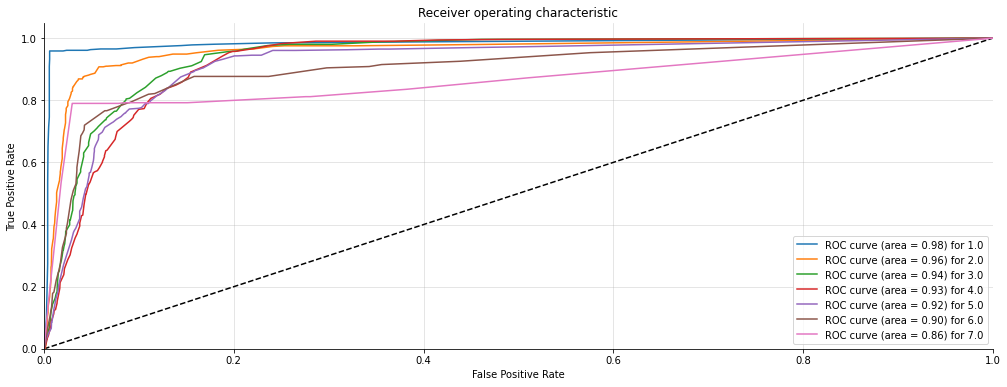

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.86      0.86      0.86       491
         3.0       0.81      0.79      0.80       487
         4.0       0.85      0.85      0.85       518
         5.0       0.91      0.92      0.91       487
         6.0       0.96      0.96      0.96       462
         7.0       0.99      0.99      0.99       452

    accuracy                           0.90      3360
   macro avg       0.90      0.90      0.90      3360
weighted avg       0.90      0.90      0.90      3360

Confusion Matrix: 
 [[442  18   1   0   1   1   0]
 [  8 420  48   9   3   3   0]
 [  7  29 386  59   6   0   0]
 [  3  16  27 439  32   1   0]
 [  1   5  11   9 450  11   0]
 [  1   3   4   2   4 443   5]
 [  0   0   2   0   1   3 446]]
Accuracy Score : 0.9005952380952381
Precision Score : 0.9003982326245038
Recall Score : 0.9005952380952381
F1 Score : 0.90047478085366

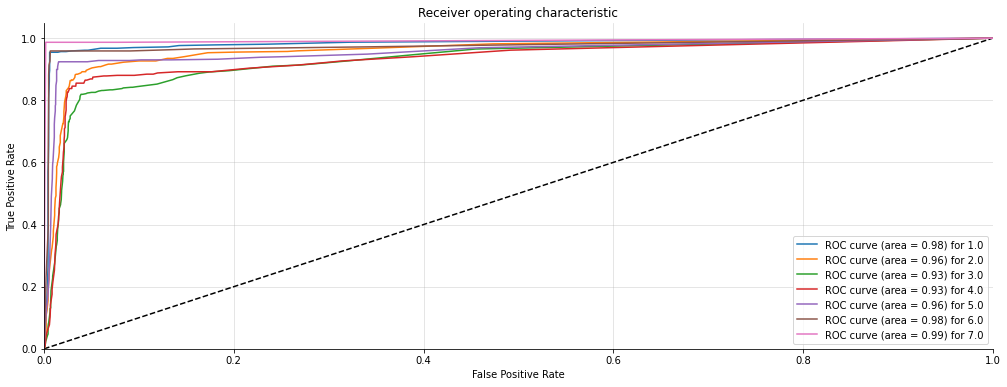

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.95      0.96      0.95       461
         2.0       0.84      0.86      0.85       495
         3.0       0.81      0.75      0.78       490
         4.0       0.81      0.82      0.82       519
         5.0       0.88      0.91      0.89       481
         6.0       0.96      0.96      0.96       465
         7.0       0.99      0.99      0.99       449

    accuracy                           0.89      3360
   macro avg       0.89      0.89      0.89      3360
weighted avg       0.89      0.89      0.89      3360

Confusion Matrix: 
 [[442  18   1   0   0   0   0]
 [ 11 425  45   5   5   4   0]
 [  8  37 368  75   1   1   0]
 [  3  18  25 426  47   0   0]
 [  1   8  10  15 436  11   0]
 [  1   2   4   2   6 445   5]
 [  0   0   2   0   0   1 446]]
Accuracy Score : 0.8892857142857142
Precision Score : 0.8886939174992882
Recall Score : 0.8892857142857142
F1 Score : 0.88

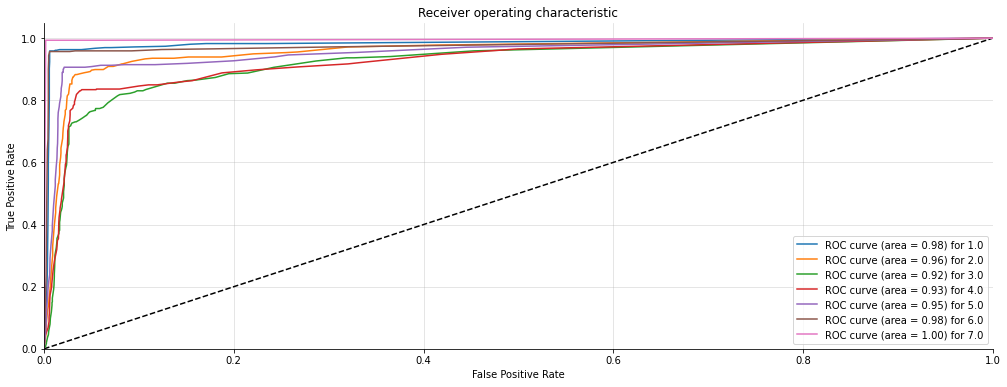

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.98      0.99      0.98       460
         2.0       0.92      0.94      0.93       502
         3.0       0.93      0.89      0.91       474
         4.0       0.95      0.94      0.95       527
         5.0       0.96      0.98      0.97       486
         6.0       0.98      0.99      0.99       459
         7.0       1.00      1.00      1.00       452

    accuracy                           0.96      3360
   macro avg       0.96      0.96      0.96      3360
weighted avg       0.96      0.96      0.96      3360

Confusion Matrix: 
 [[454   6   0   0   0   0   0]
 [  7 471  15   4   5   0   0]
 [  1  35 423  14   0   0   1]
 [  0   1  15 496  10   5   0]
 [  0   0   0   8 476   2   0]
 [  0   0   0   0   4 455   0]
 [  0   0   0   0   0   1 451]]
Accuracy Score : 0.9601190476190476
Precision Score : 0.9600327426261415
Recall Score : 0.9601190476190476
F1 Score : 0.9599751

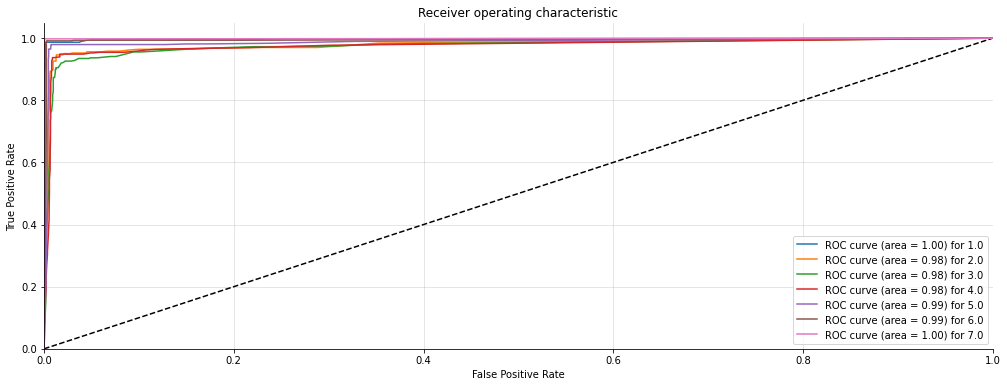

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       459
         2.0       0.99      0.97      0.98       496
         3.0       0.98      0.97      0.97       478
         4.0       0.99      0.99      0.99       523
         5.0       0.98      1.00      0.99       491
         6.0       1.00      1.00      1.00       462
         7.0       1.00      1.00      1.00       451

    accuracy                           0.99      3360
   macro avg       0.99      0.99      0.99      3360
weighted avg       0.99      0.99      0.99      3360

Confusion Matrix: 
 [[459   0   0   0   0   0   0]
 [  0 482   8   3   3   0   0]
 [  1   4 463   4   6   0   0]
 [  0   2   2 519   0   0   0]
 [  0   0   0   0 491   0   0]
 [  0   0   0   0   0 462   0]
 [  0   0   0   0   0   0 451]]
Accuracy Score : 0.9901785714285715
Precision Score : 0.9901785800495342
Recall Score : 0.9901785714285715
F1 Score : 0.99015182144

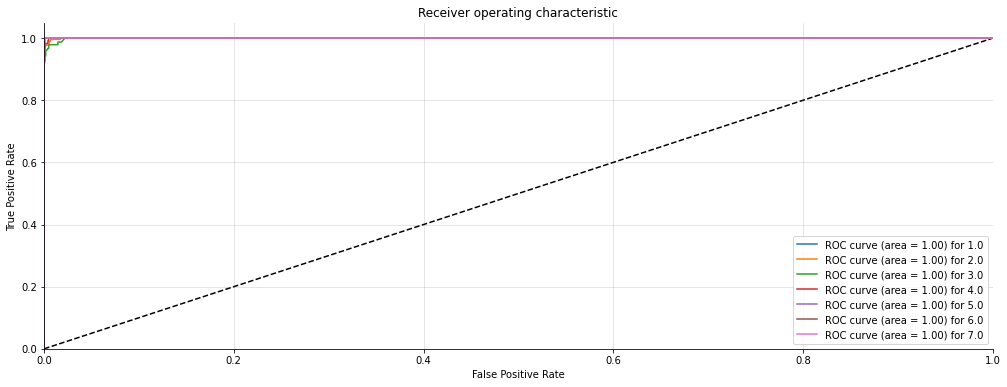

In [60]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
def BAG(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    model = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5)   
    model.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in model.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    # report performance
    print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
    plot_multiclass_roc(model, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  BAG(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))